# Regressed Feature Comparison

## Import

### Import modules

In [8]:
import theano
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import time
from __future__ import division
import theano.tensor as T
from scipy.stats import ks_2samp
import scipy.misc
import seaborn as sns
sns.set_style("white")
import os
import sys
sys.path.append('../')
from Regression_Application import *
sys.path.append('../../../modules')
from MPPlot import *
from Processors import *

### Import data
Here just looking at mu tau_h b b final-state

In [83]:
mode = "mu_tau_b_b"
loc = '../../../../data_n/'
SignalData = []
BackgroundData = []

energies = ['260', '270', '280', '320', '300','400','500', '550', '600' , '700']
backgrounds = ['TT' , 'WJetsToLNu']
Data = np.concatenate((energies,backgrounds))

def backgroundName(background):
    if background == 'TT':
        return loc + 'TT_TuneCUETP8M1_13TeV-powheg-pythia8_2.csv'
    elif background == 'WJetsToLNu':
        return loc + 'WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8.csv'



 #Load data from CSV files
for energy in energies:
    signaldata = pandas.read_csv(loc + "GluGluToRadionToHHTo2B2Tau_M-" + str(energy) +"_narrow_13TeV-madgraph.csv")
    signaldata['gen_label'] = energy
    SignalData.append(signaldata)


for back in backgrounds:
    backgroundData = pandas.read_csv(backgroundName(back))
    backgroundData['gen_label'] = back
    BackgroundData.append(backgroundData)    
     
    
signalData = SignalData[0]
for signal_data in SignalData[1:]:
    signalData = signalData.append(signal_data, ignore_index=True)    
signalData.drop([x for x in signalData.columns if 'Unnamed' in x], axis=1, inplace=True)    
signalData['gen_target'] = pandas.Series(np.ones(signalData.size))
backgroundData = BackgroundData[0]
for background_data in BackgroundData[1:]:
    backgroundData = backgroundData.append(background_data, ignore_index=True)    
backgroundData.drop([x for x in backgroundData.columns if 'Unnamed' in x], axis=1, inplace=True)    
backgroundData['gen_target'] = pandas.Series(np.zeros(backgroundData.size))

print("Samples contains {0} signal events and {1} background events".format(len(signalData), len(backgroundData)))
print("{} events in total".format(len(signalData)+len(backgroundData)))
data = signalData.append(backgroundData, ignore_index = True) #Combine into signal dataset


def abs_(x):
    if type(x) is float:
        return abs(x)
    else:
        return x

def cleanData(X):
    """
    Recives data and labels (X and y)
    
    Returns: X, y after removing points that would fail to convert to float32 
    """
    X.applymap(abs_)
    
    
    over  = (X > np.finfo(np.float32).max)
    under = (X < np.finfo(np.float32).min)
    selecting = pandas.Series(np.zeros(len(X)), dtype=np.bool)

    for label in over.columns:
        if label != 'gen_label':
            selecting = selecting | over[label] | under[label]
    
    
    X = X[np.logical_not(selecting)].reset_index(drop=True)#.values.astype('float32')
    
    return X

data = cleanData(data)

Samples contains 10417 signal events and 168053 background events
178470 events in total


## Configure data

### Move to cartesian coordinates

In [84]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH', 'gen_t_0', 'gen_t_1', 'gen_b_0' ,'gen_b_1']

for p in particles:
    moveToCartesian(data, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    if(not str.startswith(p, "gen")):
        addEnergy(data, p) #Calculate energy and absolute momentum
 

moveToCartesian(data, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(data, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(data, data['t_1_pT'], data['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu
addHighLvl(data)
data['hl_mT'] = np.sqrt(2*data['t_1_pT']*data['mPT_pT']*(1-np.cos(deltaphi(data['t_1_phi'], data['mPT_phi']))))

In [85]:
sig_devIndeces, sig_valIndeces = \
                train_test_split([i for i in data[(data.gen_target == 1) & (data.gen_mctMatch == 1)].index.tolist()],
                                 test_size=0.2, random_state=1337)

    
devData = data.loc[sig_devIndeces].copy()
#devData = devData.append(data.loc[bkg_devIndeces].copy(), ignore_index = True)
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data[data.gen_target == 0].copy(), ignore_index = True)
valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)

print("{} events for training, {} events for validation".format(len(devData), len(valData)))


3928 events for training, 174533 events for validation


## Apply regressors

In [86]:
btrain = ['t_0_mass', 't_1_mass', 'b_0_mass', 'b_0_csv', 'b_1_mass', 'b_1_csv', 'mT', 'hT', 'sT', 'centrality', 'eVis', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_dpx_b_0_b_1', 'hl_dpy_b_0_b_1', 'hl_dpz_b_0_b_1', 'hl_dpx_b_0_t_0', 'hl_dpy_b_0_t_0', 'hl_dpz_b_0_t_0', 'hl_dpx_b_0_t_1', 'hl_dpy_b_0_t_1', 'hl_dpz_b_0_t_1', 'hl_dpx_b_0_mPT', 'hl_dpy_b_0_mPT', 'hl_dpx_b_1_b_0', 'hl_dpy_b_1_b_0', 'hl_dpz_b_1_b_0', 'hl_dpx_b_1_t_0', 'hl_dpy_b_1_t_0', 'hl_dpz_b_1_t_0', 'hl_dpx_b_1_t_1', 'hl_dpy_b_1_t_1', 'hl_dpz_b_1_t_1', 'hl_dpx_b_1_mPT', 'hl_dpy_b_1_mPT', 'hl_dpx_t_0_b_0', 'hl_dpy_t_0_b_0', 'hl_dpz_t_0_b_0', 'hl_dpx_t_0_b_1', 'hl_dpy_t_0_b_1', 'hl_dpz_t_0_b_1', 'hl_dpx_t_0_t_1', 'hl_dpy_t_0_t_1', 'hl_dpz_t_0_t_1', 'hl_dpx_t_0_mPT', 'hl_dpy_t_0_mPT', 'hl_dpx_t_1_b_0', 'hl_dpy_t_1_b_0', 'hl_dpz_t_1_b_0', 'hl_dpx_t_1_b_1', 'hl_dpy_t_1_b_1', 'hl_dpz_t_1_b_1', 'hl_dpx_t_1_t_0', 'hl_dpy_t_1_t_0', 'hl_dpz_t_1_t_0', 'hl_dpx_t_1_mPT', 'hl_dpy_t_1_mPT', 'hl_dpx_diH_h_bb', 'hl_dpy_diH_h_bb', 'hl_dpz_diH_h_bb', 'hl_dpx_diH_h_tt', 'hl_dpy_diH_h_tt', 'hl_dpz_diH_h_tt', 'hl_dpx_diH_mPT', 'hl_dpy_diH_mPT', 'hl_dpx_h_bb_diH', 'hl_dpy_h_bb_diH', 'hl_dpz_h_bb_diH', 'hl_dpx_h_bb_h_tt', 'hl_dpy_h_bb_h_tt', 'hl_dpz_h_bb_h_tt', 'hl_dpx_h_bb_mPT', 'hl_dpy_h_bb_mPT', 'hl_dpx_h_tt_diH', 'hl_dpy_h_tt_diH', 'hl_dpz_h_tt_diH', 'hl_dpx_h_tt_h_bb', 'hl_dpy_h_tt_h_bb', 'hl_dpz_h_tt_h_bb', 'hl_dpx_h_tt_mPT', 'hl_dpy_h_tt_mPT', 'hl_mT', 'h_tt_mass', 'h_tt_svFit_mass', 'h_bb_mass', 'diH_mass', 'diH_kinFit_mass', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'hl_mT']
bRegressor = BPairRegressor(data, "./bRegression/weights/NN_B_Regressor_App_" + mode + "_"  , mode , btrain)
bRegressor.evalResponse()
bRegressor.getExtraVariables()
bRegressor.refineDiHiggsVector()

(10, 'components found in ensemble')


In [87]:
ttrain = ['t_0_mass', 't_1_mass', 'b_0_mass', 'b_0_csv', 'b_1_mass', 'b_1_csv', 'mT', 'hT', 'sT', 'centrality', 'eVis', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_dpx_b_0_b_1', 'hl_dpy_b_0_b_1', 'hl_dpz_b_0_b_1', 'hl_dpx_b_0_t_0', 'hl_dpy_b_0_t_0', 'hl_dpz_b_0_t_0', 'hl_dpx_b_0_t_1', 'hl_dpy_b_0_t_1', 'hl_dpz_b_0_t_1', 'hl_dpx_b_0_mPT', 'hl_dpy_b_0_mPT', 'hl_dpx_b_1_b_0', 'hl_dpy_b_1_b_0', 'hl_dpz_b_1_b_0', 'hl_dpx_b_1_t_0', 'hl_dpy_b_1_t_0', 'hl_dpz_b_1_t_0', 'hl_dpx_b_1_t_1', 'hl_dpy_b_1_t_1', 'hl_dpz_b_1_t_1', 'hl_dpx_b_1_mPT', 'hl_dpy_b_1_mPT', 'hl_dpx_t_0_b_0', 'hl_dpy_t_0_b_0', 'hl_dpz_t_0_b_0', 'hl_dpx_t_0_b_1', 'hl_dpy_t_0_b_1', 'hl_dpz_t_0_b_1', 'hl_dpx_t_0_t_1', 'hl_dpy_t_0_t_1', 'hl_dpz_t_0_t_1', 'hl_dpx_t_0_mPT', 'hl_dpy_t_0_mPT', 'hl_dpx_t_1_b_0', 'hl_dpy_t_1_b_0', 'hl_dpz_t_1_b_0', 'hl_dpx_t_1_b_1', 'hl_dpy_t_1_b_1', 'hl_dpz_t_1_b_1', 'hl_dpx_t_1_t_0', 'hl_dpy_t_1_t_0', 'hl_dpz_t_1_t_0', 'hl_dpx_t_1_mPT', 'hl_dpy_t_1_mPT', 'hl_dpx_diH_h_bb', 'hl_dpy_diH_h_bb', 'hl_dpz_diH_h_bb', 'hl_dpx_diH_h_tt', 'hl_dpy_diH_h_tt', 'hl_dpz_diH_h_tt', 'hl_dpx_diH_mPT', 'hl_dpy_diH_mPT', 'hl_dpx_h_bb_diH', 'hl_dpy_h_bb_diH', 'hl_dpz_h_bb_diH', 'hl_dpx_h_bb_h_tt', 'hl_dpy_h_bb_h_tt', 'hl_dpz_h_bb_h_tt', 'hl_dpx_h_bb_mPT', 'hl_dpy_h_bb_mPT', 'hl_dpx_h_tt_diH', 'hl_dpy_h_tt_diH', 'hl_dpz_h_tt_diH', 'hl_dpx_h_tt_h_bb', 'hl_dpy_h_tt_h_bb', 'hl_dpz_h_tt_h_bb', 'hl_dpx_h_tt_mPT', 'hl_dpy_h_tt_mPT', 'hl_mT', 'regB_b_0_px', 'regB_b_0_py', 'regB_b_0_pz', 'regB_b_1_px', 'regB_b_1_py', 'regB_b_1_pz', 'regB_b_0_|p|', 'regB_b_0_E', 'regB_b_1_|p|', 'regB_b_1_E', 'regB_h_bb_px', 'regB_h_bb_py', 'regB_h_bb_pz', 'regB_h_bb_E', 'regB_h_bb_|p|', 'regB_h_bb_mass', 'regB_diH_px', 'regB_diH_py', 'regB_diH_pz', 'regB_diH_E', 'regB_diH_|p|', 'regB_diH_mass', 'h_tt_mass', 'h_tt_svFit_mass', 'diH_kinFit_mass', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'hl_mT']
tauRegressor = TauPairRegressor(data, "./tauRegression/weights/NN_Tau_Regressor_App_" + mode + "_"  , mode, ttrain )
tauRegressor.evalResponse()
tauRegressor.getExtraVariables()
tauRegressor.refineDiHiggsVector()

(10, 'components found in ensemble')


In [88]:
hhmtrain = ['t_0_mass', 'b_0_mass', 'b_0_csv', 'b_1_mass', 'b_1_csv', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_dpx_b_0_b_1', 'hl_dpy_b_0_b_1', 'hl_dpz_b_0_b_1', 'hl_dpx_b_0_t_0', 'hl_dpy_b_0_t_0', 'hl_dpz_b_0_t_0', 'hl_dpx_b_0_t_1', 'hl_dpy_b_0_t_1', 'hl_dpz_b_0_t_1', 'hl_dpx_b_0_mPT', 'hl_dpy_b_0_mPT', 'hl_dpx_b_1_b_0', 'hl_dpy_b_1_b_0', 'hl_dpz_b_1_b_0', 'hl_dpx_b_1_t_0', 'hl_dpy_b_1_t_0', 'hl_dpz_b_1_t_0', 'hl_dpx_b_1_t_1', 'hl_dpy_b_1_t_1', 'hl_dpz_b_1_t_1', 'hl_dpx_b_1_mPT', 'hl_dpy_b_1_mPT', 'hl_dpx_t_0_b_0', 'hl_dpy_t_0_b_0', 'hl_dpz_t_0_b_0', 'hl_dpx_t_0_b_1', 'hl_dpy_t_0_b_1', 'hl_dpz_t_0_b_1', 'hl_dpx_t_0_t_1', 'hl_dpy_t_0_t_1', 'hl_dpz_t_0_t_1', 'hl_dpx_t_0_mPT', 'hl_dpy_t_0_mPT', 'hl_dpx_t_1_b_0', 'hl_dpy_t_1_b_0', 'hl_dpz_t_1_b_0', 'hl_dpx_t_1_b_1', 'hl_dpy_t_1_b_1', 'hl_dpz_t_1_b_1', 'hl_dpx_t_1_t_0', 'hl_dpy_t_1_t_0', 'hl_dpz_t_1_t_0', 'hl_dpx_t_1_mPT', 'hl_dpy_t_1_mPT', 'hl_dpx_diH_h_bb', 'hl_dpy_diH_h_bb', 'hl_dpz_diH_h_bb', 'hl_dpx_diH_h_tt', 'hl_dpy_diH_h_tt', 'hl_dpz_diH_h_tt', 'hl_dpx_diH_mPT', 'hl_dpy_diH_mPT', 'hl_dpx_h_bb_diH', 'hl_dpy_h_bb_diH', 'hl_dpz_h_bb_diH', 'hl_dpx_h_bb_h_tt', 'hl_dpy_h_bb_h_tt', 'hl_dpz_h_bb_h_tt', 'hl_dpx_h_bb_mPT', 'hl_dpy_h_bb_mPT', 'hl_dpx_h_tt_diH', 'hl_dpy_h_tt_diH', 'hl_dpz_h_tt_diH', 'hl_dpx_h_tt_h_bb', 'hl_dpy_h_tt_h_bb', 'hl_dpz_h_tt_h_bb', 'hl_dpx_h_tt_mPT', 'hl_dpy_h_tt_mPT', 'hl_mT', 'regB_b_0_px', 'regB_b_0_py', 'regB_b_0_pz', 'regB_b_1_px', 'regB_b_1_py', 'regB_b_1_pz', 'regB_b_0_|p|', 'regB_b_0_E', 'regB_b_1_|p|', 'regB_b_1_E', 'regB_h_bb_px', 'regB_h_bb_py', 'regB_h_bb_pz', 'regB_h_bb_E', 'regB_h_bb_|p|', 'regB_h_bb_mass', 'regTau_t_0_px', 'regTau_t_0_py', 'regTau_t_0_pz', 'regTau_t_1_px', 'regTau_t_1_py', 'regTau_t_1_pz', 'regTau_t_0_|p|', 'regTau_t_0_E', 'regTau_t_1_|p|', 'regTau_t_1_E', 'regTau_h_tt_px', 'regTau_h_tt_py', 'regTau_h_tt_pz', 'regTau_h_tt_E', 'regTau_h_tt_|p|', 'regTau_h_tt_mass', 'regTau_diH_px', 'regTau_diH_py', 'regTau_diH_pz', 'regTau_diH_E', 'regTau_diH_|p|', 'regTau_diH_mass', 'h_tt_svFit_mass', 'diH_kinFit_mass', 'hl_mT']
hhMomRegressor = HHMomRegressor(data, "./hhMomRegression/weights/NN_HH_Mom_Regressor_App_" + mode + "_" , mode, hhmtrain)
hhMomRegressor.evalResponse()
hhMomRegressor.getExtraVariables()

(10, 'components found in ensemble')


In [89]:
hhtrain = ['t_0_mass', 't_1_mass', 'b_0_mass', 'b_0_csv', 'b_1_mass', 'b_1_csv', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_dpx_b_0_b_1', 'hl_dpy_b_0_b_1', 'hl_dpz_b_0_b_1', 'hl_dpx_b_0_t_0', 'hl_dpy_b_0_t_0', 'hl_dpz_b_0_t_0', 'hl_dpx_b_0_t_1', 'hl_dpy_b_0_t_1', 'hl_dpz_b_0_t_1', 'hl_dpx_b_0_mPT', 'hl_dpy_b_0_mPT', 'hl_dpx_b_1_b_0', 'hl_dpy_b_1_b_0', 'hl_dpz_b_1_b_0', 'hl_dpx_b_1_t_0', 'hl_dpy_b_1_t_0', 'hl_dpz_b_1_t_0', 'hl_dpx_b_1_t_1', 'hl_dpy_b_1_t_1', 'hl_dpz_b_1_t_1', 'hl_dpx_b_1_mPT', 'hl_dpy_b_1_mPT', 'hl_dpx_t_0_b_0', 'hl_dpy_t_0_b_0', 'hl_dpz_t_0_b_0', 'hl_dpx_t_0_b_1', 'hl_dpy_t_0_b_1', 'hl_dpz_t_0_b_1', 'hl_dpx_t_0_t_1', 'hl_dpy_t_0_t_1', 'hl_dpz_t_0_t_1', 'hl_dpx_t_0_mPT', 'hl_dpy_t_0_mPT', 'hl_dpx_t_1_b_0', 'hl_dpy_t_1_b_0', 'hl_dpz_t_1_b_0', 'hl_dpx_t_1_b_1', 'hl_dpy_t_1_b_1', 'hl_dpz_t_1_b_1', 'hl_dpx_t_1_t_0', 'hl_dpy_t_1_t_0', 'hl_dpz_t_1_t_0', 'hl_dpx_t_1_mPT', 'hl_dpy_t_1_mPT', 'hl_dpx_diH_h_bb', 'hl_dpy_diH_h_bb', 'hl_dpz_diH_h_bb', 'hl_dpx_diH_h_tt', 'hl_dpy_diH_h_tt', 'hl_dpz_diH_h_tt', 'hl_dpx_diH_mPT', 'hl_dpy_diH_mPT', 'hl_dpx_h_bb_diH', 'hl_dpy_h_bb_diH', 'hl_dpz_h_bb_diH', 'hl_dpx_h_bb_h_tt', 'hl_dpy_h_bb_h_tt', 'hl_dpz_h_bb_h_tt', 'hl_dpx_h_bb_mPT', 'hl_dpy_h_bb_mPT', 'hl_dpx_h_tt_diH', 'hl_dpy_h_tt_diH', 'hl_dpz_h_tt_diH', 'hl_dpx_h_tt_h_bb', 'hl_dpy_h_tt_h_bb', 'hl_dpz_h_tt_h_bb', 'hl_dpx_h_tt_mPT', 'hl_dpy_h_tt_mPT', 'hl_mT', 'regB_b_0_px', 'regB_b_0_py', 'regB_b_0_pz', 'regB_b_1_px', 'regB_b_1_py', 'regB_b_1_pz', 'regB_b_0_|p|', 'regB_b_0_E', 'regB_b_1_|p|', 'regB_b_1_E', 'regB_h_bb_px', 'regB_h_bb_py', 'regB_h_bb_pz', 'regB_h_bb_E', 'regB_h_bb_|p|', 'regB_h_bb_mass', 'regTau_t_0_px', 'regTau_t_0_py', 'regTau_t_0_pz', 'regTau_t_1_px', 'regTau_t_1_py', 'regTau_t_1_pz', 'regTau_t_0_|p|', 'regTau_t_0_E', 'regTau_t_1_|p|', 'regTau_t_1_E', 'regTau_h_tt_px', 'regTau_h_tt_py', 'regTau_h_tt_pz', 'regTau_h_tt_E', 'regTau_h_tt_|p|', 'regTau_h_tt_mass', 'regHH_diH_px', 'regHH_diH_py', 'regHH_diH_pz', 'regHH_diH_|p|', 'regHH_diH_E', 'h_tt_svFit_mass', 'diH_kinFit_mass', 'hl_mT', 'regTau_diH_mass']
hhRegressor = HHRegressor(data, "./hhRegression/weights/NN_HH_Regressor_App_" + mode + "_"  , mode, hhtrain)
hhRegressor.evalResponse()
hhRegressor.getExtraVariables()

(10, 'components found in ensemble')


In [90]:
"""hBBRegressor = HBBMassRegressor(data, "./bRegression/weights/NN_B_Regressor_SO_App_" + mode + "_" + dataVersion, mode)
hBBRegressor.evalResponse()
hBBRegressor.getExtraVariables()"""

'hBBRegressor = HBBMassRegressor(data, "./bRegression/weights/NN_B_Regressor_SO_App_" + mode + "_" + dataVersion, mode)\nhBBRegressor.evalResponse()\nhBBRegressor.getExtraVariables()'

In [91]:
"""hTTRegressor = HTTMassRegressor(data, "./tauRegression/weights/NN_Tauh_Regressor_SO_App_" + mode + "_" + dataVersion,
                                "./tauRegression/weights/NN_Taumu_Regressor_SO_App_" + mode + "_" + dataVersion, mode)
hTTRegressor.evalResponse()
hTTRegressor.getExtraVariables()"""

'hTTRegressor = HTTMassRegressor(data, "./tauRegression/weights/NN_Tauh_Regressor_SO_App_" + mode + "_" + dataVersion,\n                                "./tauRegression/weights/NN_Taumu_Regressor_SO_App_" + mode + "_" + dataVersion, mode)\nhTTRegressor.evalResponse()\nhTTRegressor.getExtraVariables()'

In [92]:
bRegressor = None
tauRegressor = None
hhMomRegressor = None
hhRegressor = None
hBBRegressor = None
hTTRegressor = None

### Save processed data

In [93]:
"""data.to_csv('/home/giles/cernbox/sample_analysis/fullData.csv')"""

"data.to_csv('/home/giles/cernbox/sample_analysis/fullData.csv')"

### Load processed data

In [94]:
"""data = pandas.read_csv('/home/giles/cernbox/sample_analysis/fullData.csv')"""

"data = pandas.read_csv('/home/giles/cernbox/sample_analysis/fullData.csv')"

### Specify features

In [95]:
genFeatures = [gen for gen in data.columns if str.startswith(gen, "gen")]
trainFeatures = [var for var in data.columns if var not in genFeatures]

## Create development and validation samples

In [96]:
data.rename(columns={'weight': 'gen_weight'}, inplace=True)
genFeatures = [gen for gen in data.columns if str.startswith(gen, "gen")]
trainFeatures = [var for var in data.columns if var not in genFeatures]
pTEtaPhi = [var for var in trainFeatures for x in ['pT', 'eta', 'phi'] if x in var]
other = [var for var in trainFeatures for x in [ 'prob'] if x in var]
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi + other]

In [97]:
shapes = [var for var in trainFeatures for x in ['aplan', 'dShape', 'spher', 'upsilon'] if x in var]
shapeFeatures = [var for var in trainFeatures if var in shapes]
eventKinematicFeatures = ['centrality', 'eVis', 'hT', 'sT','mT']
jetFeatures = [var for var in trainFeatures if 'Jet' in var and 'Jets' not in var]
multiplicityFeatures = ['nBJets', 'nJets', 'nPhotons', 'nTauJets']
hlFeatures = [var for var in trainFeatures if (str.startswith(var, "hl_"))]
recoFeatures = [var for var in trainFeatures if (str.startswith(var, "h_")) or (str.startswith(var, "diH_"))]
regFeatures = [var for var in trainFeatures if (str.startswith(var, "reg"))]
regBFeatures = [var for var in trainFeatures if (str.startswith(var, "regB_"))]
regTauFeatures = [var for var in trainFeatures if (str.startswith(var, "regTau_"))]
regHHMomFeatures = [var for var in trainFeatures if (str.startswith(var, "regHH_"))]
regBDiHiggs = [var for var in regBFeatures if (str.startswith(var, "regB_diH_"))]
regTauDiHiggs = [var for var in regTauFeatures if (str.startswith(var, "regTau_diH_"))]
diHiggsFeatures = [var for var in trainFeatures if (str.startswith(var, "diH_"))]
regBasis = [var[var.find("_")+1:] for var in regFeatures]
massFeatures = [var for var in trainFeatures if "_mass" in var]
epFeatures = [var for var in trainFeatures if (str.endswith(var, "_E")) or (str.endswith(var, "_|p|"))]
fsFeatures =  [var for var in trainFeatures if var not in  shapeFeatures + pTEtaPhi  + recoFeatures]
reducedFSFeatures = [var for var in fsFeatures if var not in regBasis]
reducedRecoFeatures = [var for var in recoFeatures if var not in regBasis]


In [98]:
set0 = [var for var in fsFeatures + recoFeatures if var not in pTEtaPhi + regBFeatures + regTauFeatures + regHHMomFeatures] + ['hl_mT']
set1 = [var for var in reducedFSFeatures + reducedRecoFeatures if var not in pTEtaPhi + regBDiHiggs + regHHMomFeatures] + ['hl_mT']
set2 = [var for var in reducedFSFeatures + reducedRecoFeatures if var not in pTEtaPhi + regBDiHiggs + regTauDiHiggs + shapeFeatures] + ['hl_mT'] + ['regTau_diH_mass']

In [99]:
regTrainFeatures = set2
regModel = 'model0'
normIn = True
normOut = True
pca = True
whiten = False
nSplits = 10
cvTests = True
ensembleSize = 10
ensembleMode = 'loss'
regTargetFeatures = ['gen_diH_mass']
print ("\nTraining on", len(regTrainFeatures), "features:", [var for var in regTrainFeatures])
print ("\nRegressing to", len(regTargetFeatures), "features:", [var for var in regTargetFeatures])

('\nTraining on', 126, 'features:', ['t_0_mass', 't_1_mass', 'b_0_mass', 'b_0_csv', 'b_1_mass', 'b_1_csv', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_dpx_b_0_b_1', 'hl_dpy_b_0_b_1', 'hl_dpz_b_0_b_1', 'hl_dpx_b_0_t_0', 'hl_dpy_b_0_t_0', 'hl_dpz_b_0_t_0', 'hl_dpx_b_0_t_1', 'hl_dpy_b_0_t_1', 'hl_dpz_b_0_t_1', 'hl_dpx_b_0_mPT', 'hl_dpy_b_0_mPT', 'hl_dpx_b_1_b_0', 'hl_dpy_b_1_b_0', 'hl_dpz_b_1_b_0', 'hl_dpx_b_1_t_0', 'hl_dpy_b_1_t_0', 'hl_dpz_b_1_t_0', 'hl_dpx_b_1_t_1', 'hl_dpy_b_1_t_1', 'hl_dpz_b_1_t_1', 'hl_dpx_b_1_mPT', 'hl_dpy_b_1_mPT', 'hl_dpx_t_0_b_0', 'hl_dpy_t_0_b_0', 'hl_dpz_t_0_b_0', 'hl_dpx_t_0_b_1', 'hl_dpy_t_0_b_1', 'hl_dpz_t_0_b_1', 'hl_dpx_t_0_t_1', 'hl_dpy_t_0_t_1', 'hl_dpz_t_0_t_1', 'hl_dpx_t_0_mPT', 'hl_dpy_t_0_mPT', 'hl_dpx_t_1_b_0', 'hl_dpy_t_1_b_0', 'hl_dpz_t_1_b_0', 'hl_dpx_t_1_b_1', 'hl_dpy_t_1_b_1', 'hl_dpz_t_1_b_1', 'hl_dpx_t_1_t_0', 'hl_dpy_t_1_t_0', 'hl_dpz_t_1_t_0', 'hl_dpx_t_1_mPT', 'hl_dpy_t_1_mPT', 'hl_dpx_diH_h_bb', '

In [100]:
devData = data.loc[sig_devIndeces].copy()
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data[data.gen_target == 0].copy(), ignore_index = True)
valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)
print ("{0} events for training, {1} events for validation".format(len(devData), len(valData)))

3928 events for training, 174533 events for validation


## b-quarks

In [101]:
bMomFeats = ['b_0_px', 'b_0_py', 'b_0_pz', 'b_1_px', 'b_1_py', 'b_1_pz']

### Momenta distributions

In [102]:
"""pltArgs = []
for n, feature in enumerate(bMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    pltArgs += [{'data':valData.loc[sigVal, "gen_" + feature], 'x':xPlot, 'name':'gen_' + feature, 'kde':1},
                {'data':valData.loc[sigVal, feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1},
                {'data':valData.loc[sigVal, "regB_" + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1},
                ]
plots = mpRun(pltArgs)"""

'pltArgs = []\nfor n, feature in enumerate(bMomFeats):\n    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]\n    if \'_1_\' in feature:\n        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]\n        if \'pz\' in feature:\n            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]\n    pltArgs += [{\'data\':valData.loc[sigVal, "gen_" + feature], \'x\':xPlot, \'name\':\'gen_\' + feature, \'kde\':1},\n                {\'data\':valData.loc[sigVal, feature], \'x\':xPlot, \'name\':\'rec_\' + feature, \'kde\':1},\n                {\'data\':valData.loc[sigVal, "regB_" + feature], \'x\':xPlot, \'name\':\'regB_\' + feature, \'kde\':1},\n                ]\nplots = mpRun(pltArgs)'

In [103]:
"""for n, feature in enumerate(bMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    plt.figure(figsize=(8, 6))    
    sns.kdeplot(data=valData.loc[sigVal, feature])
    sns.kdeplot(data=valData.loc[sigVal, "gen_" + feature])
    sns.kdeplot(data=valData.loc[sigVal, "regB_" + feature])
    var = "p_{x,b_0}"
    if "py" in feature:
        var = "p_{y,b_0}"
    if "pz" in feature:
        var = "p_{z,b_0}"
    if "_1_" in feature:
        var = var[:-2] + "1}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'for n, feature in enumerate(bMomFeats):\n    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]\n    if \'_1_\' in feature:\n        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]\n        if \'pz\' in feature:\n            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]\n    plt.figure(figsize=(8, 6))    \n    sns.kdeplot(data=valData.loc[sigVal, feature])\n    sns.kdeplot(data=valData.loc[sigVal, "gen_" + feature])\n    sns.kdeplot(data=valData.loc[sigVal, "regB_" + feature])\n    var = "p_{x,b_0}"\n    if "py" in feature:\n        var = "p_{y,b_0}"\n    if "pz" in feature:\n        var = "p_{z,b_0}"\n    if "_1_" in feature:\n        var = var[:-2] + "1}"\n    plt.xlabel(r"$" + var + r"\\ [GeV]$", fontsize=24, color=\'black\')\n    plt.ylabel(r"$\x0crac{1}{N}\\ \x0crac{dN}{d" + var + r"}\\ [GeV^{-1}]$", fontsize=24, color=\'black\')\nplt.show()'

### Delta distributions

In [104]:
"""pltArgs = []
for n, feature in enumerate(bMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = "p_{x,b_0"
    if "py" in feature:
        var = "p_{y,b_0"
    if "pz" in feature:
        var = "p_{z,b_0"
    if "_1_" in feature:
        var = var[:-1] + "1"
    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regB_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1, 'mean':1, 'std':1},
               {'data':valData.ix[sigVal, 'regHBB_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHBB_' + feature, 'kde':1, 'mean':1, 'std':1}]
plots = mpRun(pltArgs)"""

'pltArgs = []\nfor n, feature in enumerate(bMomFeats):\n    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]\n    var = "p_{x,b_0"\n    if "py" in feature:\n        var = "p_{y,b_0"\n    if "pz" in feature:\n        var = "p_{z,b_0"\n    if "_1_" in feature:\n        var = var[:-1] + "1"\n    pltArgs += [{\'data\':valData.ix[sigVal, feature]-valData.ix[sigVal, \'gen_\' + feature], \'x\':xPlot, \'name\':\'rec_\' + feature, \'kde\':1, \'mean\':1, \'std\':1},\n                {\'data\':valData.ix[sigVal, \'regB_\' + feature]-valData.ix[sigVal, \'gen_\' + feature], \'x\':xPlot, \'name\':\'regB_\' + feature, \'kde\':1, \'mean\':1, \'std\':1},\n               {\'data\':valData.ix[sigVal, \'regHBB_\' + feature]-valData.ix[sigVal, \'gen_\' + feature], \'x\':xPlot, \'name\':\'regHBB_\' + feature, \'kde\':1, \'mean\':1, \'std\':1}]\nplots = mpRun(pltArgs)'

In [105]:
"""for n, feature in enumerate(bMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = "p_{x,b_0"
    if "py" in feature:
        var = "p_{y,b_0"
    if "pz" in feature:
        var = "p_{z,b_0"
    if "_1_" in feature:
        var = var[:-1] + "1"
    plt.figure(figsize=(8, 6))
    mean = (np.mean(plots['rec_' + feature + '_mean']),
            np.std(plots['rec_' + feature + '_mean'])/math.sqrt(len(plots['rec_' + feature + '_mean'])))
    stdev = (np.mean(plots['rec_' + feature + '_std']),
             np.std(plots['rec_' + feature + '_std'])/math.sqrt(len(plots['rec_' + feature + '_std'])))
    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot,
               condition=r'Reconstructed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='g')
    mean = (np.mean(plots['regHBB_' + feature + '_mean']),
            np.std(plots['regHBB_' + feature + '_mean'])/math.sqrt(len(plots['regHBB_' + feature + '_mean'])))
    stdev = (np.mean(plots['regHBB_' + feature + '_std']),
             np.std(plots['regHBB_' + feature + '_std'])/math.sqrt(len(plots['regHBB_' + feature + '_std'])))
    print "Reg Single:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regHBB_' + feature + '_kde'], time=xPlot,
               condition=r'B SO Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='OrangeRed')
    mean = (np.mean(plots['regB_' + feature + '_mean']),
            np.std(plots['regB_' + feature + '_mean'])/math.sqrt(len(plots['regB_' + feature + '_mean'])))
    stdev = (np.mean(plots['regB_' + feature + '_std']),
             np.std(plots['regB_' + feature + '_std'])/math.sqrt(len(plots['regB_' + feature + '_std'])))
    print "Reg Pair:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regB_' + feature + '_kde'], time=xPlot,
               condition=r'B Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='m')
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'for n, feature in enumerate(bMomFeats):\n    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]\n    var = "p_{x,b_0"\n    if "py" in feature:\n        var = "p_{y,b_0"\n    if "pz" in feature:\n        var = "p_{z,b_0"\n    if "_1_" in feature:\n        var = var[:-1] + "1"\n    plt.figure(figsize=(8, 6))\n    mean = (np.mean(plots[\'rec_\' + feature + \'_mean\']),\n            np.std(plots[\'rec_\' + feature + \'_mean\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_mean\'])))\n    stdev = (np.mean(plots[\'rec_\' + feature + \'_std\']),\n             np.std(plots[\'rec_\' + feature + \'_std\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_std\'])))\n    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])\n    sns.tsplot(data=plots[\'rec_\' + feature + \'_kde\'], time=xPlot,\n               condition=r\'Reconstructed,  $\\overline{\\Delta p}\' + r\'= {:.2f

### Two-sample Kolmogorov–Smirnov test

In [106]:
"""for n, feature in enumerate(bMomFeats):
    print 
    print feature
    ksTest = ks_2samp(valData[sigVal]['gen_' + feature].values, valData[sigVal]['regB_' + feature].values)
    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])"""

'for n, feature in enumerate(bMomFeats):\n    print \n    print feature\n    ksTest = ks_2samp(valData[sigVal][\'gen_\' + feature].values, valData[sigVal][\'regB_\' + feature].values)\n    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])'

## Tau-quarks

In [107]:
tauMomFeats = ['t_0_px', 't_0_py', 't_0_pz', 't_1_px', 't_1_py', 't_1_pz']

### Momenta distributions

In [108]:
"""pltArgs = []
for n, feature in enumerate(tauMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, "gen_" + feature], 'x':xPlot, 'name':'gen_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regTau_" + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regHTT_" + feature], 'x':xPlot, 'name':'regHTT_' + feature, 'kde':1}]
plots = mpRun(pltArgs)"""

'pltArgs = []\nfor n, feature in enumerate(tauMomFeats):\n    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]\n    if \'_1_\' in feature:\n        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]\n        if \'pz\' in feature:\n            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]\n    pltArgs += [{\'data\':valData.ix[sigVal, "gen_" + feature], \'x\':xPlot, \'name\':\'gen_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, feature], \'x\':xPlot, \'name\':\'rec_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, "regTau_" + feature], \'x\':xPlot, \'name\':\'regTau_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, "regHTT_" + feature], \'x\':xPlot, \'name\':\'regHTT_\' + feature, \'kde\':1}]\nplots = mpRun(pltArgs)'

In [109]:
"""for n, feature in enumerate(tauMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    plt.figure(figsize=(8, 6))    
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot, condition='Reconstructed', color='g')
    sns.tsplot(data=plots['regHTT_' + feature + '_kde'], time=xPlot, condition='Tau single-Regressed', color='DarkMagenta')
    sns.tsplot(data=plots['gen_' + feature + '_kde'], time=xPlot, condition='True', color='b')
    sns.tsplot(data=plots['regTau_' + feature + '_kde'], time=xPlot, condition='Tau pair-Regressed', color='c')
    plt.legend(fontsize=16)
    var = r"p_{x,\tau_0}"
    if "py" in feature:
        var = r"p_{y,\tau_0}"
    if "pz" in feature:
        var = r"p_{z,\tau_0}"
    if "_1_" in feature:
        var = var[:-2] + "1}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'for n, feature in enumerate(tauMomFeats):\n    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]\n    if \'_1_\' in feature:\n        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]\n        if \'pz\' in feature:\n            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]\n    plt.figure(figsize=(8, 6))    \n    sns.tsplot(data=plots[\'rec_\' + feature + \'_kde\'], time=xPlot, condition=\'Reconstructed\', color=\'g\')\n    sns.tsplot(data=plots[\'regHTT_\' + feature + \'_kde\'], time=xPlot, condition=\'Tau single-Regressed\', color=\'DarkMagenta\')\n    sns.tsplot(data=plots[\'gen_\' + feature + \'_kde\'], time=xPlot, condition=\'True\', color=\'b\')\n    sns.tsplot(data=plots[\'regTau_\' + feature + \'_kde\'], time=xPlot, condition=\'Tau pair-Regressed\', color=\'c\')\n    plt.legend(fontsize=16)\n    var = r"p_{x,\tau_0}"\n    if "py" in feature:\n        var = r"p_{y,\tau_0}"\n    if "

### Delta distributions

In [110]:
"""pltArgs = []
for n, feature in enumerate(tauMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regTau_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1, 'mean':1, 'std':1},
               {'data':valData.ix[sigVal, 'regHTT_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHTT_' + feature, 'kde':1, 'mean':1, 'std':1}]
plots = mpRun(pltArgs)"""

"pltArgs = []\nfor n, feature in enumerate(tauMomFeats):\n    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]\n    if 'pz' in feature:\n        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]\n    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},\n                {'data':valData.ix[sigVal, 'regTau_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1, 'mean':1, 'std':1},\n               {'data':valData.ix[sigVal, 'regHTT_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHTT_' + feature, 'kde':1, 'mean':1, 'std':1}]\nplots = mpRun(pltArgs)"

In [111]:
"""for n, feature in enumerate(tauMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = r"p_{x,\tau_0"
    if "py" in feature:
        var = r"p_{y,\tau_0"
    if "pz" in feature:
        var = r"p_{z,\tau_0"
    if "_1_" in feature:
        var = var[:-1] + "1"
    plt.figure(figsize=(8, 6))
    mean = (np.mean(plots['rec_' + feature + '_mean']),
            np.std(plots['rec_' + feature + '_mean'])/math.sqrt(len(plots['rec_' + feature + '_mean'])))
    stdev = (np.mean(plots['rec_' + feature + '_std']),
             np.std(plots['rec_' + feature + '_std'])/math.sqrt(len(plots['rec_' + feature + '_std'])))
    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot,
               condition=r'Reconstructed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='g')
    mean = (np.mean(plots['regHTT_' + feature + '_mean']),
            np.std(plots['regHTT_' + feature + '_mean'])/math.sqrt(len(plots['regHTT_' + feature + '_mean'])))
    stdev = (np.mean(plots['regHTT_' + feature + '_std']),
             np.std(plots['regHTT_' + feature + '_std'])/math.sqrt(len(plots['regHTT_' + feature + '_std'])))
    print "Reg Single:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regHTT_' + feature + '_kde'], time=xPlot,
               condition=r'Tau SO Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='DarkMagenta')
    mean = (np.mean(plots['regTau_' + feature + '_mean']),
            np.std(plots['regTau_' + feature + '_mean'])/math.sqrt(len(plots['regTau_' + feature + '_mean'])))
    stdev = (np.mean(plots['regTau_' + feature + '_std']),
             np.std(plots['regTau_' + feature + '_std'])/math.sqrt(len(plots['regTau_' + feature + '_std'])))
    print "Reg Pair:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regTau_' + feature + '_kde'], time=xPlot,
               condition=r'Tau Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='c')
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'for n, feature in enumerate(tauMomFeats):\n    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]\n    var = r"p_{x,\tau_0"\n    if "py" in feature:\n        var = r"p_{y,\tau_0"\n    if "pz" in feature:\n        var = r"p_{z,\tau_0"\n    if "_1_" in feature:\n        var = var[:-1] + "1"\n    plt.figure(figsize=(8, 6))\n    mean = (np.mean(plots[\'rec_\' + feature + \'_mean\']),\n            np.std(plots[\'rec_\' + feature + \'_mean\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_mean\'])))\n    stdev = (np.mean(plots[\'rec_\' + feature + \'_std\']),\n             np.std(plots[\'rec_\' + feature + \'_std\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_std\'])))\n    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])\n    sns.tsplot(data=plots[\'rec_\' + feature + \'_kde\'], time=xPlot,\n               condition=r\'Reconstructed,  $\\overline{\\Delta p}\

### Two-sample Kolmogorov–Smirnov test

In [112]:
"""for n, feature in enumerate(tauMomFeats):
    print 
    print feature
    ksTest = ks_2samp(valData[sigVal]['gen_' + feature].values, valData[sigVal]['regTau_' + feature].values)
    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])"""

'for n, feature in enumerate(tauMomFeats):\n    print \n    print feature\n    ksTest = ks_2samp(valData[sigVal][\'gen_\' + feature].values, valData[sigVal][\'regTau_\' + feature].values)\n    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])'

## Higgs-> bb

In [113]:
hbbMomFeats = ['h_bb_px', 'h_bb_py', 'h_bb_pz']

### Momenta distributions

In [114]:
"""pltArgs = []
for n, feature in enumerate(hbbMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, "gen_" + feature], 'x':xPlot, 'name':'gen_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regB_" + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regHBB_" + feature], 'x':xPlot, 'name':'regHBB_' + feature, 'kde':1}]
plots = mpRun(pltArgs)"""

'pltArgs = []\nfor n, feature in enumerate(hbbMomFeats):\n    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]\n    if \'_1_\' in feature:\n        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]\n        if \'pz\' in feature:\n            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]\n    pltArgs += [{\'data\':valData.ix[sigVal, "gen_" + feature], \'x\':xPlot, \'name\':\'gen_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, feature], \'x\':xPlot, \'name\':\'rec_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, "regB_" + feature], \'x\':xPlot, \'name\':\'regB_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, "regHBB_" + feature], \'x\':xPlot, \'name\':\'regHBB_\' + feature, \'kde\':1}]\nplots = mpRun(pltArgs)'

In [115]:
"""for n, feature in enumerate(hbbMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    plt.figure(figsize=(8, 6))    
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot, condition='Reconstructed', color='g')
    sns.tsplot(data=plots['regHBB_' + feature + '_kde'], time=xPlot, condition='B single-Regressed', color='OrangeRed')
    sns.tsplot(data=plots['gen_' + feature + '_kde'], time=xPlot, condition='True', color='b')
    sns.tsplot(data=plots['regB_' + feature + '_kde'], time=xPlot, condition='B pair-Regressed', color='m')
    plt.legend(fontsize=16)
    var = r"p_{x,h_{b\bar{b}}}"
    if "py" in feature:
        var = r"p_{y,h_{b\bar{b}}}"
    if "pz" in feature:
        var = r"p_{z,h_{b\bar{b}}}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'for n, feature in enumerate(hbbMomFeats):\n    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]\n    plt.figure(figsize=(8, 6))    \n    sns.tsplot(data=plots[\'rec_\' + feature + \'_kde\'], time=xPlot, condition=\'Reconstructed\', color=\'g\')\n    sns.tsplot(data=plots[\'regHBB_\' + feature + \'_kde\'], time=xPlot, condition=\'B single-Regressed\', color=\'OrangeRed\')\n    sns.tsplot(data=plots[\'gen_\' + feature + \'_kde\'], time=xPlot, condition=\'True\', color=\'b\')\n    sns.tsplot(data=plots[\'regB_\' + feature + \'_kde\'], time=xPlot, condition=\'B pair-Regressed\', color=\'m\')\n    plt.legend(fontsize=16)\n    var = r"p_{x,h_{b\x08ar{b}}}"\n    if "py" in feature:\n        var = r"p_{y,h_{b\x08ar{b}}}"\n    if "pz" in feature:\n        var = r"p_{z,h_{b\x08ar{b}}}"\n    plt.xlabel(r"$" + var + r"\\ [GeV]$", fontsize=24, color=\'black\')\n    plt.ylabel(r"$\x0crac{1}{N}\\ \x0crac{dN}{

### Delta distributions

In [116]:
"""pltArgs = []
for n, feature in enumerate(hbbMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regB_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1, 'mean':1, 'std':1},
               {'data':valData.ix[sigVal, 'regHBB_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHBB_' + feature, 'kde':1, 'mean':1, 'std':1}]
plots = mpRun(pltArgs)"""

"pltArgs = []\nfor n, feature in enumerate(hbbMomFeats):\n    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]\n    if 'pz' in feature:\n        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]\n    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},\n                {'data':valData.ix[sigVal, 'regB_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1, 'mean':1, 'std':1},\n               {'data':valData.ix[sigVal, 'regHBB_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHBB_' + feature, 'kde':1, 'mean':1, 'std':1}]\nplots = mpRun(pltArgs)"

In [117]:
"""for n, feature in enumerate(hbbMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = r"p_{x,h_{b\bar{b}}"
    if "py" in feature:
        var = r"p_{y,h_{b\bar{b}}"
    if "pz" in feature:
        var = r"p_{z,h_{b\bar{b}}"
    plt.figure(figsize=(8, 6))
    mean = (np.mean(plots['rec_' + feature + '_mean']),
            np.std(plots['rec_' + feature + '_mean'])/math.sqrt(len(plots['rec_' + feature + '_mean'])))
    stdev = (np.mean(plots['rec_' + feature + '_std']),
             np.std(plots['rec_' + feature + '_std'])/math.sqrt(len(plots['rec_' + feature + '_std'])))
    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot,
               condition=r'Reconstructed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='g')
    mean = (np.mean(plots['regHBB_' + feature + '_mean']),
            np.std(plots['regHBB_' + feature + '_mean'])/math.sqrt(len(plots['regHBB_' + feature + '_mean'])))
    stdev = (np.mean(plots['regHBB_' + feature + '_std']),
             np.std(plots['regHBB_' + feature + '_std'])/math.sqrt(len(plots['regHBB_' + feature + '_std'])))
    print "Reg Single:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regHBB_' + feature + '_kde'], time=xPlot,
               condition=r'B SO Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='OrangeRed')
    mean = (np.mean(plots['regB_' + feature + '_mean']),
            np.std(plots['regB_' + feature + '_mean'])/math.sqrt(len(plots['regB_' + feature + '_mean'])))
    stdev = (np.mean(plots['regB_' + feature + '_std']),
             np.std(plots['regB_' + feature + '_std'])/math.sqrt(len(plots['regB_' + feature + '_std'])))
    print "Reg Pair:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regB_' + feature + '_kde'], time=xPlot,
               condition=r'B Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='m')
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'for n, feature in enumerate(hbbMomFeats):\n    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]\n    var = r"p_{x,h_{b\x08ar{b}}"\n    if "py" in feature:\n        var = r"p_{y,h_{b\x08ar{b}}"\n    if "pz" in feature:\n        var = r"p_{z,h_{b\x08ar{b}}"\n    plt.figure(figsize=(8, 6))\n    mean = (np.mean(plots[\'rec_\' + feature + \'_mean\']),\n            np.std(plots[\'rec_\' + feature + \'_mean\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_mean\'])))\n    stdev = (np.mean(plots[\'rec_\' + feature + \'_std\']),\n             np.std(plots[\'rec_\' + feature + \'_std\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_std\'])))\n    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])\n    sns.tsplot(data=plots[\'rec_\' + feature + \'_kde\'], time=xPlot,\n               condition=r\'Reconstructed,  $\\overline{\\Delta p}\' + r\'= {:.2f}\\pm{:.2f}, \\sig

### Two-sample Kolmogorov–Smirnov test

In [118]:
"""for n, feature in enumerate(hbbMomFeats):
    print 
    print feature
    ksTest = ks_2samp(valData[sigVal]['gen_' + feature].values, valData[sigVal]['regB_' + feature].values)
    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])"""

'for n, feature in enumerate(hbbMomFeats):\n    print \n    print feature\n    ksTest = ks_2samp(valData[sigVal][\'gen_\' + feature].values, valData[sigVal][\'regB_\' + feature].values)\n    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])'

### Mass

In [119]:
"""xPlot = np.linspace(0, 300, 300)[:, np.newaxis]
plots = mpRun([{'data':valData.ix[sigVal, 'regB_h_bb_mass'], 'name':'regB', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},
              {'data':valData.ix[sigVal, 'h_bb_mass'], 'name':'rec', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},
              {'data':valData.ix[sigVal, 'regHBB_h_bb_mass'], 'name':'regHBB', 'x':xPlot, 'kde':1, 'mean':1, 'std':1}])
meanRegB = (np.mean(plots['regB_mean']), np.std(plots['regB_mean'])/math.sqrt(len((plots['regB_mean']))))
stdRegB = (np.mean(plots['regB_std']), np.std(plots['regB_std'])/math.sqrt(len(plots['regB_std'])))
meanRegHBB = (np.mean(plots['regHBB_mean']), np.std(plots['regHBB_mean'])/math.sqrt(len((plots['regHBB_mean']))))
stdRegHBB = (np.mean(plots['regHBB_std']), np.std(plots['regHBB_std'])/math.sqrt(len(plots['regHBB_std'])))
meanReco = (np.mean(plots['rec_mean']), np.std(plots['rec_mean'])/math.sqrt(len((plots['rec_mean']))))
stdReco = (np.mean(plots['rec_std']), np.std(plots['rec_std'])/math.sqrt(len(plots['rec_std'])))
print "Distribution\t\tmean\tsigma"
print 'B Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegB[0], meanRegB[1], stdRegB[0], stdRegB[1])
print 'B SO Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegHBB[0], meanRegHBB[1], stdRegHBB[0], stdRegHBB[1])
print 'Reconstructed Signal,  Mean = {:} +- {:}, sigma = {:} +- {:}'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1])"""

'xPlot = np.linspace(0, 300, 300)[:, np.newaxis]\nplots = mpRun([{\'data\':valData.ix[sigVal, \'regB_h_bb_mass\'], \'name\':\'regB\', \'x\':xPlot, \'kde\':1, \'mean\':1, \'std\':1},\n              {\'data\':valData.ix[sigVal, \'h_bb_mass\'], \'name\':\'rec\', \'x\':xPlot, \'kde\':1, \'mean\':1, \'std\':1},\n              {\'data\':valData.ix[sigVal, \'regHBB_h_bb_mass\'], \'name\':\'regHBB\', \'x\':xPlot, \'kde\':1, \'mean\':1, \'std\':1}])\nmeanRegB = (np.mean(plots[\'regB_mean\']), np.std(plots[\'regB_mean\'])/math.sqrt(len((plots[\'regB_mean\']))))\nstdRegB = (np.mean(plots[\'regB_std\']), np.std(plots[\'regB_std\'])/math.sqrt(len(plots[\'regB_std\'])))\nmeanRegHBB = (np.mean(plots[\'regHBB_mean\']), np.std(plots[\'regHBB_mean\'])/math.sqrt(len((plots[\'regHBB_mean\']))))\nstdRegHBB = (np.mean(plots[\'regHBB_std\']), np.std(plots[\'regHBB_std\'])/math.sqrt(len(plots[\'regHBB_std\'])))\nmeanReco = (np.mean(plots[\'rec_mean\']), np.std(plots[\'rec_mean\'])/math.sqrt(len((plots[\'rec_m

In [120]:
"""hist_params = {'shade' : False}
plt.figure(figsize=(16, 8))
sns.tsplot(data=plots['rec_kde'], time=xPlot, 
          condition=r'Reconstructed Signal,  $\overline{M_{h\rightarrow b\bar{b}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.1f}\pm{:.1f}$'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1]),
          color='g')
sns.tsplot(data=plots['regB_kde'], time=xPlot, 
          condition=r'B Regressed Signal, $\overline{M_{h\rightarrow b\bar{b}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(meanRegB[0], meanRegB[1], stdRegB[0], stdRegB[1]),
          color='m')
sns.tsplot(data=plots['regHBB_kde'], time=xPlot, 
          condition=r'B SO Regressed Signal, $\overline{M_{h\rightarrow b\bar{b}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(meanRegHBB[0], meanRegHBB[1], stdRegHBB[0], stdRegHBB[1]),
          color='OrangeRed')
plt.legend(fontsize=16)
plt.xlabel(r'$M_{h\rightarrow b\bar{b}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'hist_params = {\'shade\' : False}\nplt.figure(figsize=(16, 8))\nsns.tsplot(data=plots[\'rec_kde\'], time=xPlot, \n          condition=r\'Reconstructed Signal,  $\\overline{M_{h\rightarrow b\x08ar{b}}}\' + r\' = {:.2f}\\pm{:.2f}, \\sigma = {:.1f}\\pm{:.1f}$\'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1]),\n          color=\'g\')\nsns.tsplot(data=plots[\'regB_kde\'], time=xPlot, \n          condition=r\'B Regressed Signal, $\\overline{M_{h\rightarrow b\x08ar{b}}}\' + r\' = {:.2f}\\pm{:.2f}, \\sigma = {:.2f}\\pm{:.2f}$\'.format(meanRegB[0], meanRegB[1], stdRegB[0], stdRegB[1]),\n          color=\'m\')\nsns.tsplot(data=plots[\'regHBB_kde\'], time=xPlot, \n          condition=r\'B SO Regressed Signal, $\\overline{M_{h\rightarrow b\x08ar{b}}}\' + r\' = {:.2f}\\pm{:.2f}, \\sigma = {:.2f}\\pm{:.2f}$\'.format(meanRegHBB[0], meanRegHBB[1], stdRegHBB[0], stdRegHBB[1]),\n          color=\'OrangeRed\')\nplt.legend(fontsize=16)\nplt.xlabel(r\'$M_{h\rightarrow b\x08ar{b}}\\ [GeV]$\' , fon

In [121]:
"""xPlot = np.linspace(0, 300, 300)[:, np.newaxis]
plots = mpRun([{'data':valData.ix[bkgVal, 'regB_h_bb_mass'], 'x':xPlot, 'name':'bkg_regB', 'kde':1},
               {'data':valData.ix[sigVal, 'regB_h_bb_mass'], 'x':xPlot, 'name':'sig_regB', 'kde':1},
               {'data':valData.ix[bkgVal, 'regHBB_h_bb_mass'], 'x':xPlot, 'name':'bkg_regHBB', 'kde':1},
               {'data':valData.ix[sigVal, 'regHBB_h_bb_mass'], 'x':xPlot, 'name':'sig_regHBB', 'kde':1}])"""

"xPlot = np.linspace(0, 300, 300)[:, np.newaxis]\nplots = mpRun([{'data':valData.ix[bkgVal, 'regB_h_bb_mass'], 'x':xPlot, 'name':'bkg_regB', 'kde':1},\n               {'data':valData.ix[sigVal, 'regB_h_bb_mass'], 'x':xPlot, 'name':'sig_regB', 'kde':1},\n               {'data':valData.ix[bkgVal, 'regHBB_h_bb_mass'], 'x':xPlot, 'name':'bkg_regHBB', 'kde':1},\n               {'data':valData.ix[sigVal, 'regHBB_h_bb_mass'], 'x':xPlot, 'name':'sig_regHBB', 'kde':1}])"

In [122]:
"""plt.figure(figsize=(16, 8))
sns.tsplot(data=plots['bkg_regB' + '_kde'], time=xPlot, ci=[68, 95], color='m', linestyle="dashed", condition="B Regressed Background")
sns.tsplot(data=plots['bkg_regHBB' + '_kde'], time=xPlot, ci=[68, 95], color='OrangeRed', linestyle="dashed", condition="B SO Regressed Background")
sns.tsplot(data=plots['sig_regB' + '_kde'], time=xPlot, ci=[68, 95], color='m', condition="B Regressed Signal")
sns.tsplot(data=plots['sig_regHBB' + '_kde'], time=xPlot, ci=[68, 95], color='OrangeRed', condition="B SO Regressed Signal")
plt.legend(fontsize=16)
plt.xlabel(r'$M_{h\rightarrow b\bar{b}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'plt.figure(figsize=(16, 8))\nsns.tsplot(data=plots[\'bkg_regB\' + \'_kde\'], time=xPlot, ci=[68, 95], color=\'m\', linestyle="dashed", condition="B Regressed Background")\nsns.tsplot(data=plots[\'bkg_regHBB\' + \'_kde\'], time=xPlot, ci=[68, 95], color=\'OrangeRed\', linestyle="dashed", condition="B SO Regressed Background")\nsns.tsplot(data=plots[\'sig_regB\' + \'_kde\'], time=xPlot, ci=[68, 95], color=\'m\', condition="B Regressed Signal")\nsns.tsplot(data=plots[\'sig_regHBB\' + \'_kde\'], time=xPlot, ci=[68, 95], color=\'OrangeRed\', condition="B SO Regressed Signal")\nplt.legend(fontsize=16)\nplt.xlabel(r\'$M_{h\rightarrow b\x08ar{b}}\\ [GeV]$\' , fontsize=24, color=\'black\')\nplt.ylabel(r"$\x0crac{1}{N}\\ \x0crac{dN}{d M}\\ [GeV^{-1}]$", fontsize=24, color=\'black\')\nplt.show()'

## Higgs-> TauTau

In [123]:
httMomFeats = ['h_tt_px', 'h_tt_py', 'h_tt_pz']

### Momenta distributions

In [124]:
"""pltArgs = []
for n, feature in enumerate(httMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, "gen_" + feature], 'x':xPlot, 'name':'gen_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regTau_" + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regHTT_" + feature], 'x':xPlot, 'name':'regHTT_' + feature, 'kde':1}]
plots = mpRun(pltArgs)"""

'pltArgs = []\nfor n, feature in enumerate(httMomFeats):\n    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]\n    if \'_1_\' in feature:\n        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]\n        if \'pz\' in feature:\n            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]\n    pltArgs += [{\'data\':valData.ix[sigVal, "gen_" + feature], \'x\':xPlot, \'name\':\'gen_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, feature], \'x\':xPlot, \'name\':\'rec_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, "regTau_" + feature], \'x\':xPlot, \'name\':\'regTau_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, "regHTT_" + feature], \'x\':xPlot, \'name\':\'regHTT_\' + feature, \'kde\':1}]\nplots = mpRun(pltArgs)'

In [125]:
"""for n, feature in enumerate(httMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    plt.figure(figsize=(8, 6))    
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot, condition='Reconstructed', color='g')
    sns.tsplot(data=plots['regHTT_' + feature + '_kde'], time=xPlot, condition='Tau single-Regressed', color='DarkMagenta')
    sns.tsplot(data=plots['gen_' + feature + '_kde'], time=xPlot, condition='True', color='b')
    sns.tsplot(data=plots['regTau_' + feature + '_kde'], time=xPlot, condition='Tau pair-Regressed', color='c')
    plt.legend(fontsize=16)
    var = r"p_{x,h_{\tau\bar{\tau}}}"
    if "py" in feature:
        var = r"p_{y,h_{\tau\bar{\tau}}}"
    if "pz" in feature:
        var = r"p_{z,h_{\tau\bar{\tau}}}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'for n, feature in enumerate(httMomFeats):\n    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]\n    if \'_1_\' in feature:\n        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]\n        if \'pz\' in feature:\n            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]\n    plt.figure(figsize=(8, 6))    \n    sns.tsplot(data=plots[\'rec_\' + feature + \'_kde\'], time=xPlot, condition=\'Reconstructed\', color=\'g\')\n    sns.tsplot(data=plots[\'regHTT_\' + feature + \'_kde\'], time=xPlot, condition=\'Tau single-Regressed\', color=\'DarkMagenta\')\n    sns.tsplot(data=plots[\'gen_\' + feature + \'_kde\'], time=xPlot, condition=\'True\', color=\'b\')\n    sns.tsplot(data=plots[\'regTau_\' + feature + \'_kde\'], time=xPlot, condition=\'Tau pair-Regressed\', color=\'c\')\n    plt.legend(fontsize=16)\n    var = r"p_{x,h_{\tau\x08ar{\tau}}}"\n    if "py" in feature:\n        var = r"p_{y,h_{\

### Delta distributions

In [126]:
"""pltArgs = []
for n, feature in enumerate(httMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regTau_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regHTT_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHTT_' + feature, 'kde':1, 'mean':1, 'std':1}]
plots = mpRun(pltArgs)"""

"pltArgs = []\nfor n, feature in enumerate(httMomFeats):\n    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]\n    if 'pz' in feature:\n        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]\n    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},\n                {'data':valData.ix[sigVal, 'regTau_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1, 'mean':1, 'std':1},\n                {'data':valData.ix[sigVal, 'regHTT_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHTT_' + feature, 'kde':1, 'mean':1, 'std':1}]\nplots = mpRun(pltArgs)"

In [127]:
"""for n, feature in enumerate(httMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = r"p_{x,h_{\tau\bar{\tau}}"
    if "py" in feature:
        var = r"p_{y,h_{\tau\bar{\tau}}"
    if "pz" in feature:
        var = r"p_{z,h_{\tau\bar{\tau}}"
    plt.figure(figsize=(8, 6))
    mean = (np.mean(plots['rec_' + feature + '_mean']),
            np.std(plots['rec_' + feature + '_mean'])/math.sqrt(len(plots['rec_' + feature + '_mean'])))
    stdev = (np.mean(plots['rec_' + feature + '_std']),
             np.std(plots['rec_' + feature + '_std'])/math.sqrt(len(plots['rec_' + feature + '_std'])))
    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot,
               condition=r'Reconstructed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='g')
    mean = (np.mean(plots['regHTT_' + feature + '_mean']),
            np.std(plots['regHTT_' + feature + '_mean'])/math.sqrt(len(plots['regHTT_' + feature + '_mean'])))
    stdev = (np.mean(plots['regHTT_' + feature + '_std']),
             np.std(plots['regHTT_' + feature + '_std'])/math.sqrt(len(plots['regHTT_' + feature + '_std'])))
    print "Reg Single:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regHTT_' + feature + '_kde'], time=xPlot,
               condition=r'Tau SO Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='DarkMagenta')
    mean = (np.mean(plots['regTau_' + feature + '_mean']),
            np.std(plots['regTau_' + feature + '_mean'])/math.sqrt(len(plots['regTau_' + feature + '_mean'])))
    stdev = (np.mean(plots['regTau_' + feature + '_std']),
             np.std(plots['regTau_' + feature + '_std'])/math.sqrt(len(plots['regTau_' + feature + '_std'])))
    print "Reg Pair:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regTau_' + feature + '_kde'], time=xPlot,
               condition=r'Tau Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='c')
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'for n, feature in enumerate(httMomFeats):\n    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]\n    var = r"p_{x,h_{\tau\x08ar{\tau}}"\n    if "py" in feature:\n        var = r"p_{y,h_{\tau\x08ar{\tau}}"\n    if "pz" in feature:\n        var = r"p_{z,h_{\tau\x08ar{\tau}}"\n    plt.figure(figsize=(8, 6))\n    mean = (np.mean(plots[\'rec_\' + feature + \'_mean\']),\n            np.std(plots[\'rec_\' + feature + \'_mean\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_mean\'])))\n    stdev = (np.mean(plots[\'rec_\' + feature + \'_std\']),\n             np.std(plots[\'rec_\' + feature + \'_std\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_std\'])))\n    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])\n    sns.tsplot(data=plots[\'rec_\' + feature + \'_kde\'], time=xPlot,\n               condition=r\'Reconstructed,  $\\overline{\\Delta p}\' + r\'= {:.2f

### Two-sample Kolmogorov–Smirnov test

In [128]:
"""for n, feature in enumerate(httMomFeats):
    print 
    print feature
    ksTest = ks_2samp(valData[sigVal]['gen_' + feature].values, valData[sigVal]['regTau_' + feature].values)
    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])"""

'for n, feature in enumerate(httMomFeats):\n    print \n    print feature\n    ksTest = ks_2samp(valData[sigVal][\'gen_\' + feature].values, valData[sigVal][\'regTau_\' + feature].values)\n    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])'

### Mass

In [129]:
"""xPlot = np.linspace(0, 300, 300)[:, np.newaxis]
plots = mpRun([{'data':valData.ix[sigVal, 'regTau_h_tt_mass'], 'name':'regTau', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},
              {'data':valData.ix[sigVal, 'h_tt_mass'], 'name':'rec', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},
              {'data':valData.ix[sigVal, 'regHTT_h_tt_mass'], 'name':'regHTT', 'x':xPlot, 'kde':1, 'mean':1, 'std':1}])
meanRegTau = (np.mean(plots['regTau_mean']), np.std(plots['regTau_mean'])/math.sqrt(len((plots['regTau_mean']))))
stdRegTau = (np.mean(plots['regTau_std']), np.std(plots['regTau_std'])/math.sqrt(len(plots['regTau_std'])))
meanRegHTT = (np.mean(plots['regHTT_mean']), np.std(plots['regHTT_mean'])/math.sqrt(len((plots['regHTT_mean']))))
stdRegHTT = (np.mean(plots['regHTT_std']), np.std(plots['regHTT_std'])/math.sqrt(len(plots['regHTT_std'])))
meanReco = (np.mean(plots['rec_mean']), np.std(plots['rec_mean'])/math.sqrt(len((plots['rec_mean']))))
stdReco = (np.mean(plots['rec_std']), np.std(plots['rec_std'])/math.sqrt(len(plots['rec_std'])))
print "Distribution\t\tmean\tsigma"
print 'Tau Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegTau[0], meanRegTau[1], stdRegTau[0], stdRegTau[1])
print 'Tau SO Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegHTT[0], meanRegHTT[1], stdRegHTT[0], stdRegHTT[1])
print 'Reconstructed Signal,  Mean = {:} +- {:}, sigma = {:} +- {:}'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1])"""

'xPlot = np.linspace(0, 300, 300)[:, np.newaxis]\nplots = mpRun([{\'data\':valData.ix[sigVal, \'regTau_h_tt_mass\'], \'name\':\'regTau\', \'x\':xPlot, \'kde\':1, \'mean\':1, \'std\':1},\n              {\'data\':valData.ix[sigVal, \'h_tt_mass\'], \'name\':\'rec\', \'x\':xPlot, \'kde\':1, \'mean\':1, \'std\':1},\n              {\'data\':valData.ix[sigVal, \'regHTT_h_tt_mass\'], \'name\':\'regHTT\', \'x\':xPlot, \'kde\':1, \'mean\':1, \'std\':1}])\nmeanRegTau = (np.mean(plots[\'regTau_mean\']), np.std(plots[\'regTau_mean\'])/math.sqrt(len((plots[\'regTau_mean\']))))\nstdRegTau = (np.mean(plots[\'regTau_std\']), np.std(plots[\'regTau_std\'])/math.sqrt(len(plots[\'regTau_std\'])))\nmeanRegHTT = (np.mean(plots[\'regHTT_mean\']), np.std(plots[\'regHTT_mean\'])/math.sqrt(len((plots[\'regHTT_mean\']))))\nstdRegHTT = (np.mean(plots[\'regHTT_std\']), np.std(plots[\'regHTT_std\'])/math.sqrt(len(plots[\'regHTT_std\'])))\nmeanReco = (np.mean(plots[\'rec_mean\']), np.std(plots[\'rec_mean\'])/math.sqr

In [130]:
"""hist_params = {'shade' : False}
plt.figure(figsize=(16, 8))
sns.tsplot(data=plots['rec_kde'], time=xPlot, 
          condition=r'Reconstructed Signal,  $\overline{M_{h\rightarrow \tau\bar{\tau}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.1f}\pm{:.1f}$'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1]),
          color='g')
sns.tsplot(data=plots['regTau_kde'], time=xPlot, 
          condition=r'Tau Regressed Signal, $\overline{M_{h\rightarrow \tau\bar{\tau}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(meanRegTau[0], meanRegTau[1], stdRegTau[0], stdRegTau[1]),
          color='c')
sns.tsplot(data=plots['regHTT_kde'], time=xPlot, 
          condition=r'Tau SO Regressed Signal, $\overline{M_{h\rightarrow \tau\bar{\tau}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(meanRegHTT[0], meanRegHTT[1], stdRegHTT[0], stdRegHTT[1]),
          color='DarkMagenta')
plt.legend(fontsize=16)
plt.xlabel(r'$M_{h\rightarrow \tau\bar{\tau}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'hist_params = {\'shade\' : False}\nplt.figure(figsize=(16, 8))\nsns.tsplot(data=plots[\'rec_kde\'], time=xPlot, \n          condition=r\'Reconstructed Signal,  $\\overline{M_{h\rightarrow \tau\x08ar{\tau}}}\' + r\' = {:.2f}\\pm{:.2f}, \\sigma = {:.1f}\\pm{:.1f}$\'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1]),\n          color=\'g\')\nsns.tsplot(data=plots[\'regTau_kde\'], time=xPlot, \n          condition=r\'Tau Regressed Signal, $\\overline{M_{h\rightarrow \tau\x08ar{\tau}}}\' + r\' = {:.2f}\\pm{:.2f}, \\sigma = {:.2f}\\pm{:.2f}$\'.format(meanRegTau[0], meanRegTau[1], stdRegTau[0], stdRegTau[1]),\n          color=\'c\')\nsns.tsplot(data=plots[\'regHTT_kde\'], time=xPlot, \n          condition=r\'Tau SO Regressed Signal, $\\overline{M_{h\rightarrow \tau\x08ar{\tau}}}\' + r\' = {:.2f}\\pm{:.2f}, \\sigma = {:.2f}\\pm{:.2f}$\'.format(meanRegHTT[0], meanRegHTT[1], stdRegHTT[0], stdRegHTT[1]),\n          color=\'DarkMagenta\')\nplt.legend(fontsize=16)\nplt.xlabel(r\'$M_{h\right

In [131]:
"""xPlot = np.linspace(0, 300, 300)[:, np.newaxis]
plots = mpRun([{'data':valData.ix[bkgVal, 'regTau_h_tt_mass'], 'x':xPlot, 'name':'bkg_regTau', 'kde':1},
               {'data':valData.ix[sigVal, 'regTau_h_tt_mass'], 'x':xPlot, 'name':'sig_regTau', 'kde':1},
               {'data':valData.ix[bkgVal, 'regHTT_h_tt_mass'], 'x':xPlot, 'name':'bkg_regHTT', 'kde':1},
               {'data':valData.ix[sigVal, 'regHTT_h_tt_mass'], 'x':xPlot, 'name':'sig_regHTT', 'kde':1}])"""

"xPlot = np.linspace(0, 300, 300)[:, np.newaxis]\nplots = mpRun([{'data':valData.ix[bkgVal, 'regTau_h_tt_mass'], 'x':xPlot, 'name':'bkg_regTau', 'kde':1},\n               {'data':valData.ix[sigVal, 'regTau_h_tt_mass'], 'x':xPlot, 'name':'sig_regTau', 'kde':1},\n               {'data':valData.ix[bkgVal, 'regHTT_h_tt_mass'], 'x':xPlot, 'name':'bkg_regHTT', 'kde':1},\n               {'data':valData.ix[sigVal, 'regHTT_h_tt_mass'], 'x':xPlot, 'name':'sig_regHTT', 'kde':1}])"

In [132]:
"""plt.figure(figsize=(16, 8))
sns.tsplot(data=plots['bkg_regTau' + '_kde'], time=xPlot, ci=[68, 95], color='c', linestyle="dashed", condition="Tau Regressed Background")
sns.tsplot(data=plots['bkg_regHTT' + '_kde'], time=xPlot, ci=[68, 95], color='DarkMagenta', linestyle="dashed", condition="Tau SO Regressed Background")
sns.tsplot(data=plots['sig_regTau' + '_kde'], time=xPlot, ci=[68, 95], color='c', condition="Tau Regressed Signal")
sns.tsplot(data=plots['sig_regHTT' + '_kde'], time=xPlot, ci=[68, 95], color='DarkMagenta', condition="Tau SO Regressed Signal")
plt.legend(fontsize=16)
plt.xlabel(r'$M_{h\rightarrow \tau\bar{\tau}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'plt.figure(figsize=(16, 8))\nsns.tsplot(data=plots[\'bkg_regTau\' + \'_kde\'], time=xPlot, ci=[68, 95], color=\'c\', linestyle="dashed", condition="Tau Regressed Background")\nsns.tsplot(data=plots[\'bkg_regHTT\' + \'_kde\'], time=xPlot, ci=[68, 95], color=\'DarkMagenta\', linestyle="dashed", condition="Tau SO Regressed Background")\nsns.tsplot(data=plots[\'sig_regTau\' + \'_kde\'], time=xPlot, ci=[68, 95], color=\'c\', condition="Tau Regressed Signal")\nsns.tsplot(data=plots[\'sig_regHTT\' + \'_kde\'], time=xPlot, ci=[68, 95], color=\'DarkMagenta\', condition="Tau SO Regressed Signal")\nplt.legend(fontsize=16)\nplt.xlabel(r\'$M_{h\rightarrow \tau\x08ar{\tau}}\\ [GeV]$\' , fontsize=24, color=\'black\')\nplt.ylabel(r"$\x0crac{1}{N}\\ \x0crac{dN}{d M}\\ [GeV^{-1}]$", fontsize=24, color=\'black\')\nplt.show()'

## Di-Higgs

In [133]:
"""hhMomFeats = ['diH_px', 'diH_py', 'diH_pz']"""

"hhMomFeats = ['diH_px', 'diH_py', 'diH_pz']"

### Momenta distributions

In [134]:
"""pltArgs = []
for n, feature in enumerate(hhMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, "gen_" + feature], 'x':xPlot, 'name':'gen_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regTau_" + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regB_" + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regHH_" + feature], 'x':xPlot, 'name':'regHH_' + feature, 'kde':1}]
plots = mpRun(pltArgs)"""

'pltArgs = []\nfor n, feature in enumerate(hhMomFeats):\n    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]\n    if \'_1_\' in feature:\n        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]\n        if \'pz\' in feature:\n            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]\n    pltArgs += [{\'data\':valData.ix[sigVal, "gen_" + feature], \'x\':xPlot, \'name\':\'gen_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, feature], \'x\':xPlot, \'name\':\'rec_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, "regTau_" + feature], \'x\':xPlot, \'name\':\'regTau_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, "regB_" + feature], \'x\':xPlot, \'name\':\'regB_\' + feature, \'kde\':1},\n                {\'data\':valData.ix[sigVal, "regHH_" + feature], \'x\':xPlot, \'name\':\'regHH_\' + feature, \'kde\':1}]\nplots = mpRun(pl

In [135]:
"""for n, feature in enumerate(hhMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    plt.figure(figsize=(8, 6))    
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot, condition='Reconstructed', color='g')
    sns.tsplot(data=plots['regB_' + feature + '_kde'], time=xPlot, condition='B pair-Regressed', color='m')
    sns.tsplot(data=plots['regTau_' + feature + '_kde'], time=xPlot, condition='Tau pair-Regressed', color='c')
    sns.tsplot(data=plots['gen_' + feature + '_kde'], time=xPlot, condition='True', color='b')
    sns.tsplot(data=plots['regHH_' + feature + '_kde'], time=xPlot, condition='True', color='r')
    plt.legend(fontsize=16)
    var = r"p_{x,hh}"
    if "py" in feature:
        var = r"p_{y,hh}"
    if "pz" in feature:
        var = r"p_{z,hh}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'for n, feature in enumerate(hhMomFeats):\n    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]\n    if \'_1_\' in feature:\n        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]\n        if \'pz\' in feature:\n            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]\n    plt.figure(figsize=(8, 6))    \n    sns.tsplot(data=plots[\'rec_\' + feature + \'_kde\'], time=xPlot, condition=\'Reconstructed\', color=\'g\')\n    sns.tsplot(data=plots[\'regB_\' + feature + \'_kde\'], time=xPlot, condition=\'B pair-Regressed\', color=\'m\')\n    sns.tsplot(data=plots[\'regTau_\' + feature + \'_kde\'], time=xPlot, condition=\'Tau pair-Regressed\', color=\'c\')\n    sns.tsplot(data=plots[\'gen_\' + feature + \'_kde\'], time=xPlot, condition=\'True\', color=\'b\')\n    sns.tsplot(data=plots[\'regHH_\' + feature + \'_kde\'], time=xPlot, condition=\'True\', color=\'r\')\n    plt.legend(fontsize=16)\n  

### Delta distributions

In [136]:
"""pltArgs = []
for n, feature in enumerate(hhMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regTau_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regB_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regHH_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHH_' + feature, 'kde':1, 'mean':1, 'std':1}]
plots = mpRun(pltArgs)"""

"pltArgs = []\nfor n, feature in enumerate(hhMomFeats):\n    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]\n    if 'pz' in feature:\n        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]\n    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},\n                {'data':valData.ix[sigVal, 'regTau_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1, 'mean':1, 'std':1},\n                {'data':valData.ix[sigVal, 'regB_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1, 'mean':1, 'std':1},\n                {'data':valData.ix[sigVal, 'regHH_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHH_' + feature, 'kde':1, 'mean':1, 'std':1}]\nplots = mpRun(pltArgs)"

In [137]:
"""for n, feature in enumerate(hhMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = r"p_{x,hh}"
    if "py" in feature:
        var = r"p_{y,hh}"
    if "pz" in feature:
        var = r"p_{z,hh}"
    plt.figure(figsize=(8, 6))
    mean = (np.mean(plots['rec_' + feature + '_mean']),
            np.std(plots['rec_' + feature + '_mean'])/math.sqrt(len(plots['rec_' + feature + '_mean'])))
    stdev = (np.mean(plots['rec_' + feature + '_std']),
             np.std(plots['rec_' + feature + '_std'])/math.sqrt(len(plots['rec_' + feature + '_std'])))
    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot,
               condition=r'Reconstructed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='g')
    mean = (np.mean(plots['regB_' + feature + '_mean']),
            np.std(plots['regB_' + feature + '_mean'])/math.sqrt(len(plots['regB_' + feature + '_mean'])))
    stdev = (np.mean(plots['regB_' + feature + '_std']),
             np.std(plots['regB_' + feature + '_std'])/math.sqrt(len(plots['regB_' + feature + '_std'])))
    print "B Reg Pair:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regB_' + feature + '_kde'], time=xPlot,
               condition=r'B Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='m')
    mean = (np.mean(plots['regTau_' + feature + '_mean']),
            np.std(plots['regTau_' + feature + '_mean'])/math.sqrt(len(plots['regTau_' + feature + '_mean'])))
    stdev = (np.mean(plots['regTau_' + feature + '_std']),
             np.std(plots['regTau_' + feature + '_std'])/math.sqrt(len(plots['regTau_' + feature + '_std'])))
    print "Tau Reg Pair:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regTau_' + feature + '_kde'], time=xPlot,
               condition=r'Tau Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='c')
    mean = (np.mean(plots['regHH_' + feature + '_mean']),
            np.std(plots['regHH_' + feature + '_mean'])/math.sqrt(len(plots['regHH_' + feature + '_mean'])))
    stdev = (np.mean(plots['regHH_' + feature + '_std']),
             np.std(plots['regHH_' + feature + '_std'])/math.sqrt(len(plots['regHH_' + feature + '_std'])))
    print "HH Reg Pair:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regHH_' + feature + '_kde'], time=xPlot,
               condition=r'HH Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='r')
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

'for n, feature in enumerate(hhMomFeats):\n    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]\n    if \'pz\' in feature:\n        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]\n    var = r"p_{x,hh}"\n    if "py" in feature:\n        var = r"p_{y,hh}"\n    if "pz" in feature:\n        var = r"p_{z,hh}"\n    plt.figure(figsize=(8, 6))\n    mean = (np.mean(plots[\'rec_\' + feature + \'_mean\']),\n            np.std(plots[\'rec_\' + feature + \'_mean\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_mean\'])))\n    stdev = (np.mean(plots[\'rec_\' + feature + \'_std\']),\n             np.std(plots[\'rec_\' + feature + \'_std\'])/math.sqrt(len(plots[\'rec_\' + feature + \'_std\'])))\n    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])\n    sns.tsplot(data=plots[\'rec_\' + feature + \'_kde\'], time=xPlot,\n               condition=r\'Reconstructed,  $\\overline{\\Delta p}\' + r\'= {:.2f}\\pm{:.2f}, \\sigma = {:.2f}\\pm{:.2f}$\'.format(me

### Two-sample Kolmogorov–Smirnov test

In [138]:
"""for n, feature in enumerate(hhMomFeats):
    print 
    print feature
    ksTest = ks_2samp(valData[sigVal]['gen_' + feature].values, valData[sigVal]['regHH_' + feature].values)
    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])"""

'for n, feature in enumerate(hhMomFeats):\n    print \n    print feature\n    ksTest = ks_2samp(valData[sigVal][\'gen_\' + feature].values, valData[sigVal][\'regHH_\' + feature].values)\n    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])'

### Mass

In [139]:
xPlot = np.linspace(150, 1200, 1050)[:, np.newaxis]
plots = mpRun([{'data':valData.loc[sig, 'gen_diH_mass'], 'name':'gen', 'x':xPlot, 'kde':1},
               {'data':valData.loc[sig, 'regTau_diH_mass'], 'name':'regTau', 'x':xPlot, 'kde':1},
               {'data':valData.loc[sig, 'diH_mass'], 'name':'rec', 'x':xPlot, 'kde':1},
               {'data':valData.loc[sig, 'regB_diH_mass'], 'name':'regB', 'x':xPlot, 'kde':1},
               {'data':valData.loc[sig, 'regHH_diH_mass'], 'name':'regHH', 'x':xPlot, 'kde':1}])

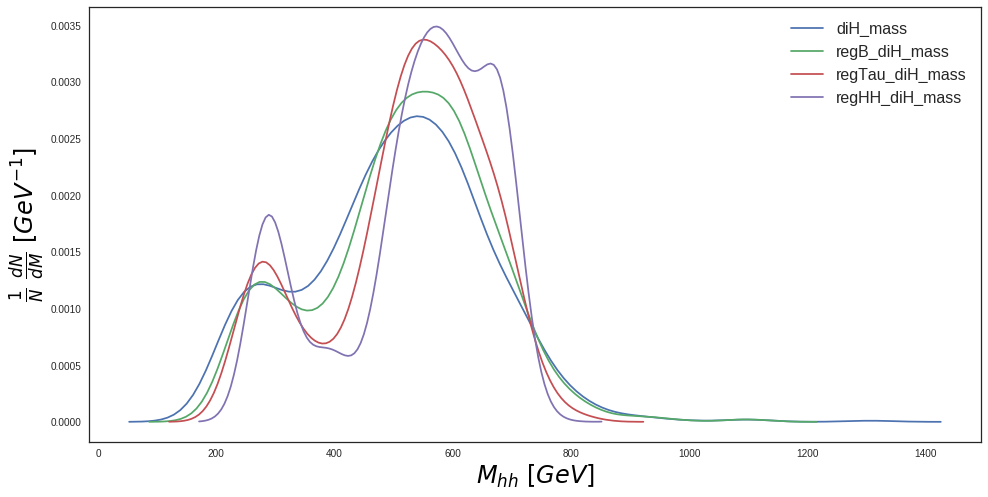

In [140]:
hist_params = {'shade' : False}
plt.figure(figsize=(16, 8))
sns.kdeplot(data=valData.loc[sig, 'diH_mass'])
sns.kdeplot(data=valData.loc[sig, 'regB_diH_mass'])
sns.kdeplot(data=valData.loc[sig, 'regTau_diH_mass'])
#sns.kdeplot(data=valData.loc[sig, 'gen_diH_mass'])
sns.kdeplot(data=valData.loc[sig, 'regHH_diH_mass'])
plt.legend(fontsize=16)
plt.xlabel(r'$M_{hh}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

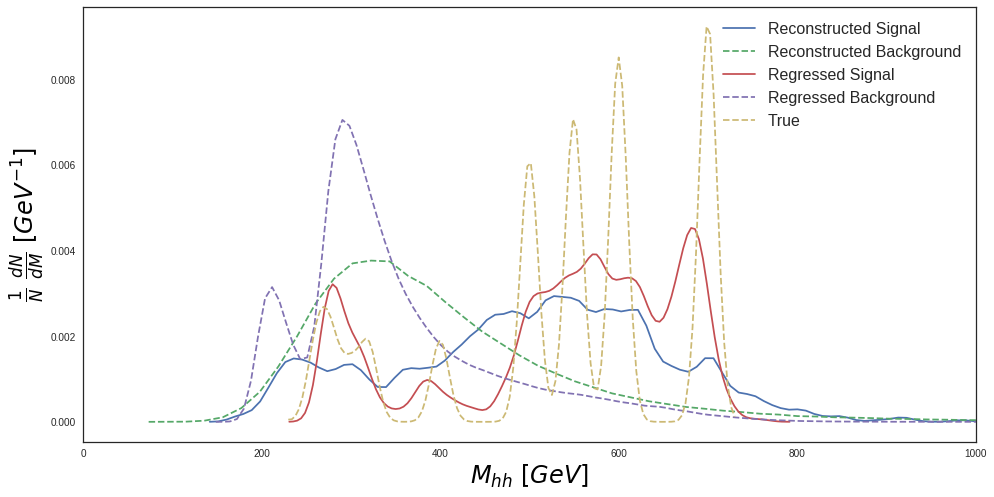

In [156]:
plt.figure(figsize=(16, 8))
sns.kdeplot(data=valData.loc[sig, 'diH_mass'], label = "Reconstructed Signal",bw = 10 , ls ='dashed', color = 'blue')
sns.kdeplot(data=valData.loc[bkg, 'diH_mass'],label = "Reconstructed Background",bw = 10,ls='dashed', color = 'green')
sns.kdeplot(data=valData.loc[sig, 'regHH_diH_mass'],label = "Regressed Signal",bw = 10 , color = 'blue')
sns.kdeplot(data=valData.loc[bkg, 'regHH_diH_mass'],label = "Regressed Background",bw = 5, color ='green')
sns.kdeplot(data=valData.loc[sig, 'gen_diH_mass'],label = "True", ls ='dashed',bw = 10, color = 'black')
plt.xlim(0,1000)
plt.legend(fontsize=16)
plt.xlabel(r'$M_{hh}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### Delta distribution

In [142]:
    """xPlot = np.linspace(-500, 500, 1data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA+IAAAHxCAYAAADpxwZXAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzs3XlUVdX7+PH3vQyCgICKQ5JoalhMn4vDcqCcBQ0NS80JMixN/ZSiOZQDknMOZfYzBYVyAj+aifYtMsg0EzUrBwwNUAwUcRZB5nt/fxBHryBcTQHhea3FWt6z99nnuftQi+fsffZW6XQ6HUIIIYQQQgghhKgQ6soOQAghhBBCCCGEqEkkERdCCCGEEEIIISqQJOJCCCGEEEIIIUQFkkRcCCGEEEIIIYSoQJKICyGEEEIIIYQQFci4sgOoLnJycoiLi8POzg4jI6PKDkcIIYQQQgghxCNUWFjI5cuXcXZ2xszM7F+1JYn4IxIXF8fw4cMrOwwhhBBCCCGEEI/Rpk2baNu27b9qQxLxR8TOzg4ouimNGjWq5GiEEEIIIYQQQjxKFy9eZPjw4Uru929IIv6IFE9Hb9SoEfb29pUcjRBCCCGEEEKIx+FRvIosi7UJIYQQQgghhBAVSBJxIYQQQgghhBCiAkkiLoQQQgghhBBCVCBJxIUQQgghhBBCiAokibgQQgghhBBCCFGBJBEXQgghhBBCCCEqkCTiQgghhBBCCCFEBZJEXAghhBBCCCGEqECSiAshhBBCCCGEEBVIEnEhhBBCCCGEEKICSSIuhBBCCCGEEEJUIEnEhRBCCCGEEEKICiSJuBBCCCGEEDWMr68vjo6Oej/Ozs54enoSFBTErVu3KjvEGuPQoUM4Ojpy5MiRMutFRkYybNgwOnTogJOTEx4eHsycOZMLFy4odbZv346joyMXL1583GGX4OjoyKpVqyr8uk8qScSFEEIIIYSogdq2bcv+/fuVn6ioKN59911++OEHJk2aVNnhPZSjR4/SvXv3CrlWcHAw06dPr5BrhYSEMGvWLPr27UtERARRUVHMmTOHX3/9lREjRpCVlQVA37592b9/Pw0aNKiQuMTDM67sAIQQQgghhBAVz8TEBDs7O71j9vb2qFQqAgICOHbsGG5ubpUU3cM5evRohV6rTp06FXKt0NBQBg0axIgRI5RjTz/9NE8//TTvv/8+p0+fxt3dHTMzM8zMzCokJvHvyIi4EEIIIYQQQvHss88CkJaWphz77bff8PPzo3379rRt25YJEyaQnp6ud973339P//79cXV1pXfv3oSFhemVR0VF4ePjg4uLC23btmXs2LEkJycr5dOnT2fo0KHs27ePfv364ebmhre3Nz///LNSJyUlhfHjx9OxY0dcXV3x9vZm27ZtAKxcuZKFCxdy/vx5HB0dWblyJampqTg6OrJt2zb69+9Pt27dAOjevTszZszQi2/27Nl6o+k5OTksWLCAzp07o9Fo8PX15fjx40DR1P6YmBi+/vprHB0dOXTokEH9pNPpWLZsGR06dOA///kPY8eO5erVq+Xek9zcXG7evFniuKOjI9u3b8fd3R0oOTX9xo0bTJgwAY1GQ4cOHVixYgVhYWE8//zzShvdu3fn448/Zt26dXTp0gWNRoOfnx9///23UufChQtMnDiR9u3b4+LigpeXF+Hh4eXGLe5PEnEhhBBCCCGEIiEhAYAmTZoAkJSUhL+/P9bW1mzcuJGQkBBSUlJ48803KSwsBCA2NpaAgAAGDBjArl27mDhxIsuXL2fTpk0A7N27lwkTJtCzZ08iIyMJDQ3l6tWrjBw5kuzsbOXaaWlpfPHFF8yfP5+vvvoKGxsbpkyZQm5uLgBTpkwhMzOTsLAwvvvuO4YOHcrMmTM5cuQI/v7++Pj40KhRI/bv34+/v7/SbmhoKO++++4DJY+BgYFER0ezdOlSvv76a+zt7fH39yc9PZ2VK1fi4OBAnz592L9/PxqNxqB+ioiIYO3atYwbN47IyEg8PT35+OOPy43Fw8ODXbt2MXv2bI4fP45WqzXoO8yZM4cDBw6wZMkSNm7cSGpqaql9EBUVRUpKCqGhoYSEhJCUlMT8+fOV8vfee4/k5GS++OILoqKiGDlyJEFBQezbt8/A3hT3kqnpQgghhBCixrlxKY6LyXt56pmeWNV7FpVK9cBthO46yS/Hzj+G6AzX2a0J/v2cHklbWq2WuLg4li1bhpubGy4uLgCsX78eCwsLli1bhqmpKQCLFi2iX79+7Nu3j27duhEWFka7du144403AHBwcCAtLU15d/nLL79Eo9Hw3//+V7ne4sWL8fLy4scff+Sll14C4OLFi4SHh9O4cWMAhg0bRkBAACkpKbRs2ZL4+HjeeecdWrduDcDw4cNxcXGhadOmWFhYUKtWLYyMjJQp99evXwfA3d2dnj17GtwXV65cYefOnSxcuJCOHTsCRSPmeXl5pKam0qZNG9RqNWZmZsq1DOmnyMhIOnXqhJ+fn9JPSUlJBAcHlxnPhx9+SEFBAVu2bGHLli1YWVnRrl07vLy8eOmllzA2LpnW3b59m+joaMaPH69890WLFtGnT59SrzF79mzU6qJx2l69evH9998rZUuWLMHExER593zIkCEEBwfzyy+/8OKLLxrcr+IOScSFEEIIIUSNk5t9jawbyST8vpanWnrR+JkelR1ShTt8+DAajUb5nJ+fD4CnpyczZ85Ujh8/fhx3d3cluYSi6es2NjbEx8fTrVs34uLiePnll/XaHzVqlPLvuLg4Xn31Vb3y5s2bY2VlxcmTJ5VEvH79+koSDlC3bl0AZVp2165d+eyzz7h69SpdunTB3d0dV1fXcr/r3VOxDXHy5Em0Wi1OTncecpibm7Ns2bL7nmNIPyUmJjJkyBC98wx5D9/GxoZVq1aRnJzMTz/9xMGDBzl48CA//vgjX375JWFhYVhbW+udk5aWRn5+vvKqAYCRkRGdOnXif//7n15dZ2dnJQmHon7PyMhQPufl5bFixQqOHDnCjRs30Ol0ZGdnlzpdXhhGEnEhhBBCCFHjFOTdVv596dzPNHR4AbWRaRlnlOTfz+mRjUZXBldXVxYvXqx8DgkJISYmhlmzZmFjY6Mcz8zMZM+ePXpJO0B2djZXrlwBICMjg9q1a9/3WpmZmVhYWJQ4bmFhQWZmpvLZ3Nxcr7x4poJOpwOKRtE3bNjArl27CA0NxdLSEj8/P9555x29RLK06zyI4iT03njKYkg/ZWVllVhM7UFia9asGSNHjlSm9K9fv57ly5cTGhpKQECAXt0bN24AYGVlpXf83oQdKBGTSqVS+jwzMxNfX1/q1KnDrFmzaNq0KcbGxnoPWsSDk0RcCCGEEELUOIX5RYm4TQMnblw6yZXzv9KgaedKjqpimZmZ4eDgoHyeMmUK0dHRfPTRRyxYsEA5bmVlhYeHBx988EGJNiwtLQGwtbXVS6jvZWVlVWp5ZmZmiUSxvJjfeust3nrrLdLT09myZQuff/45DRo0YOjQoQa3A3eS+2K3b995OFM8El/Wd7qXIf1kbm5OTk6OXtndI8/3k5GRUWKFdnNzc8aMGUNUVBSnT58ucU6tWrUAlPfrixUn6IY6fPgwly9f5tNPP1UWhXuYdoQ+WaxNCCGEEELUOAUFRUlX4xa9UamNSU/ei05bWMlRVS5ra2smTZrE9u3bOXLkiHLcxcWF5ORkmjZtioODg/KTn5+vJKxOTk78/vvveu2tXr1aWZnc2dm5RHlCQgKZmZnKu+jluXnzJpGRkcrCZw0bNuTdd9+lVatWJCYmKvXuTbBLY2lpqZcAa7VaTpw4oXx+9tlnMTEx0Ys5Pz8fPz8/du/eXeq1DOmn5s2b610H4MCBA2XGGh0dTbt27Urdmi0vL4+LFy/SsGHDEmVNmzZFpVJx8uRJvfo//fRTmde7V/ErC7a2tsqxPXv2cOvWLYP6WpROEnEhhBBCCFHjFE9NN7NoQP0m7cnLuc619GOVHFXlGzhwIE5OTgQGBpKXlwcUbdV14cIFZs+ezenTpzlz5gxLly7Fx8dHSYBHjhzJiRMn+Oyzz0hNTSUqKorVq1cr7yePGjWK48ePs3z5cpKTk/ntt9+YNm0azZo109syrCw6nY45c+YQFBREQkICFy5cIDIykrNnz9KuXTug6GHC5cuXOXLkCCkpKfdty8nJiV9++YUDBw5w5swZ5s2bp7dgn52dHd7e3qxcuZLY2FjOnTvH3LlzOXnypPLgwNramj///JP4+HiuXLliUD95e3tz+PBhNm3axLlz59i6dSuxsbFlfu8XX3wRNzc3xo8fT0REBH/99Repqan88ssvjBkzhry8PGXxt7vVqVOHzp07s379en7++WcSExN5//33H3iavpOTE0ZGRnzxxRekpKTw3XffsXr1atq0aUNCQoKyVZp4MJKICyGEEEKIGsfC+mms6z+HWm1MQ4cuoFKTnvxTZYdV6dRqNYGBgSQlJbF27VoAWrZsSVhYGGfOnGHw4MH4+Pjwxx9/sG7dOlq1agVAhw4dWLJkCd9++y1eXl4sW7aM8ePHKwlip06dWLFiBT/99BPe3t6MHTsWBwcHvvzyS73FzcpiY2PD2rVrOXv2LEOGDKFPnz6sXbuWadOm4eXlBcCAAQNo0qQJI0eOZP369fdta+LEiWg0GsaPH4+vry92dnbKgnHFZs+eTe/evZk0aRI+Pj4kJCSwbt06ZTE5f39/Ll26xNChQ/n1118N6ic/Pz98fX1ZsWIFL7/8MjExMXoL45XG1NSUsLAwhg8fTnh4OMOHD8fLy4sZM2bQoEEDtm7dSosWLUo9d/78+bRu3Zrx48czatQonJ2d6d27tzJt3RD29vYEBQWxd+9e+vXrx//+9z+WLl3KiBEjOHv2LOPHjze4LXGHSifzCR6J1NRUevToQUxMDPb29pUdjhBCCCGEeACZN86hUqmxsH66skMR4pHJzc0lOztbb/G9gIAAEhMT2bVrVyVG9mR6lDmfjIgLIYQQQogaz9LGQZJwUe1MnToVHx8fYmNjSU1NZfv27ezevbvEVnKi4smq6UIIIYQQokbRaQs5n/gdta2aULfxna2miieK3v2usBBPsnnz5rF48WKmTJlCRkYGTz31FAEBAfj6+lZ2aDWeJOJCCCGEEKJGKci/TXryXmwauiqJeOrpXaSf+5nnOk6kttVTlRyhEI+GlZUV8+bNq+wwRClkaroQQgghhKhRCv7ZQ9zYxFw5plIbAzoKC3Luc5YQQjw6kogLIYQQQogapVBJxO9s42RkbAaAtiC3UmISQtQskogLIYQQQogapXhE3OiuEfHiRFxGxIUQFUEScSGEEEIIUaPcmZpeWzl2JxHPrpSYhBA1iyTiQgghhBCiRtHpClEb1bpPIi4j4kKIx09WTRdCCCGEEDWKnX0H7Ow7KNuVAZhZNKBxi15Y2jSvxMiEEDWFJOJCCCGEEKJGunu/8Fq16/FUi96VGI0QoiaRqelCCCGEEKJGybr5N7eunUGnLazsUCqNr68vjo6Oej/Ozs54enoSFBTErVu3KjvEGuPQoUM4Ojpy5MiR+9a5915pNBpeeukl1qxZQ35+/iONZ/r06fTq1euRtlkVGNLPFUlGxIUQQgghRI1yPuE7bl1LRNNzIcVj4trCfM4c24C5VSOatOpbqfFVlLZt2/LJJ58on3Nzczl27BgLFy4kNTWVkJCQSozu4Rw9epRJkybx448/PvZrBQcHc+bMGRYtWvTYrwXw1ltv8frrrwOQmZnJ/v37WbRoETdu3GDatGkVEoN4dCQRF0IIIYQQNUpB/m3URrVQq+/8KaxSG3HzyqkatVibiYkJdnZ2esfs7e1RqVQEBARw7Ngx3NzcKim6h3P06NEKvVadOnUq7Hq1a9dW7pednR3Nmzfn0KFD7N27VxLxJ5BMTRdCCCGEEDVKQf5tvRXTAVQqNWrjWjUqEb+fZ599FoC0tDTl2G+//Yafnx/t27enbdu2TJgwgfT0dL3zvv/+e/r374+rqyu9e/cmLCxMrzwqKgofHx9cXFxo27YtY8eOJTk5WSmfPn06Q4cOZd++ffTr1w83Nze8vb35+eeflTopKSmMHz+ejh074urqire3N9u2bQNg5cqVLFy4kPPnz+Po6MjKlStJTU3F0dGRbdu20b9/f7p16wZA9+7dmTFjhl58s2fPpnv37srnnJwcFixYQOfOndFoNPj6+nL8+HGgaGp/TEwMX3/9NY6Ojhw6dMigftLpdCxbtowOHTrwn//8h7Fjx3L16tUHu0F30Wq1eg8DdDoda9asoWfPnjg5OeHh4cG0adO4fv263nmbN2/G09MTV1dX+vXrR2Rk5H2vkZWVxcsvv4yvry95eXnodDqWL19Ox44d0Wg0TJgwgYMHD+pN+y6+l6tXr0aj0bB161YA4uPjGTVqFBqNBldXVwYPHqx3f1euXMnzzz+vd/2jR4/q9fHKlSt58cUXOXHiBIMHD8bNzY1evXqxY8cOvX54lP38OEgiLoQQQgghapTC/NsY3ZOIQ9EWZpKIQ0JCAgBNmjQBICkpCX9/f6ytrdm4cSMhISGkpKTw5ptvUlhY9J59bGwsAQEBDBgwgF27djFx4kSWL1/Opk2bANi7dy8TJkygZ8+eREZGEhoaytWrVxk5ciTZ2Xf2bk9LS+OLL75g/vz5fPXVV9jY2DBlyhRyc3MBmDJlCpmZmYSFhfHdd98xdOhQZs6cyZEjR/D398fHx4dGjRqxf/9+/P39lXZDQ0N59913CQ8PN7gfAgMDiY6OZunSpXz99dfY29vj7+9Peno6K1euxMHBgT59+rB//340Go1B/RQREcHatWsZN24ckZGReHp68vHHHz/wPcrLy+Pbb79l3759jBw5Ujm+bds2PvnkEyZNmkR0dDSffvopR48e5cMPP1TqfPXVVyxatIi3336bb775htdee41p06bx008/lbiOVqtl8uTJaLVaVq1ahampKeHh4QQHBzNq1Ci++uorXFxcmDNnTolz09PTOXHiBDt37qRPnz5cunQJPz8/zMzM2Lx5M19//TWtWrXi7bffJj4+/oG+f3Z2Nh999BHvvfcekZGRPP/888ycOVN56PGo+vlxkqnpQgghhBCixtBqC9AW5pUYEYeiRDw/5+YDtTd+14xSj/dr3QuvVl0BWHkwjFOXE0vUaVWvORM7vQlAdNJ+vv7zu1LbWtE3CGMjY85nXGTB3pV6Zf+v3/wHircsWq2WuLg4li1bhpubGy4uLgCsX78eCwsLli1bhqmpKQCLFi2iX79+7Nu3j27duhEWFka7du144403AHBwcCAtLY2srCwAvvzySzQaDf/973+V6y1evBgvLy9+/PFHXnrpJQAuXrxIeHg4jRs3BmDYsGEEBASQkpJCy5YtiY+P55133qF169YADB8+HBcXF5o2bYqFhQW1atXCyMhImcJdPBLs7u5Oz549De6LK1eusHPnThYuXEjHjh2BohHzvLw8UlNTadOmDWq1GjMzM+VahvRTZGQknTp1ws/PT+mnpKQkgoODy41p1apVynv7OTk5qFQqxo0bh6enp1LH09MTd3d3WrRoAUDjxo3x9vZmw4YNSp3Q0FC8vb0ZMGAAACNGjCAtLY3Lly+XuObChQuJj49ny5YtWFlZAbBz5046duzIm28W/e4+88wzJCUlcfbsWb1zL1y4wObNm2nUqBEAGzduJDc3l8WLF2NpaQnA3Llz2b9/P+Hh4XoPC8qTkZHBxIkTadOmDQCjRo0iKiqKU6dO0bBhw3/VzxVFEnEhhBBCCFFjFObfBrhvIp5TeAmdTqe3tVl1dfjwYTQajfK5ePVtT09PZs6cqRw/fvw47u7uSnIJRdPXbWxsiI+Pp1u3bsTFxfHyyy/rtT9q1Cjl33Fxcbz66qt65c2bN8fKyoqTJ08qiXj9+vWVJBygbt26ANy8WfSApGvXrnz22WdcvXqVLl264O7ujqura7nf9d7pzuU5efIkWq0WJycn5Zi5uTnLli277zmG9FNiYiJDhgzRO8/Q9/CHDx/OsGHDgKIR8YSEBFasWEFcXByff/45KpUKMzMzoqOjCQgI4OLFi+Tn5ys/UJTAJyYmKu0UmzJlSonrbd68mW3btrFlyxYlmYai1wO8vb316r7wwgts375d71jdunX1zouLi6Nly5ZKEg6gVqtxcnLizz//NKgP7lb8oAjA1tYWuPN78m/6uaJIIi6EEEIIIWoMYxMLnusYgFptUqLMwvpp1GoTdLpCVCrD/kw2ZET6nQ5vlFunZwsPerbwKLNOkzqNHukIuKurK4sXL1Y+h4SEEBMTw6xZs7CxsVGOZ2ZmsmfPHr2kHYqmB1+5cgUoGqGsXbvkw42727CwsChx3MLCgszMTOWzubm5XnnxAxGdTgcUjaJv2LCBXbt2ERoaiqWlJX5+frzzzjuo1fd/67a0a5clIyOj1HjKYkg/ZWVlYWZm9lCxWVtb4+DgoHxu1aoVTZs25dVXX2Xfvn106dKFRYsWsWXLFiZPnkynTp0wNzcnIiKC0NBQ4E6iWt73unTpEgsWLECr1ZbYyu7GjRvK6Hixu39f7ve9MjMz9ZLwu+vd/TtgCCMjI70HHvf+nvybfq4okogLIYQQQogaQ6U2orbVU6WWPe3Yv4KjqVxmZmZ6id2UKVOIjo7mo48+YsGCBcpxKysrPDw8+OCDD0q0UZxY2dralplMWVlZlVqemZlZIqkrL+a33nqLt956i/T0dLZs2cLnn39OgwYNGDp0qMHtwJ2krdjt27eVfxePxD9IgmhIP5mbm5OTo78OQXHS/zAcHR1RqVScPn2aLl268H//93+88soreu/H373PuK2tLSqVyqDvFRISwsaNG5k6dSqRkZHKdzA1NVXe2S9248aNctuzsrLi/PnzJY7funVL+R1QqVRl3hdDPep+fhxksTYhhBBCCFFjaLUF6LSFlR1GlWRtbc2kSZPYvn27svo1FE0BTk5OpmnTpjg4OCg/+fn5SsLq5OTE77//rtfe6tWrlZXJnZ2dS5QnJCSQmZmpN8W4LDdv3iQyMlJZ+Kxhw4a8++67tGrVisTEO+/g35vIlcbS0lIvMdNqtZw4cUL5/Oyzz2JiYqIXc35+Pn5+fuzevbvUaxnST82bN9e7DsCBAwcM+v6lOXPmDDqdjoYNGwJFU9aLp2lD0d7wxfHqdDpMTU1p1apViXsxb948vT3lGzRoQMeOHZk7dy45OTnMnTtXKWvWrBknT57UO//uPrkfZ2dnEhIS9Pq9oKCAuLg45XfA0tISrVar96Dg2LFj5bZ9r0fdz4+DJOJCCCGEEKLGuJb2O79HT+fqhd9KlGXeOMfFsz+Sl329lDNrhoEDB+Lk5ERgYCB5eXlA0VZdFy5cYPbs2Zw+fZozZ86wdOlSfHx8lAR45MiRnDhxgs8++4zU1FSioqJYvXq1shXaqFGjOH78OMuXLyc5OZnffvuNadOm0axZM70tw8qi0+mYM2cOQUFBJCQkcOHCBSIjIzl79izt2rUDih4mXL58mSNHjpCSknLftpycnPjll184cOAAZ86cYd68eXrrAtjZ2eHt7c3KlSuJjY3l3LlzzJ07l5MnTypJo7W1NX/++Sfx8fFcuXLFoH7y9vbm8OHDbNq0iXPnzrF161ZiY2MN+v63b9/m8uXLXL58mYsXLxIbG8vUqVNp3bo1vXv3Boreg/7uu++Ij4/n5MmTjB49ms6dOwNFawLk5ubyxhtv8P333xMREUFqaioRERFs3rwZZ2fnEtesW7cu8+bNY8eOHURFRQHg5eVFbGws4eHhJCcnExISovcg5H4GDhxI7dq1mTx5MqdOneKvv/7i/fffJyMjg+HDhyv3BeDzzz8nJSWFb7/9lpiYGIP6527/pp8riiTiQgghhBBV1I1Lf5Kf+2DvToqyFeQVTXM1Mi75juyta4mcT/iO7KxLFR1WlaFWqwkMDCQpKYm1a9cC0LJlS8LCwjhz5gyDBw/Gx8eHP/74g3Xr1tGqVSsAOnTowJIlS/j222/x8vJi2bJljB8/Xlm1ulOnTqxYsYKffvoJb29vxo4di4ODA19++aXeu75lsbGxYe3atZw9e5YhQ4bQp08f1q5dy7Rp0/Dy8gJgwIABNGnShJEjR7J+/fr7tjVx4kQ0Gg3jx4/H19cXOzs7ZcG4YrNnz6Z3795MmjQJHx8fEhISWLdunbKYnL+/P5cuXWLo0KH8+uuvBvWTn58fvr6+rFixgpdffpmYmBi9hfHKEhISgoeHBx4eHvTo0YMZM2bQtm1b1q1bp7zzPXv2bOrVq8eQIUMICAhg4MCBTJ06lWeeeYYxY8bw119/8corrzBt2jRCQkLo06cPGzZsYN68efddVb5bt2689tprBAYGkp6ejr+/P4MGDWLp0qUMHjyY5ORkJk2aBECtWrXuG3+9evX48ssvKSgoYMiQIQwaNIi0tDTCwsKUVd7btWvHuHHj2LFjB/369WPHjh0G98/d/k0/VxSVzpC5G6Jcqamp9OjRg5iYGOzt7Ss7HCGEEEI84TKvn+X0r6sws2iIU+f3KjucauN8wrdcPLsHx3bjsLRtrld26e9fSDm1g+auI6jbqGqtsCxEVVFYWMj169epX7++ciw8PJw5c+Zw8OBBvanx1c2jzPlkRFwIIYQQogrKuV20ynJOVnolR1K9FI+IG5uWXEHZyLholeXCgpwSZUKIIhEREXTp0oXt27dz/vx5Dhw4QHBwMD169KjWSfijJqumCyGEEEJUQQV5MiX9cSjIL56aXvo+4gBaScSFuK9hw4aRlZXF6tWrCQwMpH79+rzwwgvK9HRhGEnEhRBCCCGqIEubZgDUriOvvD1Khf8k4sYmJd8RlxFxIcqnUqkYPXo0o0ePruxQnmiSiAshhBBCVEGWts1p03tJZYdR7dg93Yk69R1RqY1KlCmJeGFeRYclhKhhJBEXQgghhBA1hm0j1/uWmVs1RtNzIWq1/IkshHi85P8yQgghhBBVjE5byOlfV2FqXhdzy0bUqfcsFtZPV3ZY1Z5KpUalkrWMhRCPnyTiQgghhBBVTF7uTbJu/k121iWuXzyKSqXk7LI+AAAgAElEQVSWRPwR0Bbmc/rXz6lTrxVNWvUptU72rTRAhblVo4oNTghRo8gjPyGEEEKIKib39lUA6tRtAUBezvXKDKfaKMi/ze2MFHKzr923zqlDK0mOi6jAqIQQNZEk4kIIIYQQVUxxomhl2/Kfz5KIPwp3VkwvuXVZMSMTc1k1XQjx2EkiLoQQQghRxeRlF42Im9d5CiNjc/IkEX8kCgxIxNVGtSQRF0I8dpKICyGEEEJUMbm3i0bEa5nXw9Tclrzsa+h0ukqO6slXnIgblTUibmxGYUFOte9vX19fHB0d9X6cnZ3x9PQkKCiIW7duVXaIle7QoUM4Ojpy5MiRMutFRkYybNgwOnTogJOTEx4eHsycOZMLFy4odbZv346joyMXL1583GGX4OjoyKpVqyr8uqJsslibEEIIIUQVY27ViIL825jUssLUzJa8nBsUFuRgbGJe2aE90QwZETcyMUOnK0SnLUBlZFJRoVWKtm3b8sknnyifc3NzOXbsGAsXLiQ1NZWQkJBKjO7JEBISwsqVK5k6dSoeHh4YGRlx+vRplixZwogRI9i1axcWFhb07duXF154gXr16lV2yKKKkERcCCGEEKKKafxMTxo/U/TvFm6+qNRGlRtQNWFSywrr+s9Rq/b9kyEj46KHHYUFOaireSJuYmKCnZ2d3jF7e3tUKhUBAQEcO3YMNze3SoruyRAaGsqgQYMYMWKEcuzpp5/m6aef5v333+f06dO4u7tjZmaGmZlZJUYqqhqZmi6EEEIIUYVJEv7o2Ng9T0t3fyxtmt23TuPm3Xm27RiMjGtu0vTss88CkJaWphz77bff8PPzo3379rRt25YJEyaQnp6ulOt0OpYvX07Hjh3RaDRMmDCBgwcP6k3tnj59OkOHDmX16tVoNBq2bt0KQGJiImPGjKFTp05oNBpGjRpFUlKS0nZOTg7z5s2jS5cuODs707VrVxYvXkxBQYFB5YbGv2zZMjp06MB//vMfxo4dy9WrV8vtq9zcXG7evFniuKOjI9u3b8fd3R0oOTX9xo0bTJgwAY1GQ4cOHVixYgVhYWE8//zzShvdu3fn448/Zt26dXTp0gWNRoOfnx9///23UufChQtMnDiR9u3b4+LigpeXF+Hh4eXGLSqfJOJCCCGEEFVIzu0rpJyK5Na1okSksCCXW9cSyb5V8e+W1kS16zTBqm7Laj8aXpaEhAQAmjRpAkBSUhL+/v5YW1uzceNGQkJCSElJ4c0336SwsBCA8PBwgoODGTVqFF999RUuLi7MmTOnRNvp6emcOHGCnTt30qdPH65du4avry9ZWVmsWbOGzZs3A/D6668r76mvWrWK3bt3s2TJEnbv3k1QUBCRkZEEBwcbVG5I/BEREaxdu5Zx48YRGRmJp6cnH3/8cbl95eHhwa5du5g9ezbHjx9Hq9Ua1Mdz5szhwIEDLFmyhI0bN5KamlpqAh0VFUVKSgqhoaGEhISQlJTE/PnzlfL33nuP5ORkvvjiC6Kiohg5ciRBQUHs27fPoDhE5ZGp6UIIIYQQVUh2xgUu/b0fU/O6WNVtQe7tK/x1ZA12T3em6XM+lR3eE+3K+cPk59ykYfNuqNX//s/gs2FfcvVA7COI7OHV69SR5m+8/kja0mq1xMXFsWzZMtzc3HBxcQFg/fr1WFhYsGzZMkxNTQFYtGgR/fr1Y9++fXTr1o2dO3fSsWNH3nzzTQCeeeYZkpKSOHv2rN41Lly4wObNm2nUqBEAwcHB3Lp1ixUrVijvTy9ZsoSuXbsSGRnJiBEjiI+Pp3Xr1rRv3x6Ap556ig0bNlCrVi2AcssNiT8yMpJOnTrh5+cHgIODA0lJSUoyfz8ffvghBQUFbNmyhS1btmBlZUW7du3w8vLipZdewti45O/Z7du3iY6OZvz48fTs2VOJp0+fPqVeY/bs2ajVReOnvXr14vvvv1fKlixZgomJCQ0aNABgyJAhBAcH88svv/Diiy+WGbuoXDIiLoQQQghRheT+s3VZLfO6AJia2wKQ98/e4uLhXb3wGxeSdqNS3f9P4Cuph/kjZibX009UYGSV4/Dhw2g0GuXH1dWVYcOG4ebmxpo1a5R6x48fx93dXUlioWj6uo2NDfHx8QCkpKQoU9qLvfDCCyWuWbduXSUJL267VatWeouY1a1bl5YtWyptd+3alb179zJp0iR++OEHMjIyaNGiBfb29gaVGxJ/YmIizz33nF6shrwfb2Njw6pVq/j+++95//33adu2LQcPHmTq1KkMHjy41GnraWlp5Ofn6/WXkZERnTp1KlHX2dlZScKL+yYjI0P5nJeXx9KlS+nevTvu7u5oNBouXLhQ6nVF1SIj4kIIIYQQVUhu9p2ty6Bo8TC1US3ycmQv8X+rMD8btbFZmYk4KhXawlyD9hJv/sbrj2w0ujK4urqyePFi5XNISAgxMTHMmjULGxsb5XhmZiZ79uxBo9HonZ+dnc2VK1eAoneerays9MrvbqOYhYWF3ufMzExOnTpVou3c3FxlIbnhw4dja2tLREQEAQEB6HQ6evfuTWBgIDY2NuWWGxJ/VlZWicXU7o21LM2aNWPkyJGMHDmS7Oxs1q9fz/LlywkNDSUgIECv7o0bNwBK9Je1tXWJdu+NSaVSKVvrZWZm4uvrS506dZg1axZNmzbF2NiYUaNGGRy3qDzVLhFfsGABx44dQ6VS8cEHH+Dq6qqUHThwgOXLl2NkZMSLL77I+PHj73vOr7/+yvLlyzE2NqZ27dp89NFHpf7HIYQQQgjxKBWPiJv+MyKuUqmoZW5LbvZ1dDodKpWqMsN7omkL8zAyMi2zTvEibYYk4k86MzMzHBwclM9TpkwhOjqajz76iAULFijHrays8PDw4IMPPijRhqWlJQCmpqbk5ubqlRUnnGWxsrLC0dGRFStWlBpfsb59+9K3b18yMzP54YcfWLRoEUFBQcp73GWVGxK/ubk5OTn69/zukef7ycjIoE6dOnrHzM3NGTNmDFFRUZw+fbrEOcVT5h+mv+52+PBhLl++zKeffqosCvcw7YjKUa2mph8+fJhz586xZcsW5s+fr7eQAcC8efNYuXIl4eHh/PLLLyQmJt73nIULFzJ//nw2bNiARqNhy5YtlfGVhBBCCFHD5N2+hrGpJUbGdxJGUzPbf0ZpsysxsiefVpuP2uBEvOb1tbW1NZMmTWL79u3KSucALi4uJCcn07RpUxwcHJSf/Px86tYtemDUrFkzTp48qdfe7t27y72mi4sLqamp2NnZ6bVdUFBAvXr10Gq1/PDDD8oK7paWlgwYMIB+/fqRmJhYbrmh8Tdv3pwTJ/RfRzhw4ECZsUdHR9OuXTuOHj1aoiwvL4+LFy/SsGHDEmVNmzZFpVLp9VdeXh4//fRTuf11t/z8fABsbW2VY3v27OHWrVvKqLmouqpVIh4bG6sseNCiRQtu3rxJZmYmUPTeirW1NY0bN0atVtOlSxdiY2Pve46tra3yNOnmzZt6v+BCCCGEEI+DTqdDbWSKuYX+H+/Fo+N52TI9/d8oLMwrdzX0mjQiXpqBAwfi5OREYGAgeXl5APj6+nLhwgVmz57N6dOnOXPmDEuXLsXHx0dJdr28vIiNjSU8PJzk5GRCQkKUsrK8+uqrGBkZMXnyZOLi4vj7778JDQ2lf//+HDx4ELVazdq1a3nvvff4448/SEtL4/Dhw+zZs4d27dqVW25o/N7e3hw+fJhNmzZx7tw5tm7dSmxs2Qvxvfjii7i5uTF+/HgiIiL466+/SE1N5ZdffmHMmDHk5eUpi7/drU6dOnTu3Jn169fz888/k5iYyPvvv/9AU+EBnJycMDIy4osvviAlJYXvvvuO1atX06ZNGxISEpSt0kTVVK0S8StXruglzHXr1uXy5csAXL58WXnidXfZ/c754IMPGD9+PJ6envz2228MGDCg4r6IEEIIIWoklUrF850m8Wy7t/WON2zWBafOUzG3bHSfM4UhVCo1RkZl7w9+JxHPLbNedaVWqwkMDCQpKYm1a9cC0LJlS8LCwjhz5gyDBw/Gx8eHP/74g3Xr1tGqVSsA/P39GTRoEEuXLmXw4MEkJyczadIk4M5U7NLUq1ePjRs3UlBQgK+vL3379uWbb75h+fLleHh4APDpp59iZ2fH2LFj6dWrF9OnT6d79+5MmTLFoHJD4vfz88PX15cVK1bw8ssvExMTw8yZM8vsK1NTU8LCwhg+fDjh4eEMHz4cLy8vZsyYQYMGDdi6dSstWrQo9dz58+fTunVrxo8fz6hRo3B2dqZ3795l9tW97O3tCQoKYu/evfTr14///e9/LF26lBEjRnD27FnlNVxRNal01WjewqxZs+jSpYsywj106FAWLFhA8+bN+f3331m3bh3/7//9PwC2bt1KSkoK169fL/WcoKAg3nnnHdq0acPixYtp3LhxqU+0iqWmptKjRw9iYmKUFRqFEEIIIcSTpTA/m7QzMVjYNMW2oWv5JwgACgsLuX79OvXr11eOhYeHM2fOHA4ePCizS++Rm5tLdna23oJ2AQEBJCYmsmvXrkqMTJTlUeZ81WpEvEGDBsrKhwCXLl1SVlu8tyw9PZ0GDRrc95zTp0/Tpk0bADp16kRcXFwFfQshhBBC1FS3M85z7eJR8vMyS5RpC/NKPS4eLSMTc+wdvSUJf0ARERF06dKF7du3c/78eQ4cOEBwcDA9evSQJLwUU6dOxcfHh9jYWFJTU9m+fTu7d+/m1VdfrezQRAWpVol4586dlQ3uT548SYMGDZSVEO3t7cnMzCQ1NZWCggL27NlD586d73tO/fr1lXdGTpw4obeipBBCCCHE43Dt4jHOHt9ETtYlveMFeVn8ETODcye3VVJkTz5tYT4ZVxPJuX2l/MrigQ0bNowJEyawevVqZXr2Cy+8oLf6urhj3rx5eHh4MGXKFPr27UtwcDABAQH4+vpWdmiiglSr7cvc3d1xcnJiyJAhqFQqAgMD2b59O1ZWVvTq1Ys5c+YwefJkoGiLg+bNm9O8efMS5wAEBQUxc+ZMTExMsLa2lv+JCCGEEOKxy1P2EK+rd9zIpDZqtQl5OdcqI6xqIS/nBgm/raF+k/Y4OA0qs+65P78CnQ4Hp4EVFN2TT6VSMXr0aEaPHl3ZoTwRrKysmDdvXmWHISpRtUrEAd577z29z61bt1b+3a5du1K3Ibv3HChK6iMiIh59gEIIIYQQ91FQcBsAY1NLveMqlQpT87rkZcv+wA9LW1i0Anh525cB3LqWqNQXQojHoVpNTRdCCCGEeJJpC3JRqYxQq0uOlZia21JYkE1hfs3b3/pR0GqL9lw2JBE3MjaTfhZCPFaSiAshhBBCVBGFBbmojUvfvsjYpGiP4QJJEB/KnRHxsvcRh6JEXKvNR6ctfNxhCSFqKEnEhRBCCCGqCG1hLkZGpSfiRv8k6NrCmrm/9b/1IFPTi/u6sCDnscYkhKi5qt074kIIIYQQT6rWHSag0xaUWla3sYbadewxqVWngqOqHrSF/0xNVxs2Ig5FibixqcVjjUsIUTNJIi6EEEIIUUWY3LNI290sbZphadOs4oKpZurUexbH9uNLrEhfGjOLBlhYOwC6xx+YEKJGkkRcCCGEEKIK0Om05OdmYGRspozIikfH2NQCSwNHtxs1706j5t0fc0RCiJpM3hEXQgghhKgCCvOzObFvPslxJbdaBbhx+U9OHljG9YvHKziy6kGnk9Htu/n6+uLo6Kj34+zsjKenJ0FBQdy6dauyQ6x0hw4dwtHRkSNHjty3zr19qNFoeOmll1izZg35+fmPNJ7p06fTq1evR9pmVWBIP1dHMiIuhBBCCFEFFBYULcJmdJ9V03WF+eRkXiQ/L6Miw6o2LiR+T3ryTzzb7u1yp/jn3L5CxpXTWNk+g7lV44oJsBK0bduWTz75RPmcm5vLsWPHWLhwIampqYSEhFRidE+Ot956i9dffx2AzMxM9u/fz6JFi7hx4wbTpk2r5OhEVSWJuBBCCCFEFVBYWLRCt9qo9GnpamUl77wKi6k60RbmodMVlrpH+72yM86TcmoHT7f2qdaJuImJCXZ2dnrH7O3tUalUBAQEcOzYMdzc3CopuidH7dq1lX60s7OjefPmHDp0iL1790oiLu5LpqYLIYQQQlQB2nJGxIu3NZPtyx6OVmv49mXqu1ZNr4meffZZANLS0pRjv/32G35+frRv3562bdsyYcIE0tPTlXKdTsfy5cvp2LEjGo2GCRMmcPDgQb0px9OnT2fo0KGsXr0ajUbD1q1bAUhMTGTMmDF06tQJjUbDqFGjSEpKUtrOyclh3rx5dOnSBWdnZ7p27crixYspKCgwqNzQ+JctW0aHDh34z3/+w9ixY7l69epD96FWq6VOnTs7HOh0OtasWUPPnj1xcnLCw8ODadOmcf36db3zNm/ejKenJ66urvTr14/IyMj7XiMrK4uXX34ZX19f8vLy/tU9iI+PZ9SoUWg0GlxdXRk8eDA///yzcq2VK1fy/PPP613/6NGjODo6cujQIaXOiy++yIkTJxg8eDBubm706tWLHTt26PXDo+znJ5kk4kIIIYQQVUDhPwn2/RJFZURcEvGH8kD7iP9Tp/icmiYhIQGAJk2aAJCUlIS/vz/W1tZs3LiRkJAQUlJSePPNNyksLAQgPDyc4OBgRo0axVdffYWLiwtz5swp0XZ6ejonTpxg586d9OnTh2vXruHr60tWVhZr1qxh8+bNALz++uvKe+qrVq1i9+7dLFmyhN27dxMUFERkZCTBwcEGlRsSf0REBGvXrmXcuHFERkbi6enJxx9//MB9l5eXx7fffsu+ffsYOXKkcnzbtm188sknTJo0iejoaD799FOOHj3Khx9+qNT56quvWLRoEW+//TbffPMNr732GtOmTeOnn34qcR2tVsvkyZPRarWsWrUKU1PTh74Hly5dws/PDzMzMzZv3szXX39Nq1atePvtt4mPj3+g75+dnc1HH33Ee++9R2RkJM8//zwzZ85UHno8qn6uDmRquhBCCCFEFWDwiHiBJOIPQ9lH3JARcSMTvXPKsmJedKnHO3VtQTuP5gB8vfl3/j5zrUQdewdbXvVtA8DvB8/xc3RCqW39d3p3jIzVXEm/xaaQQ3plE2b2LDdGQ2m1WuLi4li2bBlubm64uLgAsH79eiwsLFi2bBmmpkX9t2jRIvr168e+ffvo1q0bO3fupGPHjrz55psAPPPMMyQlJXH27Fm9a1y4cIHNmzfTqFEjAIKDg7l16xYrVqygXr16ACxZsoSuXbsSGRnJiBEjiI+Pp3Xr1rRv3x6Ap556ig0bNlCrVtF/E+WVGxJ/ZGQknTp1ws/PDwAHBweSkpKUZL4sq1atUt6nz8nJQaVSMW7cODw9PZU6np6euLu706JFCwAaN26Mt7c3GzZsUOqEhobi7e3NgAEDABgxYgRpaWlcvny5xDUXLlxIfHw8W7ZswcrKCuCh78HGjRvJzc1l8eLFWFoWbaE4d+5c9u/fT3h4uN7DgvJkZGQwceJE2rQp+r0eNWoUUVFRnDp1ioYNG/6rfq5uZERcCCGEEKIKqG39NM2cXsOqbqtSy41MamPb0JXadZ6u4MiqB2VEXG1Sbt3iZL14Ont1dfjwYTQajfLj6urKsGHDcHNzY82aNUq948eP4+7uriSxUDR93cbGRhkxTUlJUaa0F3vhhRdKXLNu3bpKAljcdqtWrZQkvLhOy5Ytlba7du3K3r17mTRpEj/88AMZGRm0aNECe3t7g8oNiT8xMZHnnntOL1ZD348fPnw4O3bsYMeOHezcuZOlS5eya9cuxo4dq6zWb2ZmRnR0NP3796d9+/ZoNBrWrFnDzZs3gaIEPjExEScnJ722p0yZwqBBg/SObd68mW3bthESEqLXlw97D+Li4mjZsqWShAOo1WqcnJz4888/DeqDuxU/wAGwtbUFUL7nv+nn6kZGxIUQQgghqoBa5nWp1aTufcuNTcx5xs23AiOqXuo+1QYL66aoDFisTUnEDRgRN2REesAw93LruHdwwL2DQ5l16je0eqQj4K6urixevFj5HBISQkxMDLNmzcLGxkY5npmZyZ49e9BoNHrnZ2dnc+XKFQBu3LihjMwWu7uNYhYW+nu5Z2ZmcurUqRJt5+bmKgugDR8+HFtbWyIiIggICECn09G7d28CAwOxsbEpt9yQ+LOysjAz018o8d5Y78fa2hoHhzv3rlWrVjRt2pRXX32Vffv20aVLFxYtWsSWLVuYPHkynTp1wtzcnIiICEJDQ4E7iaq5uXmZ17p06RILFixAq9WW2GLu39yDu5Pwu+tlZmaWGc+9jIyM9B54qFQq4M72gf+mn6sbScSFEEIIIUS1V69x+clwMZNadXDr9qHyrnh1ZWZmppdATpkyhejoaD766CMWLFigHLeyssLDw4MPPvigRBvFCZypqSm5ufqvTdy4caPcGKysrHB0dGTFihWlxlesb9++9O3bl8zMTH744QcWLVpEUFCQ8n5xWeWGxG9ubk5Ojv7ifBkZD79VoKOjIyqVitOnT9OlSxf+7//+j1deeQV/f3+lzt37jNva2qJSqQxKfENCQti4cSNTp04lMjLykdyD8+fPlzh+69YtJbFXqVRKMl3s9u3b5bZ9r0fdz08ymZouhBBCCFEFXDy7h5O/LCX71sX71rmQtJu0M6W/kyweHZVKjbGJOSq1UWWHUqGsra2ZNGkS27dvV1bZhqKpxsnJyTRt2hQHBwflJz8/n7p1i2ZxNGvWjJMnT+q1t3v37nKv6eLiQmpqKnZ2dnptFxQUUK9ePbRaLT/88IOygrulpSUDBgygX79+JCYmlltuaPzNmzfnxIkTerEdOHDgIXsSzpw5g06no2HDhkDRIm7F07ShaMS/uH90Oh2mpqa0atWK33//Xa+defPm6e313qBBAzp27MjcuXPJyclh7ty5StnD3gNnZ2cSEhL0EuKCggLi4uKUaeaWlpZotVq9BwXHjh0rt+17Pep+fpJJIi6EEEIIUQXkZV8nJysdVPevcyX1MFdSD1dcUNXImeObOPfnNoPr596+Qu7tK48xoqpp4MCBODk5ERgYSF5e0Tvyvr6+XLhwgdmzZ3P69GnOnDnD0qVL8fHxUZJdLy8vYmNjCQ8PJzk5mZCQEKWsLK+++ipGRkZMnjyZuLg4/v77b0JDQ+nfvz8HDx5ErVazdu1a3nvvPf744w/S0tI4fPgwe/bsoV27duWWGxq/t7c3hw8fZtOmTZw7d46tW7cSGxtrUJ/dvn2by5cvc/nyZS5evEhsbCxTp06ldevW9O7dGyh6D/q7774jPj6ekydPMnr0aDp37gwUvaufm5vLG2+8wffff09ERASpqalERESwefNmnJ2dS1yzbt26zJs3jx07dhAVFfWv7sHAgQOpXbs2kydP5tSpU/z111+8//77ZGRkMHz4cADl3fXPP/+clJQUvv32W2JiYgzqn7v9m36ubiQRF0IIIYSoAu5sX1b6qulQtKJ6Td1S69/KuHKazBvnDK7/Z+zHnDm+6TFGVDWp1WoCAwNJSkpi7dq1ALRs2ZKwsDDOnDnD4MGD8fHx4Y8//mDdunW0alW0uKC/vz+DBg1i6dKlDB48mOTkZCZNmgSgrF5emnr16rFx40YKCgrw9fWlb9++fPPNNyxfvhwPDw8APv30U+zs7Bg7diy9evVi+vTpdO/enSlTphhUbkj8fn5++Pr6smLFCl5++WViYmKYOXOmQX0WEhKCh4cHHh4e9OjRgxkzZtC2bVvWrVunvPM9e/Zs6tWrx5AhQwgICGDgwIFMnTqVZ555hjFjxvDXX3/xyiuvMG3aNEJCQujTpw8bNmxg3rx59OxZ+roA3bp147XXXiMwMJD09PR/dQ++/PJLCgoKGDJkCIMGDSItLY2wsDBllfd27doxbtw4duzYQb9+/dixY4fB/XO3f9PP1Y1Kd+9kf/FQUlNT6dGjBzExMcoKjUIIIYQQhko6+gU3Lp3ErVsQxia1S60Tf/BTsjPTcO+5sIKje/L9Hv0+5paNea7DuwbVP7ZnDsamljh1fu8xR1Y9FBYWcv36derXr68cCw8PZ86cORw8eFBvWrZ4POQePH6PMueTEXEhhBBCiCqgsHgf8XJGxHXaAnTawooKq1rQ6bTotAUPtPia2shUZh88gIiICLp06cL27ds5f/48Bw4cIDg4mB49ekgCWEHkHjxZZNV0IYQQQogqoLAgF5XauMwFwoqnrRcW5mKsLn3UXJSk7CH+QIm4CQV5WY8rpGpn2LBhZGVlsXr1agIDA6lfvz4vvPCCMjVaPH5yD54skogLIYQQQlQB1vUdMbdqXGYdE1NLTGrVKdrf2qSCAqsGHi4RN0WrLX/rJ1FEpVIxevRoRo8eXdmh1FhyD54skogLIYQQQlQBT7X0LLeOg9PACoikerK0fQYzy4YG11erTdAW5qPT6VCpyljKXgghHoIk4kIIIYQQolozqVUHx3ZjH+icp1p6UliQA+goc085IYR4CJKICyGEEEJUMp1Ox9/x2zG3bEyDpp3uWy83+xrZty5iYW2PSa06FRhhzWNVt0VlhyCEqMZk1XQhhBBCiEqm0+ZzJfUgNy+fLLPejUsnSToaRtbNvysosuoh9/Y10pP3knUzpbJDEUIIQBJxIYQQQohKV7x1mdrYrMx6xdtvFdcXhsnOukjqX99w63qSweecT/iO43vnknP7ymOMTAhRU0kiLoQQQghRyQoLy99DHEBt/M/2ZZKIPxBl1XS14aumawvzyM/NQCt9LYR4DCQRF0IIIYSoZMXJnpFx2Yl4caKuLZTk8EFoC/OBOzMKDFG81ZlWm/9YYhJC1GyyWJsQQgghRCVTpqaXNyL+T3mhJOIP5M4+4oZvvl5ct/jc6mT69Ol8/fXXZdZZuHAhr7zySgVFJETNI4m4EEIIIUSl02FSqyhgmRQAACAASURBVA7GphZl1ioeMZfp0g/mTiL+ACPi6uJEvPqNiM+YMYPJkycrn4cPH87zzz/PjBkzlGNWVlaVEZoQNYYk4kIIIYQQlcyqbgtcu8wqt56ZRQOe6zBRti57QMXJ9AMl4sVT06thIm5lZaWXaKvVaszMzLCzs6vEqISoWeQdcSGEEEKIJ4TayITadZpgUktGKx9E4xa90PRYgKVNM4PPMbdshJ19R2rVrvv4AqvCUlNTcXR0ZNu2bfTv359u3boB0L17d72Rc4DZs2fTvXt35XNeXh4fffQRnp6euLi44OXlxbZt2yo0fiGqOhkRF0IIIYSoZDlZl8jJuoyFjQMmppZl1tVpC9FqCzEyNnx0t6ZTqVSoHuD9cABL2+ZY2jZ/TBE9OUJDQ5k0aRLOzs4GnxMYGEh0dDSzZ8/GxcWFH3/8kVmzZlG7dm369u37GKMV4skhibgQQjxCiacuEfV1HN37tuZ5t6cqOxwhxF0K8m+jVhs/0PTkinLt4jHSknbTqs1oTOq1um89nU7H79HvY2nTDMf24yowwidb7u1raLV5mNW2Q6U2eqRtn9i3oNTjDZt14f+zd+fxcdXl/sA/55xZMpNJJvu+NG3SJk2aLtAWaCkWiiwCcgGhCrj7UwFFL1yWehWuIigIXEGvKKIgXrS4XBCslB1KW5bSvU3SJk2Tpm32ZTJJZjvn/P6YziRptlnOzCSTz/v16uvVZM75nieDpvOc53ueJ6toFQCgcd+fYO9pHHNMYkoR5lbfAADoaPkArUfeGHetytV3QBR1cAy04/DHvx312qI1G8IJf0rLli3DunXrAj6+ra0NL7zwAu68805cfvnlAIAvf/nL2L17N377298yESc6hVvTiYg0tPXNenR3DuCvf/gY7752CKqqxjokIgLQfXI39r79Q/S07Y11KOMKdHyZIAgQJQNk2RGNsOJGy+F/4uC2h+FxDwV8jmOgA0cPPI+e1j0RjGz6W7hwYVDH79+/H4qi4Kyzzhr1/RUrVuDQIf67SOTDijgRkUb6egbR1NCFrNwkOB0evP1KHVLTzFh0RkGsQyOa1VyOXjTu+18A3spzet6ZMY5oLN84sqnGlwHeZF3xxN9IrUgKZXyZ7BlC1/GPoNOZkZqzeMLjAqlIlyz67JTHZBasRGbBykmPSUjMingF/HSJiZN38j+d3W4HAKxfvx6CIPi/7/F44Ha70dPTg7S02fncPdFITMSJiDRi73chJz8ZZ54zBwsqc/DBliOoXJof67CIZj2Xo8//d1vXIXhcA1OOCYs2RQ6sIg54k3XZE3hll0KcIy6e6pqu8KbH6U6vag8ODvr/7uvG/otf/AKFhYVjzk1OZsd/IoCJOBGRZvKLUvD//v08qIoKQRRw/qUV/tc+2noURSVpyM7jBxCiaHM7vYm43miF29mHnvb9U1Yeo032BFcRdzl6Ix1SXFFkFwRRB0EI/KlMX9Iej+PLwmGxWGCz2fxfK4qCffv2+b+uqqqCKIro7u7G6tWr/d9va2tDQkICdDqmH0QAnxEnItKcIAqjvu7qsOOV/9uH3z3+Hur2t8YoKqLZy+3wJg1Zxd6koKd1dyzDGZf/GfEAGsmJkhGq4oaqKpEOK24osjvoJn1MxMdXWVmJrVu3Ytu2bThy5Ajuu+++UVvQs7KycPnll+PBBx/E66+/jpaWFmzduhWf//zn8aMf/SiGkRNNL0zEiYg08M7mOmz62z4MDY7dwpieacE1nz8Dqqpi49MfobmxOwYREs1eLqc3EbdYi5FoLUZ/zxF4XAMxjmq0OYs+i4qzvxtQR++swrNRWH4lwKZXAVNkV0A3OUbyJe6+be3k9Z3vfAdLly7FzTffjBtvvBGZmZn41Kc+NeqY++67D5dffjl++MMf4pOf/CTuvPNOnH/++bjvvvtiFDXR9MO9IUREYVJkBTu2HYWiqLjoyspxj6mozoPeoMNzT36Ane83oaiEjWqIosW/NT3BisKKK6HTm6fdM+KGBCsMCdaAjp2scRiNb07VdVBVOahzRFEPgykNuinmuseDV155Zcz3CgoKUFdXN+b72dnZ+N3vfjfm+9/61rf8fzcYDLjzzjtx5513ahsoURxhIk5EFKaGQx0YsLuwfNUcSNLEG43mzc9ESpoJNXtP4tKrFsFg5K9gomhISp0HQIDemAyjaXreBJPdQxAlg+YzrskrKW1e0OcIooRF594dgWiIiLg1nYgobHt3tADAlGPKBFHAojMK4HbJaDzcGY3QiAhARsEKlCxaD1H03vxSFRm2rkNwO21TnBk9e9/9MWo++HlAx3Yc247aDx7HUD97ThARzVRMxImIwuB0uFG3vxVpGYnIL0qZ8vgzz5mDr99+HhZU5UQhOiIaT+fxD3H44yfR11Eb61AAeEdBeZ9hTgjoeLezHwN9zfC47RGOLD4oshu737oHjfv+FPS5fR016GnbN/WBRERB4r5IIqIw1Ow9CY9HQfWZBaO6xk4kKTkBScmBfdgmovDJHgeOHvgLrOnzkXFqZJkhIRUApk0i620GpkIMYIY4AIg6bxMx38gzmpwiuyC7B0Pqfn6s7h9QZBdSsxdFIDIims1YESciCkNuYQrOPGcOFi2bfFv6SKqqoqWpB0cOdUQwMiICAJejD71tezFgO+b/nk5vBgB43IOxCmsURfaNLgssEfcdJ8tMxAPh63ruG0cWDFHUc3wZEUUEE3EiojBk5ybj0qsXITXdHPA5jiE3nv7lVrz64gGoHD9EFFH+junG4Y7kkt4EAPC4h2IS0+l8le1AK+KSzrurRmFFPCCyPxEPbnyZ9xw9x5cRUUQwESciCpFjKLQqiclswPyF2Whv7UfbienTLIooHrkd3v+PGUYk4r6KuDxNKuJykBVxX0LJinhgFMX7uzq0RNwAVZWhKsGNPiMimgoTcSKiEKiqit8//h6eeuw9qErwVe3qUx3W95zquE5EkeHyV8ST/d8brohPj0TcYLSisPxKpGRXBXZ8QgqSM8r9z7rT5BSPt6IthZKIi97t7L5knohIK2zWRkQUgtbjfehos6OiOheCOHWTttOVVWTDZNZj/84WXHhZBcRJ5o8TUej8W9MThhNxQRAx/8xvQGewxCqsUfTGJGQVrQr4eHNyPsqWfSWCEcUX7/t7LhJTioM+11dFV2SX/5EAIiIt8JMfEVEI9n7srWRXTzE7fCKSTkTV0nwM2F1oYNM2ooiR9GYYzRmjtqYDQFLaPJgs2TGKiqIpITETheVXwJpRHvS5heVXYNGa702bmzZEFD+YiBMRBUmRFezfdQImsx6l5Vkhr1N9ZgFMZj0G+vmcJ1Gk5JdejKrVd0JnSBzzmqoqMYhorJ7Wvaj94HHYug4HdLzsceFEw2voPrkrwpGR3pgMQ0IKBIEfmYlIW/ytQkQUpIZDHRjod6JyST4kXei/RvMKU/Dv93wSS1YUaRgdEQWiYfcz2PnandNiNJXL0YOBvuYgunMrONnwKhPxAPV11qFx33MY6GsO+lxFdsPt7IeieCIQGRHNZkzEiYiCdLS+CwBQsTg3rHUEQQgrkSeiyamKjLamd2Hrqh/zmiB62+RMh4ZtvvFlUoDjy9g1PTgOeyu6T+6C29kf9LmtjW9i7zs/xEBvUwQiI6LZjM3aiIiCtHJNCUrKMpBfmBL2Wqqq4sMtjehst+NT11RrEB0R+bhd/WipewmpOYuRnF466rVRI8wSrOOdHjW+hFoMcHyZIIgQJQPnWwdoeI64PuhzRzZrIyLSEksxRERBSraaUFqeBYMx/HuZgiCgdn8rPt7ehN7u2FfmiOKJ2+mdIa43jk20fYn4dKiIK0FWxAFvguirpNPkfI8fhDZHXD9qDSIirTARJyIKgqqqcLu0fVbQ13l9307OFCfSksvhHV1mGDFD3EeaRol4sBVxAJB0CVC4NT0gir8iHsoc8VMVcYUVcSLSFhNxIqIgDNpdeODuf+HFP+/WbM2Fi3Oh04nYu6MFqqpqti7RbDd5RdwE4NTW9BgzJ+UhOaM8qDnVnGkdOF8SzYo4EU0nfEaciCgI3V0DAABzYvAf6CZiTNCjfFEu9u86juPNvSgoTtVsbaLZzO30VsT1CWMr4ubkAuTN+yTMyfnRDmuMnJK1yClZG9Q55Su/DUEQIhRRfNEbkpCQmAUpiB0HPsOJOCviRKQtJuJEREHo6fJWz1LTzZquW7kkD/t3HcehA61MxIk04nbaAQCGcSriJksOTJacaIekGSbhgcsvuwT5ZZeEdK45KR/FC69BorVY46iIaLZjIk5EFISeTm9FXOtEvKQsA+WLcpBbEH4ndiLyKq78DAoWXDbtt3G3Nr4JQdQhu3hNwOc4BzvhcvQi0VocUjdwCozBlIqMgpWxDoOI4hCfESciCsJwRTxR03UNRh2u/eJyVFSHN5uciIYJggCd3gxBGPtxR/Y4Ub/zdzh++F8xiGy0tqYt6Di2PahzTja+hUM7fg2XozdCUcWP3vb96D6pXV8PIiItMBEnIgpCT9cABFGANdUU61CIaAr23iZ/5/TTiaIOfZ01sPc2RTmqsRTZFfTzy77j2Tl9aifqN6O55u8hnety9OLg9v/GifrNGkdFRLNdSFvT3333Xa3jAAAYDAacddZZEVmbiEgLZ503F709Q5Ak7e9jupwe/N9zu5CQoMOnP7tU8/WJZhPZ40Ddh79AckY5ypZ9ZczrgihB0iXEvGu6qipQZBfEIGaIA4Co8zaM5CzxqcmyK6SO6T5D/cdhsmRpGBERUYiJ+Cc+8YmINAnJycnB8ePHNV+XiEgrFdV5EVtbb5DQftKGAbsLl12rRCTZJ5otfKPLxpsh7iPpzTGfI+7rxh1qRVxmRXxKiuyGFOSNDh9fAs/xZUSktZCbtYmiiIKCAs0CaWpq4vxcIprVBEFAaXkWPtp6FMcauzGnNCPWIRHNWL4t6fpJEnGd3gyHvS1aIY3LV9EOtiLuSywVD8dqTUWRXdAbk0I6VxQ5voyIIiPkRDwzMxONjY2aBSKKrPwQ0fRWX9uON/5Zg/M+OR/liyLTVK20wpuI19e2MxEnCoOvIj5ZIi7pTVAUNxTZHbPO44rihqhLCLqzu8iKeEBUVfW+xyH+9xVEHQCBFXEi0hzHlxERBaijrR9tJ2wR3b0zpzQDOp2I+pp2rLtsYcSuQxTvZM8QAECnn3jCQWJyEQQIUBRPzBLxBHMGlp7/o6DPS06fjwXLb4LRnBmBqOKHqsqAqoT8jLggCBAlAxSFiTgRaSukRPyKK65AWlqapoFEYk0iIi31dEZmdNlIer2EOaUZqK9tR1/PIKyp2s4rJ5otfFu+Jf3Eleb8soujFY7m9MakkLdbzyaCIKH6E/cAYdw/Tc2uhs5g0S4oIiKEmIi/8MILWscRkTWJiLTU0z0AAEhNj2xyvOysIhSWpELSSRG9DlE8S8tdCnNyAcxJ+bEOZVJupx2OgVYYzZkwJFiDPl9V1Yg00I0XgiBAH2YSPafqWo2iISIaxgeziYgC1NM5CHOiAcaEyG5hLV+Ui3PXzYclKbQuv0QEGE1psGYsgM4w8Q6Wwf4TOHnkDQz1t0YxstHsPUdwaMev0du+L6jzHAPt2Pn63SHPx54tFMUD11APZI8j1qEQEY3CRJyIKACKoqK3ZzDi1fCRVFWFqnCaBFGkDNlO4ET9KxiwHYtZDIri7cYtisE9wyyIeqiKh928p+Cwt2Hflvtxon5zyGu0N29DS93LGkZFRBSBRLy/vx/Nzc1aL0tEFFMet4ylK4qwoConKtc7sOs4/vuHr6OxvjMq1yOKNw27n8Get+6FPMl4L0nvvbHmcQ9EK6wxfIl0sM3EJP98aybikwn1/R2pp20P2pre5ZhdItKU5on4Y489hpKSEq2XJSKKKYNRh09dU43VF5RF5XoJZgP6bQ7U17ZH5XpE8cbjGoDHPThpN3Sd3gQAkN1D0QprDN9YrGC7tvuO51ityQ0n4qE/UuSdJa5CVTwaRUVExK3pRETTUvG8NOgNEuprmIgThUL2OCDpjJM2MhuuiA9GK6wxQq3YCuKpRJxjtSble39EMYxEXOJ7TUTaC6hr+oMPPhjwglu2bAk5GC3cf//92LNnDwRBwIYNG1BdXe1/bdu2bXjkkUcgSRLWrFmDm2++ecJz3G437rrrLjQ1NSExMRGPPfYYrNbgu5kSUXzY/WEzThzrxep1ZUi2miJ+PZ1OQklpBg4dbENPV3SfTSeKB7LHAVE38egyANBNg0RcDrEiLggCRFHPrelTGN5xEPrWdHHkYwB6/i4mIm0ElIjfddddEAQh4GdjYjVG48MPP0RTUxM2btyIhoYGbNiwARs3bvS/ft999+Gpp55CdnY2brjhBlx00UXo7u4e95znn38eqampePjhh7Fx40bs2LEDF1xwQUx+LiKKvfradhzccxKr10VnazoAlFZk4dDBNtTXtmP5qjlRuy5RPJBlJ/SGyedsS6e2pqsx3N6dVXQOUrIWwmQJvv9Eztx1k3aFJ22eER9+DIA3PYhIOwEl4hkZGVi2bBl+/etfT3ns448/jkcffTTswEKxfft2rFu3DgAwb9489PX1wW63w2Kx4NixY7BarcjNzQUAnHfeedi+fTu6u7vHPeett97Ct7/9bQDAddddF5Ofh4imj56uQeh0IpKSJq+waam0PAsAUF/TxkScph2Xow+iZPA/Zz2dqKoK2eNAgjlz0uNEUYdl634CQZSiFNlYhoQUGBJSQjo3d+75GkcTfyxp8zCn6jpYUuaEvIakM0OnT4SqKNoFRkSzXkCJ+PLly7F//34UFxdPeWxqamrYQYWqs7MTlZWV/q/T0tLQ0dEBi8WCjo4OpKWljXrt2LFj6OnpGfec48eP491338VDDz2EjIwM3HPPPUhJCe0fSiKa2VRVRXfnAFLTzRDE6O34SUkzY+0l5SicE7vfq0TjcQx04PDHT8KQkAJBlKAobpSvuCXWYY2gIqdkLQzG5CmPjGUSDgCqqkAQ2LInUhLMGUgwZ4S1RsH8S1Ew/1KNIiIi8groN/+ZZ56JY8eOobW1dcpjU1JSUFRUFHZgWghlzITvHFVVUVJSgmeffRZlZWUB7QYgovg0NOiG0+FBanr0t4Ceu64Mc0rD+xBJpKUhexvqPvofuBw9SE4vg+wewqDtxLQa7SQIIvJLL0Zm4TlTHusY6EB/95EoRDW+ht3PYOdrd4XUub2l7mXU7/xdBKIiIqJICygRv+OOO9DY2Ij09PQpj7355pvR2NgYdmChyMrKQmfn8Mzd9vZ2ZGZmjvtaW1sbsrKyJjwnIyMDy5cvBwCsXr0a9fX1UfopiGi66enyNnJKzYhdkx6Xk2NzaHroOLYdHpcdBQuuQO68C6FPsEJV3JA9sRsBFo7mmr/j0I5fQYnRaCpFdkFV5ZCeYR6wHUNfZw1UlVumJ3LyyJs4sPUhDNmnLiZNxOXoRV9nLVyOPg0jI6LZLqBEPDExEcXFxdDrQx/9EA2rVq3C5s2bAQAHDhxAVlYWLBYLAKCgoAB2ux0tLS3weDx46623sGrVqgnPWbNmjb8D/IEDBzgbnWgWkz0ysvOSkZUz9TZXramqit8//h5+88i7Ub820XjcTm8ykpa7FACgP7X92+2wxSym0zkG2tGw+2l0n9w15bG+EWaxmiWuyC4IghTSFvnhbt68UTcRt7MXjoF2IIwNG30dNajf+RTsPbHbOUFE8SegZ8RnimXLlqGyshLr16+HIAi455578Pe//x1JSUm48MILce+99+K2224DAFx66aUoKSlBSUnJmHMA4MYbb8Sdd96Jv/71rzCbzfjpT38ayx+NiGKoaG46vn7beTG5tiAISEwy4tjRHnR12JGeaYlJHEQ+blc/IIj+0V++57Bdzj6YkoLv/B0JLocNve0HYErKm/LYkSPM9MbJu6xHgiK7gh5d5uNPxBUXJITeFTyeKSGOhxtp1PgyIiKNhJWIq6qKLVu2oLy8HFlZWVrFFJbbb7991Nfl5eX+vy9fvnzUOLOJzgEAk8mExx57TPsAiYiCVFqehdp9raivbWciTjFnTiqATp/obzCmT7ACGK6UTweK7AAASFPMEQeGE3E5RrPEFdkd8mgtUeRYrakoihaJuO99jt2YOyKKP2G16XS5XFi7di1eeeUVreIhIpp2dn/YjH07W2J2/XkLvDc6G+o6YhYDkU9RxZUoXfol/9empDyk56+A0TR1H5lokT2nEnFp6kTcN0vcE6Ot6bLsCjkRl/yVWiaIE/FXxMUwEnFxeOcBEZFWwt6aPp26pBIRRcJbr9RBFAUsWlYQk+tbU03IzLbgaH0nPG4ZOn1sxy0RjZSYXIDEys/EOoxR/Im4zjjlsbGuiOeUrA15fJkxMROW1LkcfzYJ326BUG92eM9lRZyItBdXz4gTEWnN45bR3+dA8bzYVvvmlWfh/XeOoOlIN+YtyIxpLDR7uZ39aG9+D0lp85CcPj/W4UxI9jgBBLY13ZpRjvlnfhMJltg8YpddfG5Y54Zz/myQnF4GvTEprHnxfEaciCKBiTgR0SR6ur1VsrQYzBAfafHyQuQVpiC/KCWmcdDs5hzqQmvjm1BVdVQi3lL3MlSoKFxweQyjG6bTm2FKyofOMHVPBb0x2d/5neJPTsn5Ya+RkJiN8rNu9TcmJCLSAhNxIqJJTIcZ4gCQnZuM7Fx+CKTYcjv7AQB64+gEt7fjAGSPY9ok4pmFZyOz8OygzlFVJepbvGWPAw27n0FSWily514Q9PlD/a2wddUhOaMcJkt2BCIkAJB0BiQmx+bRJCKKX3yoiIhoEj2dAwCA1BhXxH2cDjdcTs4MptjwuE4l4obRY770xmR4XANQFTkWYYXF7bRj1xvfQ+O+56J+bdnjRH93PYbsrSGdP2BrRsuhlzFoO6ZxZPHj+OFNOHnkjbDXUVUFisLfvUSkHSbiRESTsNu9z5qmpse2Ig4AB3afwEPf34wDu0/EOhSapdxOOwBAd1oibjBaAahwO20xiGqsnrZ96Gj5IKAbA5LOCEV2wRODZm3hNhLzd/Pms8sT6mj5AN0nd4W1huxxYOdrd+LI7j9oFBUREbemExFN6oJLK3DuBWXQ6WJ/3zI7LxmKoqK+th1LVxbFOhyahdyu8bem6xO8j024nH0wmFKjHtfp2pvfg72nERn5y6c8VpT0EEU95BiML/Ml0FKoiTi7eU8pnDntPpzXTkSREPtPlkRE05zBqIMoxf7XZXpmIlLSTDhyqAOKrMQ6HJqFVEUGBHGcrelWAIDbMT0q4rLHAVFnDPiZb0lvjk1FXDk141oKbca1L8GUmSCOS1UVqIo75PfXRxAlCILk/+9FRKSF2H+yJCKaptRT1ee+ntjMFz6dIAiYtyALTocHx5t7Yx0OzUJzqq7FsnUPQNKPflTDaEpHQmI2IAgximw02eOAJE09Q9xH0ptiWhEPeWs6K+KTUk890x1uRdy3BiviRKSlsBJxo9GILVu24JJLLtEqHiKiaaPf5sBzT36A116qiXUofr4Z4vV17TGOhGYrQRAhnJZwp2QtROWq25GavShGUY0mexwBzRD3kSQjZNkJVVUjGNVYomSAJXUujKb0kM8HuGV6Ir4bFKIY/pOYoqTnDQ8i0lTYv5lWrVqlRRxERNNOd9epjukxHl02UklZBkRRQENtB9ZeXB7rcGiW6euogcGUNq1HZamqCsXjhGTOCPicjIIVsDorAKgAolfVt6TMwYLl3wz5fJMlB0sv+DEEMbyt1/FKUTzQG60BzZOfCiviRKS1kBPxDRs2YMOGDbBYwv/lRkQ0HfV0erekp02T0WUAYEzQ4+obz0B2HmeKU3TJHifqd/0OyRnlKFv2lTGv+zpTp+UujXZoo6iKB6oqB1URz8hfEcGIIkcQRAgabLuOV4YEK6rP+09N1sqe84kZOZ6PiKavkLem/+QnP8H8+fPx5JNPRn0rFxFRNPR0exPxlGkwumykiupcpGVMn5sDNDv4O6ZPUF08VvcPnGh4NZohjUsQdVh6wY9RUn1DrEOZ0kBfM9qOvgPnYFdI56uqgiF7GxyDnRpHRqfLLFiJrKJzYh0GEcWRkBPxxMREtLa24hvf+AaWLFmC1157Tcu4iIhirqfTuzU9bZol4gAgywq6OuyxDoNmEY/TN7osadzX9UYrXI6+mN+cFwQBomSATm8K+JzO4x/i8MdPwjHQEcHIxrJ11aPl0MtwDIZ4XVXFwW0/Q/PBv2kbWJxwu+zobd8f9f+uRESBCDkRb2howNe//nVIkoR9+/bh4osvxqWXXoqamunT1IiIKBw9XYOQJBFJ1sA/0EfLEw+9jad/uQ2qwh1JFB2+irjOMH4ibjAmQ1XckD3R7z4+kuxxYcjeBk8QXdCdg12wdR2CxxXdm1v+ruliaNvLBVECBJHPLk9gqP8EGnY/g562PWGvdaL+VdR9+D+QPQ4NIiMiCiMRz8rKwq9+9Svs378fV1xxBVRVxebNm7F48WLcdNNN6Ojg3Ucimtk+84Uz8Plvng1RnB4jmUbKL0rFQL8TbSenx9xmin9upzdJPX2GuI8+YXrMEh+0NePgtp+hvWlLwOdIOu+oM9njjFRY41KUU4m4LvTnvCXJwG7eExi+0RF+MzvHYDvsvY286UFEmgl7jvj8+fPxwgsv4J133sHy5cvh8Xjw61//GmVlZfjpT38Kl4u/sIhoZrKmmlFYkhbrMMblG2PWUMebnhQdHt8z4sbxnxE3GL0NBF3OvqjFNB5fxdKXXAdCPDVzXJajnIhrkCiym/fEFFnDOeKib1Qcb3oQkTbCTsR9zj33XLz//vv485//jJKSEthsNmzYsAHl5eXYuHGjVpchIooKt1uG0+GJdRgTmrsgExCA+lrOE6foyCpajfKV34Y5uWDc130Vcd+z5LHiq2oHNUf8VNKuRLsifiqpk8JIFEXJAEVhcjge/44D4jgZbQAAIABJREFUKfyKuG8NJuJEpBXNEnGfa6+9FrW1tXj00UeRnp6Oo0eP4nOf+xxWrVqF999/X+vLERFFxKEDbfjp9/6FHduOxjqUcSVajMgrsOLY0e5pfcOA4ofOkIhEa+GECW5azhIsOf9HSM8/M8qRjTZcEQ88EY95RTycRFzUQ2ZFfFy+pDnUZ/BH8ifiCt9rItKG5ok4AOh0Otx6662or6/HHXfcAaPRiO3bt2PVqlVYv349jh49GonLEhFppqfL2zE9yRr4h/lom7cgC4qs4mgDRxdR5Mkex6Qd0UXJEFTyGym+irgYRCwGoxWWlJIJR7NFytzFn8fSC+6HpA99MkNh+acxbwaMaosFfyKuRUXcvzWdiTgRaSMiibhPcnIyfvKTn+DQoUO48cYbIQgCnn/+eSxcuBB33XUX+vtju32NiGgitl5vx+WU1Ok3usxn6coifPU752J+RXasQ6FZ4OC2R7B/ywMTvq6qKpyDnRiyt0YxqrFCeUY8MaUIC1bchLTcpZEKa1zeUWt6CELoDSGT0uYhOWOBhlHFj4yCFVh49m2wpJaEvVZCYiaS0+f7d08QEYUroom4T0FBAZ555hns3LkTF154IRwOBx566CGUlZVF4/JEREGz93urapbk6fuhKyXNjLzCFAjTsKs7xRdVVeF22aEzJE563IFtj6Bx35+jFNX40vPOwNzFNyIhMSumcQRiyN4KxwD7PESKTm+GKSlHk50aablLUXbG15BoLdQgMiKiKCXiXV1d2LJlC95//32Ul5cjMzMTqqpyxBkRTVv9NidEUYDZHP6zhZGkqiraW/sxaI/us600uyiyE6rihm6SrduCIMCQYIU7xl3TTZZspGZXQxfEdm9FdqGtaQt62vZFMLKxjux5FnUf/k9YazTXvIDdb90Dt5OjDE+nyG4oimfSRyqIiGJFp+Vira2tqKmpwcGDB0f96ewc/fwifyES0XRntzlgSTJO+2rz3h0tePHPu3HRlZVYee7cWIdDccrt9I0uG3+GuI/emAznYBdURYYgStEITROKIqOl7h+wZi5EavaiqF1Xll1hj9ZSFDdk9yBkjxP66buBJyaaa/8PXcc/QuXqO5FgzghrLcdAB3ra9iI5vQyJ1iKNIiSi2SzkRPzVV18dlWzX1NSgt7d31DEjE26j0YgFCxagsrISVVVV/j9ERNPRBZ+qgOxRYh3GlErKvB8uDx9sZyJOEeNx2QEAesPUiTigwu20wWBKjUJkY9Xv+j2G7K2oWn0nBCGwjX++8WHRH1/mmvI9ncpwN2+O1TrdcNf08Ju1OQY6cKL+FYiijok4EWki5ET84osv9jcXGZlwS5KE0tJSf6LtS7zLysogSTPn7jgRzW5VS/NjHUJAklNMyM5LRlNDF1xODwxGTTc6EQEYURGfImk0GJMBAK4YJuIuRy88roGAk3AAEEQJgqiPyfiycCvi/psI7OY9hhbj4XyG54jzfSYibYT1ia24uHhUdbuyshIVFRUwGKb3M5VERPGkrCILbSdsaDzciQVVObEOh+KQKSkXhQs+DUva5LsufGO4ZM9QNMIal+xxhNScS9IZ/aPPokFVFaiKJ+zRWr5qLxPEsXy7BDQZX8adB0SksZATcbvdDrN5+o71ISIKVdORLmz62z6cs3YeFp85/Tvkli3Mxntv1ONwTRsTcYqIhMRMJCRmTnlcas5iJCYXwJxcEIWoxqd4nFN2dx+PJBmhRLEiPjzjOrziheiviDNBPJ33PREgCOHvyOT7TERaCzkRZxJORPGqr3sQHa398LjlWIcSkPyiVJgTDTha3xXrUGiWSzBnhN0UK1yyxwGjOT3o80SdEe6hgQhENMH1RB1Kl30VOp0prHXMyQXIKlods0cBpjNFdkOUDGHNaffhzgMi0hofJiQiOo1/hnhS+LNno0EUBdz4jbORlhl8FZAoEM0H/44heyvKzviqJs/bRop3VJUMURd8+/DyFbdEtdO7IEqwZiwIe52ktHlISpunQUTxJ2fOefC4BzVZy18RV2bGDVoimv40T8S3b9+Ov/zlLzh27BjMZjNKS0vx/e9/X+vLEBFFTL/tVCKePDMScQDIzkuOdQgUxwZsLRjqPwFhiu7Tg7YWHPr4SWQWnI38soujFN0IqoKsonNhDKEqr8VzxDS9pOUu1WwtvTEZyy78aVBNAImIJqNpIn777bfj0UcfBTDcSV0QhFGJuKIoEEX+EiOi6ctucwAAkpJn1lDefpsDx5t6UL4oN9ahUJzxuOzQGZOm3OIriHrI7kF43NHb4j2SKBlQWH5FSOe6HH1wu/phsuRAFCO/YXDA1oLDHz+J7OJzkTt3XcjrDNlb0dr4FlKyqqI6A3228f5vP/wt7kREPpplxBs3bsQjjzwCALjxxhvxi1/8AklJY8ecDAwMoLS0FGvWrIHNZtPq8kREmrH3OwEBSEyaWYn43579GM8/swMD9uiOYKL4pqoq3K5+6A2WKY/1dSuXPY5Ih6W5Ew2vovb9n8M11BOV6ykeJ2T3INQwtzp7XIPoPrkTQ/0nNIosftR99ASaDv5Ns/UGbccxyPeZiDSiWSL+y1/+EoIg4P7778fTTz+Nm266adyGbklJSVi/fj22bt2Kl19+WavLExFppqQsA9XLCiBJM2v3TllFNqAC9bXtsQ6F4ojicUBVPFPOEAcAnd7beEx2x2Z82VD/STTu+xN6Ow4Gfa4keW+8RWuWuFYzrn1b6mU2ERtFVVXYe47AYW/TbM26j36Fpv3Pa7YeEc1umn3K3LNnDwDglltumfLYq666Cqqq4oUXXtDq8kREmllz4Xxc+Tntni2MlrKF2QCAwweZiJN2PKeSat+M8MkIoh6CIMVsjrhzqBvdJ3fCOdAR9LnSqQZvSpRmiWuXiPvGajERH0lVPABUTZ/9FyU954gTkWY0S8TdbjeSk5ORmDh1197q6mqIooidO3dqdXkiolkvM9uClDQTGuraIctKrMOhOCGIIlJzFsOSUjT1sYIASZcQs63pvuuKuuAbLYq+iniUEnHZn4iHlygyER+fL2HWNBEX9XyfiUgzmiXieXl5sNlsGBqa+i64TqeD1WrFyZMntbo8EZEm+vsceOn5PajdN/N+PwmCgLKKbDgdHhxr7I51OBQnDAkpmFt9AzILzwno+Kzi1cjIXxHhqMbnS6KlEMaX+SviUdua7ksUtdma7luPvPzvr6jduD1RMvB9JiLNaJaIr1mzBgDwz3/+c8pjZVlGf38/PB6PVpcnItJET9cAdn3QjOPNvbEOJSRlC7MBAWg7wWaYFBu5c9che855Mbm2Insr4pIUQkVc56uIR6eab07KRVbxuUhIzAprHUkywGjOhN449TP8s4mi0Y6DkUSJFXEi0o5mifhNN90EVVVx7733or+/f9Jjd+/eDY/Hg8zMTK0uT0SkCXu/b4b4zOqY7lNSmoHb7v0kVq6ZG+tQKE7Ye5vQUvcyBm3HYx3KlPwVcX3wiXhS6jyULv0KrJkVWoc1LktqCQoXXAFzUl5Y64iSAVWr70BRxb9pFFl8EEQdrJkLYQrz/R1JlAxQFLd/RC8RUTg0S8TPPPNM3HzzzTh48CAuuugiHDp0aNzjXC4Xvvvd70IQBKxcuVKryxMRaaLfP0M8+A/y04GkE5FomZk3EWh6GrQdQ1vTO3AOdgZ0fHvzVtTv+j087sEIRzaWpEuA0ZwJXQCN5U5nSLDCmlkOQ0JKBCKjaDOaUlG69EvIKlql2ZoF8y/D/DO/AYCJOBGFT6flYj//+c8BeEeZVVdX++8Yvvjii5AkCYcOHcITTzyBhoYGAMA3vvENLS9PRBQ2u+1URXyGzRAfyeOW0VDXAYNRh5KyjFiHQzOcb6u2dGo02VSG+k+gr+MgPK6BkBLicOSUrEVOydqoXjNUHS0fwN7dgPz5n4IhwRrWWj1tewFVRWrOYo2io/EkWgtjHQIRxRFNE3FRFPH4449j9erVuPvuu3H06FEA3nFlPr7k/D/+4z9w4YUXanl5IqKw2U9VxC0ztCIOAAN2Fzb+/iPMW5DJRJzC5psJLgXYiVzSnZolHqMRZqFyDnah9oPHkZqzOCrbvAd6m9Ddugt5pZ8Me62WupcACEzERxiyt6GndTesmRVItE7d8Z+IKNo0TcR9rrvuOlx99dXYtGkTNm3ahAMHDqC9vR2iKKKqqgpf/vKXcckll0Ti0kREYdEbJCQmGWd0RdyaakJ2XjKO1nfB5fTAYIzIr3qaJfwV8UAT8VOVc18CH0297QehyC6k5S4J+lxB1MHjHoDHPRCByMbSao64bw2PKzpxzxRD9pM4eeR16AxJmiXiLXUvo6PlfVSc9e2wm+wREUXs05lOp8MVV1yBK664IlKXICLS3KVXV+PSq6tjHUbYyiqy0HbChsbDnVhQlRPrcGgGCzoRP3WcJwazxE82vArHYEdIibiki+4cca0TcUXuCXudeDI8Hk67rukqFCiyk53TiUgTmjVrIyKi6aOsIhsAcLimLcaR0IwniBAlo3/L+VT8FfEYbE2XZWfANwxO50uIlWgn4mL4ieJwN28l7LXiRSQScd9Mcs4SJyIthFURr6mpQV9fH5YuXQqjceZu4yQiAgBZVrB3Rwsyc5JQUJwa63DCkl+cCpNZj8MH26GqKgRBiHVINEPNrb4+qOMNRivMyQUhJ8ThkD2OgG8YnE44dcNBlqOUiCtuCIIEQZTCXsuXzKuKB4IGFfZ4oCi+Gx3avR++pJ4VcSLSQlgV8RtvvBGrVq3C1772tTGv3XbbbXjsscewZcuWKeeKExFNBwP9Trz0/B588O6RWIcSNlEUUFqRBZ1e9M9GJ4qGpLR5qDjrVqTlBL89PFyyx+nfYh4KSWeMWkXcYErVbMa1r5ovM0H0i0hF3LdrQmFFnIjCF3JFfOvWrdi5cycyMzPxq1/9aszrzz33HNrb2/1fz5kzB0uWLMHSpUuxZMkSXHjhhayiE9G00u8bXTaDO6aPdNlnFkOnE1kNp7D0ddZCpzdP+87TqiJDVdyQpNA/W2QWnAUI4VeoAzG3+gbN1ipeeDWKKq6K+ri4aU1VTz1WoWUi7l2LNzyISAshJ+J//etfIQgCbrnlFiQmJo57jG9UGQA0NjaisbERL7zwAgDggQcewB133BHq5YmINOcbXZaUHB83CfX66CQUFN8adj8DkyUHFWfdGtDxiuxG18mPoTckIyVrYYSjG+ZLjsQwKuK582bmWFWdYfzPYbNZXuknkVf6yVGfRcNlTspH9py1MLFjOhFpIOREfPv27QCAT3/60xMeIwgCOjo6sGfPHv+fvXv3YteuXXj00Udx++23QxTZL46IpgffFu6ZPLrsdB2t/dj7cQvOPKcY1lRWyyg4iuKBqniCeu5aVVU0H/wbkjPKo5qISzojqs+7J2rXC1fn8Y+gN1hgzawIey3Z44LsGYROn6hpBTgeaLkjKNFaiERroWbrEdHsFnIi3tDQAFEUUV09+ZiftLQ0rF27FmvXrvV/7/zzz8c777yDN954AxdeODPvPhNR/PFVxONlazoANB3pwtY362FJMmLlmrmxDodmGNkd3Ogy4NT2XUGM+hxxQRChN1rCWqOtaQvsPUcwp+q6iDabU1UVTQf/ikRroSaJeOvRN9F65A3MP/ObSErj/88BYMjeBtnjQGJygSYN8YiItBZyObqvrw9WqzWkc7/yla9AVVVs2rQp1MsTEWnOXxGPo0R8QVUOIAC1+1tjHQrNQL4RZJI+8P9PCIIAnc4U9fFliuyGy9EbVkfrwb5j6G3f75+dHimqKgOqoskMcQCQfE3E+Oyy34n6V1D34S807YLvGGhHw55n0XXiY83WJKLZK+RE3GKxwGazTfjszQ033IAVK1aM+9r5558PANixY0eolyci0txFn67Et793AdIz4+d5y6TkBBQUpaL5SBcG7eyeTsHxJaTBjgSTdAkRT2ZPZ+89in3v/hitR98OeQ3f8+VyhDunD88Q1yYR98+3VpiI+2g5p91H9jjR27YXg/0nNFuTiGavkBPx/Px8yLKM+vr6cV9/6KGH/M+Rny43NxcmkwkNDQ2hXp6ISHM6vYSUNDMkKb56VyyoyoGqAocOtsU6FJph/BXxILdpS3oTPFHemq6cqnyG0zXdd26kR5j5kkRJo4q4f6yWzLFaPt73QoAghvwU5hgidx4QkYZC/rR5zjnnAAD+8pe/hHR+YmIienp6Qr08EZHmujrscAzF3wfZ8kU5ALg9nYKXaJ2DirO/i4z88Xe4TUTSJUBV3FAUT4QiG8tXxRbDeLbbXxGXI1vN13rGtW8dJojDFMUNUdRp2qxt+H2Ov38niCj6Qk7Er7/+eqiqiocffhhtbcFVWVRVhc1mg06n3V1KIqJwqIqKXz34Nv73yQ9iHYrm0jMtKCxJi6tu8BQdks4Ac1IeDAnB9YSZt/jzWLruAYgaViOnoklFPNpb0zWviDMR91Fkl2bvr8/wIwBMxIkofCH/C7lmzRqsXr0aW7duxTXXXINNmzYhKSkpoHN37doFl8uFoqKiUC9PRKSpwUEXFEWNmxnip/vizedoWhmi2UFRPBAgBN11WtIH90y5FnzJsxTGHHG90QpTUl7ER4CZLDmo/sQ9EARtunmbk/Mxp/I6mGfhaK2jzzyLno93wlpVBevialirFkKXmAhFdmv+35E7D4hIS2Hdqn7qqaewfPlybNu2Deeddx7+8Ic/oKqqasrzHnnkEQiCgFWrVoVzeSIizdhtvhni8dMxfSQm4RSK1iNv4OSR1zH/zG8gKW1ewOd53INwO2wwmFIiOgZsJC2qzGk5i5GWs1irkCYkiBL0hvBGrY1kSEhBev6Zmq03U9jrG3D87y8AAAabmnHyn5sAUUTORRdi7mdv9Han15Ao6WGy5MJoStV0XSKancLqSFRWVobNmzcjOTkZe/bswbJly/DlL38Z77///rjHOxwO3HXXXXjuuecAAF/96lfDuTwRkWb6/TPE47MiDgB7dxzDn377AWRZiXUoNEMMd00PLpnuOLYNB7c/jIG+5kiENa6U7EWYU3kdEhKzo3bNUMkeJ1xDPayshkFVVRx9+g8AgIX3/Ceq7v8hCq69BsaMDLT+azOEPsCSMkfTawqCiIXn/DuKKq7SdF0imp3Cfnhr5cqVeOONN3D99dejrq4OzzzzDJ555hmkpKRg+fLlyMnJgclkwokTJ/Dee++ht7cXAPCFL3yBFXEimjZ8FfGkOJohfroTx/pwuKYdTQ1dmDs/M9bh0AwQctf0U+PO5Ch2Tjcn5cGclBfWGh7XAHrbDyDBkqV5EjdSb8cBHN33JxRVXIXMwrPDXs/l6MXhj38La+ZCFMy/VIMIp7+ej3eib99+pJ6xDKnLlgIArJWVSCwuQt1Dj6DtjTdR8qUvxDhKIqKJadJFZdmyZdi7dy8eeughPPjgg7DZbOjp6cFrr7026jjfzPEvfvGLeOKJJ7S4NBGRJuz93spfYhw3NFtQlYMP32tE3f5WJuIUkFAr4r7jPVGeJR4ul6MXTQf/gqyi1RFNxIe7pmvVTEyAY6ANpqRcjdab3lRZRtMzzwKiiOIv3DjqtbSVK6CzWtCVsw/yzt+jdNmXNL12d+tuqLJnVj4KQETa0qydqV6vx4YNG/Cd73wHL774Il577TXs27cPra2tUFUVWVlZWLlyJb74xS9i5cqVWl2WiEgTFdW5SEkzI68wJdahREzx3DQkmPSo3d+Ki6+sgiDyuXGanOwOMRHXR78ifnT/8xjoa0bFWbeG3KSLXdNnhvY338Jg8zFkrbsAicWjG/+Kej3S15yDPqke7lO7MLV0on4zZI+TiTgRhU3zuSJmsxmf/exn8dnPflbrpYmIIiY904L0TO2aJ01HoiRifmU29u5owYmWXuQXseEQTc7jcUCUDEF3Tdf5tqZ7opeIOwc74RhohxDGyDRR8t5wkOWZlYhLsygRlx0OND+3EaLBgKLPXTfuMRnnnoO+pno427s0v74o6eF22TVfl4hmn7CatRER0cxSXpUDAKjd3xrjSGgmyJlzHvJLLwn6PCkGibgsO703DcKYEOCriCsR3lI/nIhrM15LECVAEP1b3uPZiZf+CVd3N/KuvALG9PRxjzEWeH/Pudq64Ort0/T6omiYFTc8iCjymIgTEQF48tF38fQvt8Y6jIibtyATpRVZyMmzxjoUmgHScpciq3h10OcZTKmYu/jzyCw8JwJRjU/xOMOaIQ7AW00XxChUxL0Js6TZM+Le6rqixHeCqKoq2l9/E2JCAvL/7dMTH6h4vMe7ZXS8866mMYiSHlAVqIq2o9GIaPYJKREXRRH5+fnaBhKBNYmIAtXZbofL4Yl1GBGnN+jwua+uROWS8LpLE01G0hmRmr0IJktO1K7prYiHmYgLAiTJCCXCz4in5y3DnKr1MJjSNFszLWcJrBkVmq03HQ21HIejtRWpS5dAZzZPeJx/Z4AioP2NN/3NgrUw257HJ6LICflBKi1/qUVyTSKiqTgdHrhdMixxPLpsPKqqhrWNl+KbIrtQ99ETSE6fj/yyi2MdzpQUjxOGhPCbLVauukPDbubjMycXwJxcoOmaxQuv1nS96aj7ox0AgLQVkzdK0xuTkDt3HboPf4S+pl0YaDgCS+k8TWLwPU6gKG5IMGmyJhHNTiEn4rIs49ixY0yeiWjG840usyTH7+iykVRVxQt/2oWBfidu+Hr4M4wpPnncQxi0HYPRPP5zuFM5uP0RiKIe5Su/pXFkY6mqirTcpdBrkIjrjfHdtHEm6/loByAISD1j2aTHGUypyCu9CAm9Geh7dRfaXn9Ts0S8uOJqFFdcDTHMxyCIiEJOxDs7OzFnzhzNAmFVhohipd/mS8RnR0VcEAT09zlwtL4L/X0OJFlnx89NwQl1hvjw+U54lEEtQ5qQIAgorvyMJmu5XXbI7kEkJGZpst54Gvf9CYO2FlSc/V2IYXR5H6m9eSscA+0oqvg3Tdabbty2fthq65C0YD701sB6XKQuXQK91Yqu9z/AvG98TZM4fKP5iIjCFXKzNlVVNf9DRBQLdpv3edCkpNlT4SivygXA7uk0MV/H81ATcZ3OFNWu6Vpp3PscDmx9CIoSuZ4RzqEuOAY7IQjBjYWbTG/7fnQc2xa3TcR6du4EFAVpy6ee323rrEP9rt/D3teIpPIFcPf0wNmlzSgz2T0Ex0AHnxEnorCFlIgrihKRPydOnND65yMimlJqeiJWnFuC3MLwt7XOFOXVOYAAHNh9PNah0DQ1XBEPrQIo6U1QZFdUEkOXow9NB/+GnrZ9Ya81PMIscg3bFI8LUpij1k4X703Euj/0Ph+eGkAi7hzqQl/HQbiddljKSgEA9sP1msTR1vweDmx9EAN9zZqsR0SzF8eXEdGsl1+UgouvrEJBcWqsQ4maZKsJRSVpaG7shq135lUtKfLC3ZruO0+O8ExuAHA7behseR8DvUfDXsvXeT2SI8y06PB+upFNxOKN4najd9duGLOyYC4qnPr4U13TRUnnfzZcq0Tc/z7PgpntRBRZTMSJiGapqqX5gAoc2MPdSDSWTp8Ia0YFEhIzQjrf9yxtNLany6eq11o00IpKRVx2ad6Z3beeHOHRa7Fgq6mFPDiItOVnBrSLwHczQpQMw4l4fYMmsYhifO88IKLo0aZDCBHRDPbGphoM2Jy4/NrFEMTZ0zhyYXUubL1DKKvIjnUoNA0lp5chOb0sjPPnQ9KZIj4KDAAU+VT1XoMqsy8Rj2RFXKtRayP5fvZ4TBCHt6WfEdDx/oq4qIc+KQkJOTmwNzRoMrKRFXEi0gor4kQ06x3a34ra/a2zKgkHALPFiPMvrUBGFsc1kfbScpagcMHl0BuTI34tLSvi/q3pEaose0etLYM1c6Gm6+oMidAbk6Gqiqbrxpqqquj5aAfEhARYqyoDOsd3M8J3E8hSNg+efjscrW1hx+N/Fl+JvxseRBRdrIgT0axn73fOmhni41FVFQP9zlkzvo0C09O2D0P2VmQVngOdITHW4UxKOVW91qIinpJVhQRzBsxJuWGvNR7vqLVrNF83d+465M5dp/m6sTbUchyO1lakn30WRL0+oHMMCSkwJxf6Gw1aykrRuWUr7IfrYcrNCSseVsSJSCtxVxG///77cd1112H9+vXYu3fvqNe2bduGa665Btdddx1++ctfBnTOli1bsGDBgqjETkTR5/HIGBp0w5I0O5NQRVHxxENv4w9PbOcYSRqlt30fTja8GnLzr4G+ZjTufQ59nXUaRzaWIEjQG5Mh6c1hr2WyZCM1Z3FUKvk0te6PvNvS01ZM3S3dJ3vOeag469swmtMAYMRz4uE3bDMn5aOk+nrNdzQQ0ewTVxXxDz/8EE1NTdi4cSMaGhqwYcMGbNy40f/6fffdh6eeegrZ2dm44YYbcNFFF6G7u3vCc5xOJ37zm98gMzMzVj8SEUWYf4b4LK2Ii6KA9CwLave1ov1kP7LzmHyQl+wOr2u622lHd+sumJLzYM2I7A3tjIKVyChYGdFraMXttOFEw2tISitFWs5izdZ1OfowaGuByZIDozlds3VjrXf3HgBAyrJlIa9hmTsXEEVNOqcbEqxIy1kS9jpERHFVEd++fTvWrfNuy5o3bx76+vpgt9sBAMeOHYPVakVubi5EUcR5552H7du3T3rOE088gc997nMwGCLfaIaIYsPe703EZ/O27Kql+QCA/ZwpTiN4x44JITdbk/Snxpe5Iz++TEv23qPYt+UBtDVticj6bme/ZqPWRhroPYqG3U+jr7NW03VjSfF40F9bB3NRIQwp1oDP62nbi/bmbf7n5SWTCeaCfNiPNEKVIz/XnogoEHGViHd2diI1dXgOcFpaGjo6OgAAHR0dSEtLG/PaROc0NjaitrYWl1xySfR+ACKKibzCFKRnTu9nYCOpbGE2DEYJB3ad4PZ08pO0BTW4AAAgAElEQVQ9Q5B0CRCE0D4q6HS+8WWRT8QHepvR235As47hrqFuuJ02TdY63emNxLTibyIWR13TBxqOQHE6kVwZ3Dbw9uatOFb7f6O+ZyktheJwYOh4eDccXUM92L/lJ2ipeymsdYiI4ioRP10oHyh95zzwwAO4++67tQ6JiKaZguJUfPU752LZWcWxDiVm9HoJC6py0Ns9iOPNvbEOh6YJ2eMIeVs6MLylPRpzxNua30XD7qc1SfqH447MDQTfWDRRg8ZyI/m7vUdw7Fq09R04CABIXhhcIq7IbgiibtRNJEtZKQCgP9zt6YII51AXXBG6UUNEs0fUEnFJkiJ+jaysLHR2dvq/bm9v9z/fffprbW1tyMrKGvccg8GAI0eO4Pbbb8e1116L9vZ23HDDDRGPn4goVnzb02v2noxxJDSdhNP8TNKfqoi7I5+I+8eXaTJH3JuIKxFKaBWP69R1tK2I+9bzrR8PbAdPJeKVFUGdp8guiOLoDuu+RNx+uCGsmIZ3HrBrOhGFJ2rN2qKx3XHVqlV4/PHHsX79ehw4cABZWVmwWLzzcQsKCmC329HS0oKcnBy89dZb+NnPfoaenp4x5+Tn5+P111/3r3v++efjj3/8Y8TjJ6LoqzvQCrvNgUXLCmAwxlX/yqDMnZ+J9V9ZgXnz2ZySvBat+V5Y/3aLkhEJiVnQJ0S+AaDiT8QDG281mUDmiMtOJ1r/tRny4CAEvR6iQQ+dxYKM1asgGSe/GTBcEdd6a7r3upG6gRBtqizDdrAGCTnZMKYH13xOkV1jZsonzimGoNOF3TndP76Mc8SJKEwBfepUFAWiGF7xXBAE/9/z8vKwePFi/5/q6mqUl5eHXTVftmwZKisrsX79egiCgHvuuQd///vfkZSUhAsvvBD33nsvbrvtNgDApZdeipKSEpSUlIw5h4hmj53bm3C4ph2VS/JjHUpMSZKI+QuzYx0GTTMj/+0O5dzKVf+hYTQTk2UXRMkY8vPsI0m6yRNxz+AQau67H7ZT26ZH6tq6DRXfuxvCJJ9nBFGC3miFToNRayP5Ens5Tp4RH2w+BnlgEOkrg++Gr8gu6Ayj+36Iej3MxcUYaDwKxe0OeCb56QRBAgSRFXEiCltAiXhiYiKqqqpGJc6LFy9GSkpKwBcaeVe9tbUVnZ2d2Lx5MwDvP9YGgwELFy4ctf7ixYtHNVgLxO233z7q6/Lycv/fly9fPmqc2UTnnO7NN98MKgYimjns/U7o9CKMCbO3Gj5Sf58DHW39mMvK+Kwme1wY6GuC0ZQ2I0ZhKbLTn0CHSxBEZBSshNGcMeY1z8AADv7Xj9FfV4f0c85G7qcugeJyQXG70brpFfR8vAtH//BHlHzpCxOun567DOm5oY/imojeYEHF2d+F3mDRfO1YGN6WHvy8bll2wiCN/fyYVDYPAw0NGGxq9s8WD5YgCBBFPRNxIgpbQJ88r7vuOuzduxd//OMf8bvf/c5/h7ygoGBM4lxWVjbuHfSR31u8eDH279+Pq666CldddRU6Ozuxe/du7N27F3/+85/x9NNP+4/3Vc9ffvllLX5eIqJR+m0OJCUnhFX5ixeqquKpn2+ByyXjtns/CUkX1/08aRLOoU4c/vg3yCxchaKKK0Nep6+jBi6nDZkRnvEdbmO50xUvvGbM9zx2Ow7c+yPYD9cj87w1KLv1llGVb2tVJfbecTdOvPAPmAsLkb3ufM3iCYQgSjAn5UX1mpHkb9QWQiK+5PwfQVU8Y75vKSsFXnkV/YfrQ07EASAjf3lY/ROIiIAAE/Gnn34aAODxeFBbW4s9e/b4/3z44Yf+JFkQBJhMJlRVVeH999+fcL1du3bhf//3f/GDH/wAr7zyCm699Vb893//N5KTk6EoCurq6rBnzx7s3bsXu3fvxu7du8P/SYmITqMoKgb6nSgoTp364FlAEARULM7FB+82ouFQB7eqz2K+juHhJretjW/B3nsUGfnLNdk2PpHyld+CqkRuPrRncAj7v38vBo40Iuv8tSi95Ztjtp/rEhNR8Z93Y+/td6HhV7+GKS8XyQvHNhkbsLXA7ehFUlqppjcPAEBVZCiKW/N1o01VVdgO1MCQloaEnOB/D4miDhDHfsS1lJ5q2FZfD+CikOMrLP90yOcSEfkE9a+iTqdDVVUVrr/+ejz44IPYvHkzWltbcfLkSWzatAlXXHEFhoaG8NFHH0251vXXX4/a2lr8+Mc/xpNPPol58+bh0UcfhcfjQUVFBdavX4/7778fmzZtQktLS8g/IBHRRAbtTqgqYEme2R9ateTrnn5gV3izdmlmk93aJOLe89WIz7Y2mtKQkKjd4xStjW+j6cBf/F8f+c1vvUn4ugtQ+q2bJnwG3JSbiwV33g5VUVDzwINwdnSOOabz2HY07H4Gbme/ZvH67H3nR6j94HHN1402x4mTcPf2IrmyIujdSoriwVB/K9xO+5jXzIUFEA0GDDQ0ahUqEVHIwro9PTg4iBdeeAEbNmzAF7/4Rbz44oswm8248srAtrHp9XrceuutOHLkCL75zW/iBz/4AebPn49nn302nLCIiAIyYPcmB0kzOBF3eVyo7zqKva01ONR5BE29LWizd6DXYYMnhAphXmEKUtPNqN3fCrdr7NZOmh18s799I8hCJekjO5MbAFRVgcc9qGlF3NZZi87jH0JVFXS8+x463noblrJSzPvm/4MwRfPalOpFKPnKl+Cx2dD83J/GvO5rpqbVM+0jiTpjXDRrC2dbumuoGwe3P4wTDa+MeU2QJJgK8jF0/DhURQk5Pu+Nmr+GfD4RERDC+LKWlha8/PLL+Mc//oG3334bDocDRUVF+MxnPoPLLrsMa9euhcEQ3EgOi8WCH/7wh7jlllvwX//1X/ja176Ghx9+GE8++SSWL18ebIhERAHJzkvG9x78FGRP6B/IosEtu9E20IkTtjac7G9H20AnvnbGZyEIApr7TmDD6z8d97w7Vn8TZ+ZXAwBuf+U+DHkcSJAMMOqMSNAZYdQZsDx/Cc6few4A4IOWXWizd2BeVRZ2vHMMhw62o3JJ/DxzSoHTamu673zZ7QAidL/L7ezHvnfvQ2rOEsytvl6TNX2jrwZPtqDhiV9DTEjA/Nu+A1EX2Mem3EsvRturr6H97XeRf/W/wVxQ4H9teNSatuPLAECSDHA5+jRfN9p8HemtITVq896ImGimvCk/DwNHGuHs7ERCVlZI8fV11sDecwRFC6+K6CMXRBTfAvoXZceOHXjppZfw0ksvYc+ePRAEAStWrMD3v/99XHbZZVi0aFFYQQwNDaGmpgY1NTVISUlBRUUF9uzZg3/9619MxIkooiRJhCTF/oOUoiroHuqFzWHH3LQiAMCHLbvx7O6/oX2wa8w852sWXoo0cwrykrJxadlaWIyJcHpccHpccHiccMhOZJiHuwbrpf/P3nmHt1We/f9ztGXJ8t4zw3GGR/YmJM6ggYS9KVBo6VvGy3hbymppaUsp8KO00AFllNEWWqBAAgFCFoHsvezEcZb3HvLQ1vn9ociJEw/NOCHP57q4gqXn3OeWLB+d73MvFZ0ONy1WMzanDcfxRkapkSfqLzeUb2N9xTbiXUmkSBNorD89tVNwfhA6Ia4/bs8StE994Z2brexDeAWC93Uf+tvLuDq7GP6/d6NPSfH5eEmhIPPG69n/1DNUvPMfch/8v5P89QrF0AtxhVIb9jKAM4G5uBhVpBH9SRsYvuLd6FD28f56bVoqqwIW4t7fndvlRKkK/e9RIBCcH/gkxCdPnoxSqWTx4sXcf//9LFy4kISEwGuxXn/9dYqLiykpKaG4uJiKigrcbjcqlYoRI0aQl5fHVVdd5XOKu0AgEARCS1MXdpuTuEQDKlXfc3/DQYe9k88PrqG8rZoacx01HfXYXQ7iI2L5y+InAVApVFhddkbGDyPFmEhKZBKppiRSIhOJ0kUCEKHR873x1w54vqfmP9zjZ5fbhc1pR3FS/eVVYy4mKzqdf+9dinncKiZkG5Dl3idhCL7dxKdNIjJ2GDpDYELFS3dEPIyp6d5534oQpnp708Y7jh0ibvo0EufO8dtG7JTJGIcPo/GbdaRffSWGIdmAJ2IrKdRhiaQqVBpk2YXb7fQ0LDsHsTU0YKtvIHbKpAHLAHrDPWBE3NMHw1JVRcz4cQH5qFB4ZpC73XaUCCEuEAgCw+ertMvlYvny5VRVVbFu3ToKCwvJz8+noKCAqKioAY8/OZrzgx/8AL1eT1FRETfeeCN5eXnk5eUxcuRI1Gp1YK9EIBAI/GTDmkNsXX+UH/54FsmpA1/HQsm/dn/MikNfA6BVaUmLTCYlMpFUUzKyLCNJEuNSxvDKZb2nnQeLUqEkQtOz/jcjKpWMqFRy44fy/PpXeWPHexxsOsKPJt2MVkR9zivUWhNqrSloOwkZ04hPmxx0rXl/hCMi7mj2NFJTx8cw/O4fBbQZJUkSmTfdQPETv6H8X+8y6rGHu/3tK1obLN73wO2yn7NCvG1fCRBYfTh4ZohD3xkHEenHhXhl4A0pFcrjQlzMEhcIBEHg01V6xYoVPUaWvfnmm9jt9u4vpszMzB6zxAsKCsjJyenXpsViYc2aNTQ2NtLY2EhLSwtms5n8/HxMpuC//AUCgWAgzG2edFlTVPhEQl/cVHA5ycZ4ZmZOJkYf1euN/mBFokcnjuDpBY/yhyX/pGm9GibIAx8k+FYhu11IiuCzRM7EGC1vRDxUzc9sDQ00r9kII7Rk3ng9KqMxYFvR48ZiGj2K5s1baD9QSmTuCHIm3BG29PH4tMlExg5Hks5NEQ6etHQA0+jAhLjb6W2G17sQ16WmgCTRFZQQ96amn/tlAAKBYPDw6UpdVFREUVFR9899zRNfunQp4Ll5dLl6di89+YbSF2HvFfS+CnuBQCDwF3OrBZVagT4i/Jk4sizz2cHVJBrimZhWgEETwaUjF4T9vIESGxHNZNVMtleXc/RgC7ljkmnsbCbeEDvwwYJznrIdr9Pecpixc37VHf0LBLfbicNmRqHUoNYELmj7ozsCGgIh7rLZKHnqWeyH6hk67g6Sxl0YlD1Jksj87g3sffRxyv/1LmOeeByNLjpoP/siKuH0ueXnGubiEhQ6HcahQwI63hSXw7CxtxIRmdbr80qtFm1CApaq6oB9VGsi0ehjAbFJKRAIAiegLVPvPHHvTHEv9fX17Ny5k927d/d7vC/CftOmTSxZsgToXdgLBAJBsJjbrERF68MeeXa6nLy6/V1WHV5HijGRcSljUIYg2hhuJk7LZvuGcnZsLEdK6uKXq59nUe5crs+7FEUAtZuCcweX0wqyjBRkenNXWwUHtvyF5CFFpOUsDJF3PTGYMsgYeTnG6MCEmxdZljn017/ReegQifOKSF54UUj8ixozhuixhbTu3EXbnr0YRg5FodScs6nj4cRhbsdSUUlUYUGfs9oHQqOPQaOP6XeNPj2N1u07cHZ2ojIY/D5H6vAFpA4/ezdSBQLBucGA3wJ33HEHBQUF5Ofnk5+fT1xcXJ9rExMTWbBgAQsW+HdxClbYCwQCgb84HS66OuwkJoe3FMZsbee59X+jpKGMITEZ/HTmneeECAdITosiNSOagyV1FM5PIC4iho9KvuBQ8zHum3o7puMN4wTfPlxOK0qVLuhNqjPRNV1nSEBnCLyBrJeaT5YdnxeeQ+b3rqeldhd6YzL6yOSgbWd+90Zad+7iyFtv45rvJjIuhxETfhi03VNpqt5KQ8UGMnIvwxCdGXL74aZ9/34ATKPDG9nXp3mEuKWqmsgRIuNSIBAMDgMK8U8//ZTXXnsN8ESmk5KSukW5t1nb6NGj0Wp9Swk7E8JeIBAIBsLc5uniHBUdvhrWY62VPPP1X2noamZaxgTumnzLOdf0bPzUTD55r5WGAw5+N/9h/rTpDbZV7+GhL5/ix9N/yPC47MF2URAGXE5rSBqsKdUnzRE/S5Flmeoln3D0jbdQR0Ux8uEHsdmbOLLnn6QOWxASIR6ZM5y4GdNp2roRHdlha9bmtHfS2VaOw94eFvvhxlxyXIiPGhmwjcrSZTTXbGfExB/22fX/5IZtgQhxW1cTneZKDFGZaAeIvgsEAkFfDCjEq6uraW1tZd++fd3/rV69mi+//BLwiHOFQsHw4cN7CPS+Ro+FWtgLBAJBIERG6fjePTPQ6sKXHvr2zv/S0NXMtXmLuWr0wnNyDNiYsWksX7KPHZvKmTk3hwdn/oiPSr7g33uW8viq53j4grsoSD7361IFPXE5LCHpmn4mxpfVHllDa/0esvOu9zsy7nY4OPTS36hfsQp1TDSjHnsEbXwcztZO4ET9eSjIuvlGmvdsBUCSwtOX4lxvImYuLgGFIqgotdPejsPW1m/DOn36iRFmgWBuPkh58Qdk598ghLhAIAgYn+5Ao6OjmTFjBjNmzOCrr77i7bff5sEHH+TCCy/E6XSyZcsWXn/9dd5//30++OADgD5rukMt7AUCgSAQ1GolmUPC23jsnim3Utp0hMnpY8N6nnCi1amYeuEwFAoJl8uNWq3kytELGRqTxQf7PhUR8W8hstuF2+0IScdzjzCUwirEbV0NdLaV42/jLHtrGweefhZzcQmGYcMY9ehDaOM9WXrexm/ejuyhQJ+SQvycGbRzDFt1AxSGzHQ33X6HcAPhTOGy2egoO4Rx6BCU+sCzMVzdc8T7zjrQp6UCBNw5/cSGhxhfJhAIAsfvUNB9993H7bffztNPn5hte+mll/L444/z9NNP8+KLL/LSSy/1ayOUwl4gEAgCweV0o1BKIY1S210OXt36DrOHTGN0Yg7R+qhzWoR7mX1R7mmPjU0ZTWHyqO73b2dNMammJBINfZcbCc4NZGTSci5GrYsK2pYkKVCqdGGtET8hvHzLpHNZrdQtX0Hlfz/C0dJC3Izp5Nx3D8qTMvGU3UI8tBsIiQvm0l78Oh0HDuK80IIqIrSjE70p7+4QbiCcKTrKDiE7nUSOCi7Dxt09zq5vIa6OjkZpiAh4lrhC4Z0jfm5mHggEgrMDv4V4aWkp99xzz2mPq9Vqfvazn7Fv3z7eeecdrrjiCp/shULYCwQCgb988fFedm2t5I4HZhGfGPxYpRZLG//vm5c42HyUdnsHoxO/fQ2A3C43LreMWu1pNucV4c2WVp5b/zfUChX3Tr2dsSmBzf8VnB0oFCqSh8wJmb2sMVeHdZ6428c54s6OTmqWfUb10k9xms0odDqybr6JtKuuOG1DzutvqAWt8vioRFeHleqPl5B5w3Uhte/djHCdgwKx3VsfPjrw+nDwimMJSdF3+r8kSejT0ug8fAS304lC5d/tsIiICwSCUOD3/JnRo0ezbNmyPp+fO3cuq1at8tleaWkpI0eeftH1CvuioiLeeecdf90UCASCfmlrteKwuzAYg2+adLj5GI98+TsONh9lVvYUHph+Rwg8PLuoKm/lj0+uZNPaw6c9F6uP5taxV2N12nhq7Z/4YN8y3LJ7ELwUnI3EJBVgihsRNvvdc8T7SEXuPFbOob++zJbv/5Dyf76D7HKRcd01THzlJdKvvrLXrBivrVCneGsj4kkftghFk5Kqj5Zgra8PqX211kRU/Ci0EedeZoq5uAQIrlEbeH5nCqVmwGyniPQ0ZKcTW53/vwOFUkTEBQJB8PgtxB999FE++ugjHnroITo7O097fsuWLX6lkYda2AsEAoEvtLdaUGuU6PTBNU3aULGNx1c9R4ulje8WXsHdk29FowxPI6bBJC7BgNXiYMemcmT36bW484bN5FdFPyY2Ipp/713Ks9+8RKe9axA8FQRLZ1sFpVtfprl252C74hNup1d4nbilkWWZpk1b2PPoz9l57wPUfr4cldFI1q03M/HVl8i88XrUpr7H70mSgjEzH2JY4S0h9VWjiyZp2IVkXXI9bquV4ieexNnRETL7emMSw8ffTlzK+JDZPBPIbjfm/fvRpSSjiQmu+VlsciEJ6VMHXKdPC7xhm/J45oH7HKzFFwgEZw9+C/Err7ySP/3pT/zhD38gMzOT+++/n7feeou33nqL733ve7z22msUFRX5bC/Uwl4gEAh8oa3VQlS0Pqgacafbxfv7lqGQFPz0gju5dOSCc7Izui/o9GrGFKbS0tTFkbLGXtcMj8vm6fmPkJ+Uy7bqPfxn7ydn2EtBKLBbW2lvLsNhC80IrPKS/7L7q9+ErWGbMXYo0Yl53T9b6+oo+fVv2f/b32HeV0z02EJGPvJTJv7tL6RfeTmqiAif7Ooi4lFpDGHxOWleEamXLsJSWUnJk7/DbT+/I6td5RW4OrswBVkfDpA8pIj03EUDrvN2Tg+kYZvOkMiYGT8lZdh8v48VCAQCLwHN7bnrrruYNWsWTz75JK+99hovvPBC93MLFy7k5Zdf9tmWV9g/8MADvPrqq9x8882MH+/ZyV21ahX/+Mc/uOyyywJxUyAQCHrF4XBh6XKQnBZYMypZlpEkCZVCyU9n/gi7y0FGVGqIvTz7GDc1k51bKti+8RhDR/Q+Jsqki+SxWffyfvGnzBkyvfvxg01HGB6b/a3dqPg24RXMoarrdjmtOGxtntnkYagVz8i9FPCMIqv6aAmV/3kft91OVEE+Q++4nYjMzIDsupxWXE4bmhA0rfPSVL2V+vL1ZOQuJvu2W7E1NdO0bj2lz79A7oP/h6TwOz6C7HZja2xEdrlQx0ZTX/k1Wn0scakTQ+Z3uDGXHE9LD7I+3B+CGWGmUKr9HpUnEAgEpxLwAN28vDzeeecdHA4Hhw4doquri8zMTOLj4/22FUphLxAIBANhbvV0cI6K9r9jcWNnM3/c+DrfH38d2TEZJBnPn5ux9KwYEpMj2b+3ls52G4bI3ptjKRQKrs1b3P3z7toSfvPVC+Ql5nJjweVi5NlZTqiFePcscYcVwtSzzdbUTMmTT9F56DDqqCiG33MX8bNmBrXxU7r1b1g6ahg/76mQ+Wm3tNBlrsDtdiApFIy4/3/Z19ZG0/oNHH7lNbK/d0uP7u2n4nY46Cg7RNuevXQcOoy1uhpLTS2yw9M0TNIo0d6RhaJVhU1fS8rFC5GUypD5Hy7MxZ5GbcF2TJdlmaN73kFvSiU5e3a/a3XJyUhKZUCd02VZxu2yIctuVGrfMiwEAoHgVAIW4l7UanWvzdZORZb7n+8ZSmEvEAgE/aHTqZm/eDTxSf51S++wd/KL1b+nobOJjZU7yI7JCJOHZyeSJDFuaiZffLSPkj01TJye7dNxMfooxqWMYUfNPh5d8TTTMiZwff6lpEQmhtdhQUB4R40pVaEZreW1E44RZrLs5ujWd2n8fD32QzUkFs1myPdvR2UMPqVcqdIiu53IbheSIjRi9tRRawqNhlGPPMSeRx6jdtnn1K9cTcyE8cRNn4Zp5Ais9Q1Ya2qwVNfQeegw5pL9uG0n6pKVej0RmZno01KQlCos1dU43A6clg6O/PPvNG3YxIgH7kObcHbfS7WXlKAymbrneweK2+WguXYHJqdlQCGuUKnQJSdhqazqznLyh52rf4EhKoORk0+fJCQQCAS+ELQQ9xW327cOur4Ke4FAIAgUQ6SWabOH+XWMLMv8dfPbNHQ2ccWo73DdSRHf84nCiRnExhsYPtJ3EZ0Rlcojs+5hb90B/rn7QzZUbGNz5Q4Wj5zPjQWXh9FbQSC4HMcj4uoQR8TDUCPesmsnzS07kJPcfY4iC5TuWeIuGypFaKKe3uZeypNmnquMBsb8+glqln5C4/qNNK3fQNP6Db0er89IJyo/j6j8PEwjR6KOiT7t9e5c9XPUQ5OInJZB04ZN7Ljv/xh+94+InzG9V5uDja2hAVtDI7FTJgf9u+vt/e0PfVoalqpqnGYz6ijfSxAkSUKp1J6T89oFAsHZwxkT4gKBQHAu89nB1Wyp2sWYxBFcl7f4vK111unV5IxKCujYvKRcfjvvITZV7uCdPR8ToT4RcQ0kIiUID9qIWIwxQ1GrQ9OoLFxCvH7NWspeewntzWlEDs0hfd6VIbXfPZPbaQ1Z+rHLeTwiruo5ak0THUXWzTeR+d0b6SqvoGnderoqq9AlJaJPTUGXkoI+PR1N9MBiUaHU4sbJ6Icepu7LlRx59XUOPPMc7ZcfZMhtt4bkdYQSc/f88OAbtXmF+Knvb1/o09Ng8xa6KquI8kOIe86hxSWEuEAgCAIhxAUCwXnHV8tLKT/cxOU3jCMyauCo36HmY7y967+YtEbunXo7igAaKn3bMLda2Lmlgplzc1AofBfQkiQxNWM8E9MKkY/PGne6nPxi1XPMyJrE/GEXoP4Wjn87l0jMnEli5syQ2dNHphCfPgWNPjZkNuu+XEHZn19CmewZQRaRkh4y2168GwihjHoOFLGVJAlDViaGrMAazIFnBrrLaUGSJJIXzMM0ehT7n3qG6o+WEF1YQMz4cQHbDgfmfcVA8PPD4UTqvz8RcfA0bIsaM9qvcymVWhz20EwWEAgE5yfiblIgEJx3VJe3cORgI2qNb3WfOpWW9Mhk/nfqbcToQ9dB+Vzmq+WlrPn8AAf21gR0vEqh7Bbcx9qqqGyv5Y0d73H/Z0/w9dHNuGXfypkEZz/G6GyyRl+NMTorJPZqPvuCsj/9FVVkJDn33Ql4opOhpjuSH8JZ0YaoDKISRqNQ+haxDQSlStdjpnpEehq5Dz6ApFRS9ueXcHZ1he3cgdC6ey9KvR7jcP/KhXrDu2ni6/vb3Tk9gIZtSpVITRcIBMEhhLhAIDjvMLda0WhV6PS+RV7TTMn89oIHiF6xk84jR8Pr3DnCtNnDQIJ1qw4N2IxzIIbFZvHiJb/mkhFzabG08eKmv/PQ8qfYWbMvaNsC/2mo2EB9+brBdqNXqpd+yuGX/oY6Koq83zyBJikO8D0C6g/RiXlkjbkWbQgj+clDihg+7jYUYcz6GDX1Xgou/HmPxwzZ2aRffSX2xkaOvfl22M7tL7bGJljTvD0AACAASURBVKzV1ZjGjA5Nd3dJgc6QhFrr24ZpRBBCXKHUIssu3G6n38cKBAIBCCEuEAjOQ9paLZiiB05J31CxjfJWzw1axTv/ofK9D9jzyM9o3b0n3C6e9cQnGhmZl0x1RStHy5qCtmfSGrl13NX84eJfMitrCuWtVby5430hxAeBumNrqT2yKmT2HLZ2ju17n8aqzQHbkGWZyg8+5Mirr6OOiSbvyV9hyMpEll0oVLqwzCc3RGUQnzYJtdYUctuDQfo1VxGRlUnt58vPmmtY2x6PH1EFeSGxZ4zOYsyMn5CY6VtjOpXRiMpkwlLjf2ZPYtZMssZc4/dxAoFA4EUIcYFAcF5htzmxWhyYovofzXSstZI/bXqT3679E22HD1Pz6TLUMdG4HQ6Kn/gNTRs2nSGPz16mzxkOwLpVZSGzmWiI456p3+OZix7lfyZ9t7sev7y1SqSrnyFcDktIha0su2is2kR7c2CfE7fTyaG/vsyxt/6BJi6O/Cd/TUSGpybcFDeCcUW/Jin7wpD5G05qDq+i7uhXYT2HtasRc1MZbpejx+MKtZrh/3s3KBQc+vNfcVlD38XeX9p27wUgKj9/0HzQpyRjq6tHdrn8Oi46YTTxaZNRKES7JYFAEBhCiAsEgoDYtPYwy5ece6nD5jbPzWdUdN9C3Oqw8vz6V3G4HHx//PVUvP4muN0Mv+cuRv/8USSViv3P/D9ql684U26flaRnxZA1LI7DpQ3UVLaG1HZWdDojEzw1o0dbKnls5bP8fv0r2I53nRaEB1mWcTmtIRXi3bXWDv+Fn7Ozk5Jf/5a6L77EMGQIBc8+FfSsaV9pbz5M8frngorkn0p9+dc0VIZ3E6/2yGoObnsZu63ttOcic4aTdvmlWGvrKH/n32H1YyBkWaZtzx5UkUYM2aHpH2Bpr6Wpeht2q+/XI11KCrLLhbW+ISQ+CAQCga8IIS4QCPymqryVL5bsY+NXhzlYUj/Y7viFJMGoghTSsqL7XPPq9nepbq9j0Yi5DDnWSduevcRMnEDsxAlEjy0k7zdPoDIYOPTnv9K0KXQ36eciM+cOZ3RhKmpN+KJC8YYYhsdmsblyJ79a/TxtVnPYznW+I7udyLIrpELc0zhL8nt8mbWuzlMKsnMXMRMnkP/Ur9HGxfVc09mAuakMp8MSMn+9yLILS0ctduvpgjZQ3C5793zycKE83qisr0ZiGddfizYxgdpln+MwD17Xb1tdHbaGRqLy8pBCNImirbGEo3vfxdLue6q5LiUZAKuf6ekNFRsoXv97Otsq/DpOIBAIvJwxIa4MRRMOgUBwVtBU345arQQJVi0rQXafO1HxuAQj19w6kfFTe4/ArDmygbVHNzEsNovrRnyHI6+/iaRSMeQHt3WvicwZzphfPQ5AzaefnRG/z1aG5SZy9S0TiE80hu0cRo2Bx2b9L7OypnCw+SiPrXiGanNt2M53PuNyegStUtV/6YY/SJICpUrrsxB32WxU/Ps9dtxzP13Hykm55GJGPfoQSv3pPjVVb+XgtpexdATWvb8/TowvC00Ktyy7cbvsYe2YDifmn7tdvWePKLVaUhZdgttup275l2H1pT9avWnpBaFLS/d2uFf40bxPn5oC+C/EnQ4Llo4anPZOv44TCAQCL2dMiJ+cvup2izo/geBcpmBiBvc9NpeCCenU17Szd4f/HWfPRlxuFx+XLCdCreeBaT+g9sMl2BsbSbv8UvQpKT3WGocOJXLUSNp278HW0DhIHp9dtLeFr+ZUpVRx95RbuXrMxdR3NvHYymcpazoatvOdr7icNpAUKNWhbX6mVOkGFOKyLNO0YRM77rmf8n+9i9IQQc4D9zL0h9/vs6O2d+NAFcKNgxM+a4+fIzQjqrw12+Ho8H4ySpVH6Pc3di1pXhEKnY6aZZ/hdg5O1+9QN2oDcB8vXfEn60B3/NpuqfZPiHd/PkI43k4gEJxfnLEOE5Ikdf+/wWAgLy+PwsJCCgsLKSgooLCwkOjovlNFBQLB4NPVYUOrU6NUKYgwapl9US77dlSzc0sF+RPSB9s9n9i1pYLmxk6mzR522vgypULJr+b+mEpzDdF2JWUffowmLpb0q6/s1VZi0WzaS/ZTv+YrMq656gx4f/byyXu72L21knt/Ng9jZHiEhiRJXJu3mERDPB+WfE68IXRjpQQedIYExs/7HYS4MZ7WkNAtkk5Gdrkw799P8+atNG/eirW6GkmlIu2Ky0i/9mpUERH92vWKe6U69ELcG1UNldBye6O1qnBHxL2p6X33U1AZDCTNK6Lmk2U0rd9AwqwLwurTqciyTNvuvahjotGnpYXMbvd77EfWgXeT1VrjX5aNsjvzQAhxgUAQGCEV4u3t7bS0tJCZmdnvuuuuu47du3fzj3/8g9dff71bpKenp/cQ5oWFheTk5PQQ8QKBYHCQZZmP3t1Ja3MXt9w5HWOklujYCL77o6mkZ8YMtns+s29XNWUl9UyfM6zH4x22ToxaA5FaI6MScqhfsxbZ6ST10sW9psQCxM+YzpFXXqd+1WrSr77yvL5WJadFsX1jOZu+Pszci0eF9Vyzh0xjZuYkVErPV1hjZzNxETHn9fsfSiRJAim05WQjJvwQe2sbzVu3YamqxlpdjaW6hs4jR3C2dwCg0OmInzmDjBuu657vPBDeBnDhGF92IiIemkwPt9uJUqUPi68nM1BqupeURZdQ8+lnVC/5hPgLZp7Rvx9LRSWO1lbiZ10Q0vO6XP5HxFVGQ0AjzBQhzpgQCATnHyEV4i+88AKPP/44rgFGQLzxxhsAOJ1O9u/fz65du7r/27x5M5988gnguRnQ6/Xk5eWxcePGULoqEAj8pGR3DWUl9QzJicdgPBFtyBoa189RZx/mVgtanQqt7kQ0/JtjW3ht+7v8ePod5CWNBKB9/wEATKNG9mlLZTAQO3UKjWu/pn3/gX7XftspnJTBV18cYOu6o8wsGt7j/Q0HXhFe3V7Hz1Y8y+S0Qn4w8UZUCtGPJBgcNjN2SytaQzwqdf/R6IFw2Ww0fr0Oc3EJ5pISrL2k/moTE4mfOYPYyZOIyhuDQuNftNgjkqWw1F0rlBqikwowmEITsdXqYxlb9KuQ2OqPqPiR5E6+G11EQr/r9CnJxE6eSPOmLbQfKMU0MjfsvnnxpqVHhzAtHU40qPP386BPSaaj7BCyy9VnGcSpeMW+iIgLBIJAGdThhyqViry8PPLy8rjpppu6H6+rq2PHjh28/PLLLFmyhC1btgyilwKBwGpx8PmHe1GqFFx8Vf5pEQyHw8WmtYdRqRRMvXBYH1bODsytVkxRJyJSNe31/G3rPwGIjTgR2W8/cABJrcYwdEi/9hKLZtO49mvqV685r4W4Wq1k8gVDWf3ZfrasO8rMuTln5Lx6lY4EQyyrjqynydLCA9PvICIMacrnC60NxZQXf0B23vXEpU4I2I65uISDL/65W3wrM0xELhiDKW4Uxoxs9Kkp6FKSUeqCiw47nZ6Z55IU+pY3kqRgWOHNIbcbbtTaSNTaSJ/Wpi5eRPOmLVQvWXpGhXg4GrUBDMm/AZfT6lezNvDUibcfKMVa34D+eBf1gdDooolOzB9ww0MgEAj6YkAh/swzz/hs7Ouvvw7Kma6uLpYvX87SpUv59NNPqa+vx2AwsGDBgqDsCgSC4Fi1bD8d7TZmfyeXuITTu2O7XTIb1x7G6XCTPyEdgzG8zYgCxW5zYrU4SMv09KNwuBz8Yf2rWJ027p16G6mRSQC4LBY6jx4jMncECnX/kd3ognw0cbE0fr2OId+/DaX27HztZ4JJM7LZsOYQ61aVMX5qFhGG8NbCAsToo3hizv/xhw2vsb1mL4+vfI5HZt1NXMS5Uy5xNtGd6h3gZobLauXY2//sniaQeukiEufOobFzG41VG0maNht9ZMoAVnxnWOHN50xqsMPWgaWjBp0hEY0uKuznk2X3gBsUprwxGIZk07RhE9b6enSJieH3y+XCvHcf2sREdElJIbWtVOsD+uyePMLMVyGuMyQybOwtfp9LIBAIvAwoxB9++GEkSerR9bw//K31qays5JNPPmHJkiWsWbMGq9VKZmYm11xzDYsWLWLOnDlo/ExVEwgEoaPiaDNbNxwlIcnIjDnDe12j1am4YF4OX3y0j29WlnHRZWPOrJM+Ym71dFg2RXlu1N7e+V+OtFZQNGQ6M7Mmd69rP1gGbrdPESJJqSRxzmwq3/8vzZs2n/GmR2cTOr2aC+bnsObzA1RXtDJ8ZPhv6gF0ah0PzvwRb+x4jy/KvuLRFU/z6Kx7yIo+NxoInk10Nz8LoI7ZUlNL8S9/hbW2Dn1aKsPvvaf7b6j1YHEP+75QUdfO+6sOUt/SRaxJ1/1fjElHrEl7/OcYIiLCl9xXd2wtDquZ9NxFQdvqaD3M4V1vkzHyMhIzZ4bAu97paq9m/8YXSMiYTsbIS/tdK0kSKYsvoeyFP1O77HOyvxd+Ydl59BjOjg5ip04eeLGf2K1tKBQqVBqDX8f1HGE2LuR+CQQCQW8M+O0VHx/P+PHjefnllwc09uKLL/L8888PuG7r1q0sXbqUpUuXsmvXLiRJYvLkyfz85z9n0aJF5OeHNlVJIBAEjtslExMbwSVXF6BU9R1dmTAti01rD7N13VGmXDCE6Njg6kvDgc3mJNKkIypWz+bKnXxetoYMUwq3jb+uxzpvfXikj6maCceFeP3K1ee1EAdPVDx/XBpGU3gbUp2KUqHk9vHXkWRMYOn+L9GL9PSACFSIyy4XB59/AWttHamXX0rmjdf3yA7xziX3RYhX1rfz7vJS1u6spP8YgIxSklGp1SdEeqSW2CgdsZG6Hv+mxhtQKv1PX2+u2YmlvTokQtzbxdzftGl/USjUyLLL59rlhFkXcPSNt6lbuZrMm24YMAsoWFp37QYgKj+09eEA+ze9iKRQkn/BI34dF8gIM7fbSc2h5Wh0MSRkTPPrfAKBQAA+CPFJkyaxd+9esrKyBjQWE9N3KuDJEfXJkyejVCpZvHgx999/PwsXLiQhQdTYCARnI1nD4rjroTkD3sSqVEpmX5TLR+/s5KvlpVx2/dgz5KHvpGXG8MAv5gNQ39lEflIut427Du0p44T8FeIR6WlE5o6gdfcebE1NaOPOrQZ2oUSlUmI0eZodyW4ZSXHmOjFLksSi3LkUDZ3eXSfu7YYv8I1A53JXfbyU9gMHiL9gBkNuu/W0573Cvj8hXt3Ywb+/LGXNtgrcMgxNjeLGi3IZPzKJ1nYbzWYLzWYbLe1WmtustLWbmRr9Psfakvlw3xiKjzT1KdxjIrXMmZDB3EkZZCabfH5dSpXOI2rdThSK4CLv3jFoyjA0ljsZb6My1wBd07vXq9UkXDiLmqWf0LxlK/HTwysqmzduBoWCmHGh/45wu+xo1P6n/QcywkxCovbIaiJjhgkhLhAIAmLAb5WJEyfy2WefUVtbS3Jy/3Uz0dHRA44u8+JyuVi+fDlVVVWsW7eOwsJC8vPzKSgoICoq/LVTAoFgYGRZRpIknyNJeePTWb/mELu3VjBr/ghi4s6+qLiXREMcP599/2mPy2437QdK0SUnoYmO9tlewpzZtB8opfGbdaRd1n866PnA0bJGln2wh8tuGEvaGR5v5xXhTV0tPLbiGWZmTebGgstQhKGh17eNQCLinUePUf7Pd1DHRDP0h3f0uuaEELec9lxtUyf/WVHKyq0VuN0y2SkmbrwolyljUlAc38hJiNGTENNzc8BmaWbv1zBuZBpXXvMdXC43rR02ms1WWsw2msxWWsxW6pq72Lyvlv+uKeO/a8rIyYhm3uRMZo1NwxjRvyju7ozttKHQBCfEvePEwh0RP9HN2zchDpA0fy41Sz+hfsWqsApxe3ML7QcOYMobgzrE93qyLONy2QJ6fwMZYSYplEgKdcjmzAsEgvOPAb9VfvrTn3L77bcT50OE5+677+buu+/u9bmTa8dXrFjRY2TZm2++id1u716TmZnZY5Z4QUEBOTlnpgOvQCDwYLM6+ONvVjJ2cgYLLvWt5luhkFh4RT4ul/usFOHHDjWxtmwzEwtzGJXce727pboaZ0cHMRPG+2U7bupkDr/0N5o3bxVCHECCxvoOvlxazK13TR+UGd9OtxOtSsOS/cup72zkninfQ6MMb9rtuU5azsUkZkzvnpE8EG6Hg4N/fBHZ6WT43XeiNvXerbu3iLjV5uS1pfv4ctMxXG6ZjCQjN140kun5qd0CvD+6Nw3UHttKpYK4KD1xUadH8+0OF5uLa1m5pYLt++s4WNHKKx/tZWpeMnMnZTJuREKvG47Kk2ZF+1t3fJq/xwWbQnVmIuJuP5rYGbIyMebk0LJjZ1izepo2bQY818tQI8sukN0Bv7+BjjA7V5oFCgSCs48BhbjBYMBgCG1aX1FREUVFRd0/9zVPfOnSpYBHxA80m1wgEISWumozVovD7+Oyhp29adnLlu2g4aiTnfZ3efaSR1EoTr/x9jct3YsmJgZjTg7m4hKcHR2ojKd3lz+fyB4Wz4jRSZQW11G6r47cPN86EYeSJGMCv5n7IM9+8xIbK7bT0tXKgxfciUl7fv9u+kNvTEJv9L2TdeV7H9B5+AiJ84qInTSxz3XGmGHkXfAo6pPE7Esf7mbllgrSEgzcsGAkM8emofSjlMHl8D2NXqNWMrMwjZmFaTSbrazZVsGKLeV8s6uab3ZVk5Zg4Ff/M53EmJ4biArvBoLL9yZzfeGtEQ93arokKY5Han2PiAMkzS+i4+BB6leuJuPaq8PiW/PGTQDETgm9EPduPCgDzDgIZISZUqkVc8QFAkHAnLE8vf66rnvnid90000888wzfPHFF9TU1FBbW8vnn3/O008/fabcFAgEx6mrNgOQnOp7PeXJNNZ3UFvVFkqXgqKpq4Wq+gZcSgf/O/N7vYpwgPb9pYD/QhwgdvJEcLtp2bYjKF+/Lcy9ZBSSBCs/LcHtcg+KD5FaIz+bfR/TMydyoOkwP1vxDFVm3+tAzzd8nZAC0FVeTsV7H6BNiGfI92/rd61SpUGrj+mO1q7ZXsnKLRUMT4/ixZ8UceH4dL9EOATeWC7WpOPKOTn8+cEinrtvFnMnZVDV0MnPX1pPi7mn4FarDag0kcju4IMBSdmzyJ18N9qI8E8TSBk6j4T0qX4dEz9zBgqNhvqVq5Ddof97dXZ00rZnL4ZhQ8MyJs3Vnfof2EbHySPMfEUhIuICgSAIzpgQdwdwUU9MTGTBggX85Cc/CYNHAoGgP2qPC/GkVP/r+MxtFv7y9GpWfloSarcCwuV28ccNr6G0aTFGacmO6XuslXn/fhQ6HYYs3/pdnEzsZE9EsHnLloB9/TaRkBzJuCmZNNZ3sGNz+aD5oVGquXfqbVwx6ju02doHzY9zgd1rnuDA5r/4tLZm2efgdjPk+7ehiui/FEWWZZz2Thy2DmoaO/nL+7vQa5U8ePNE1P1MY+gPb7250s/Gcl4kSWJEZgz3Xz+ea+bmUN3Yyc9eXk9bxwlhlTJsPoWzH8cQlRHQOU5Go4vGGJ2NMsyp6QApQ4uIT/cv6qwyGIibMR1rbR3mfcUh96l56zZkl4u4qVNCbhtApdaTnX8D8emB2e85wsw31BojCqXGrw0sgUAg8CI61wgEgl6pqzajUErEJ/qfxmuK0pOcZuJIWWNA6e2h5tPSVZTWHUXpUpOW2HfqvLOjA0tFJZEjcnyuETyZiKwstIkJtGzfgdvpDMblbw2zL8pFrVGye2vloN6sKiQFNxRcxh8X/pI0kyfyZba2ixvok5BlN05Hl09rXVYrDV99jSY2ltjJkwZc73bZ2LXmlxzZ+2+e/cdWLDYnd15VSGp84GUCEZHppOVcHBKRfPPCUSy+YCjlte384pUNdIThuiXLg5MV4g9J8z1lg3UrVobctjctPRz14eDJjIhLGU9kzNCAjg9khFnOhDsonP34oPTAEAgE5z5CiAsEgtNwu2Xqa80kJEX2Ozu8P3LzUnC7ZA7trw+xd/7hlt2sPbqJKDkWAFN039Gz9tKDAETmjgjoXJIkETtpIq7OLszFZ0c2wGBjNOm4+UfTuOXOwWnYdirRek+GR4etk5+tfJYXN72B3elfLe23FU+XbdmnVO/GdetxdXWROK/Ip00rT7qwRG1DMwcrWimamMGcCcEJaH1kMslD5qCPTAnKDnj+du+4LI8FU7I4VNnGE69swGJz4rC109pQjK2rMehzlG79G9u/fPiMCPLK0mUc3PaK38eZRo9Gl5JM0/qNODs7Q+aPy2ajZfsOdKkp6DOC3zgJBydGmPkuxAUCgSAYhBAXCASn4XK5uXBBLhOmZQVsIzfP0/Bp/97BrcdVSAp+O++n3Jx7LdC3EJdlGXPJfiCw+nAv3uhg82aRnu4lPSsm4A2dcOGUXURqjXxzbDO/WPV7mrtaB9ulQcfb/Mzbhbw/6pavAEkiad5cn2xLkgIkDR2dHaTEG/ifK/KD8jUcSJLEXVcXcuG4dPYfa+E3r2+itfkoh3b8ndb6fUHbd7tsICk870WY6TJXYm4qxe32LzNHOv47ddvtNKz9JmT+tO7cjdtmI27qlLBtyJkbD7Bv3bM01WwP6PgTI8x8/86ydjbQ1lDSYxqAQCAQ+MrZdWckEAjOCtRqJTOKhjNxenbANpJSTETH6inbX4/LObgpmRqVhunjRnPfz+b1urnQULGBnat+TotlDyilgCPiAKYxo1Hq9TRv3iLSnk/C6XTx9YqDfP7h3sF2BYBonYlfzHmA2dnTONRyjIe/fIrSxsOD7dagcqL5Wf81113l5bTvP0D02EJ0Sb413Wppt2K2SuhULn763YlE6IIfI1dzeCWlW1/GYTMHbcuLUiHxwA3jmJafwu6yRv694ghASBpyuV32sHdM9+KtQ/dnlriXhDmzQaGg9rPPQ3YNO5GWHp76cACHoxNrZ31Ar9mLPiUZW109so+TehoqN1K243WsnQ0Bn1MgEJy/CCEuEAjCgiRJ5I5Jxul0U18buhtlf3hh49/55MBK3LIbhVJBVIweg7HnaBvZ7aK+fB1ulw1XpgPdzdlY7IGnJirUaqLHj8VWV4+loiLYl/CtQSFJlOyqZvM3RzhaFnyabyjQKNXcOflmbhl7NW22dn65+nnWl28dbLcGDV+7kNcuXwFA0oJ5Ptl1u2We/9d2LHYFkXqZ4RnRwTl6nC5zFe3NZRDiCLNSqeDB705g/MhEdh/2NPdzhiDi6XLafJ7PHiyK4yO8/Jkl7kUbF0v8jGl0HSunbfeeoH2RXS6at2xFHRODMWd40Pb6ItjxZeCpE5ddLqz1vglr77lE53SBQBAIQogLBILT+OS9Xbz7+maczuBG9sycl8ODv7qIlPTQ3Hj7w67aYr45tpnt1XuQkDC3WbB02U+L8EgKJbmT7yYr82qcO1ohQuLgtleoLP004HOfSE8/f0XdqSiUCi65pgAk+PT93UF/tkKFJEksyp3Lo7PuIVJjINEQP9guDRpqrYmUofOIjO1bLLntdhrWfIU6KqrfueEn89FXZewobUCl1qPAEbIa6UDHl/mCWqXk0e9NJjvV83nYdaAKRwCZPW63zN5Djbz4n510dHZR1+Lgsb+u48m/b+L5d7bz8n9389ayYt5fdZDP1h9h3+Em7I7g/za8I7xOniXudss4nG6fotypixcBUL30k6B9adtXjLO9nbipk5H6GBsZCtxBji8D/0eYKY9vrLhDMGdeIBCcf6gG2wGBQHD2UVZSjyyDSuV/5/CTOTX6fKZwu928tfMDJCRuGXsVkiSx5N1dHC5t4OHfLkSjVeFy2rBbW9Ebk1Cp9UgtMs71zSSNnE1HbAXtzYdwu50oFP5fJmPGjweFgubNW0m/+sowvMJzk7TMGCZNz2bLuqOsX32IWfMDLwEINYXJo3lx0a/RKD0p001dLWhVGowawyB7dubQRsSROvyiftc0bdiEs72DtCsvR6EeOL28tLyFt5aVEBOpZczYi9GrQ7cB43JakBTqgP5GfUGrVnLPdZM4uHEFza1mbnp8GQXDE5gwKokJuYkkxvY9sq2irp3V2yr4ansl9S2e2vsp85102mD3ABkhKqWCnIxoRg+JZfSQOEZmx2IynC4urXYnFXXtHKsxc7TG829lQwcOp4uZmVVMyoAH/7iSqjYjLreMV39PGZPMY7dN7rdWOzJ3BJG5ubRs2Yalqhp9WqoP71jv1H7+BQDxM6YHbMMXXC5PVFoRRETcO8LMUl1DzPhxA673ZjiIiLhAIAgEIcQFAkEPLF12zG1Who/0rfbTF3ul++pIy4oJaBRaIKw6sp6KtmrmDJlOdoynQ297mwWdXo1G67nsHSt+j7aG/eROupMIUxpdlVUAmFJzSSu8DJXaEHBTIbUpEtOokZiLS7C3tqGJ9n8W+7eVOQtHUrKnhq9XHGTM2FTiEs7MZ8IXvCLc5rTz9Nd/weay89DMO0k9Pu7s24DbLVNa0cLGPTU4nG5GD41jzJA4oiN9Ey+1y78EIGn+wE3auqwOnv3HVtyyzP/dOJ60zNBcU7y4nNawRMNPxmjwfD4zE7XEVOvYtK+WTfs8zbwykoxMGJnE+NxE8obF0WFxsHZHFWu2VVBW2QaAXqti3qRMLhyfRqLKxFCtkUuunIDF5qTL6qTL6uj+t73LwaGqVooPN3HgWDMlR5v5YHXZ8XNFMnpILDGROo7VmjlWY6amqZNTg9vxUTpMBg12KYrazk4SYyPRR0ahVCpQKiRqmzrZtK+WnaUNjMvt//eReuklHHj2ANWffMqw/7kjoPfPWltL04ZNGIYOwZQ3JiAbvuI+Pv0gmDntOj87p3tT090uIcQFAoH/CCEuEAh6UFvtqedOSjWFxN7RsiY+fncnF8zLYc7CkSGx2R8Wh5V/71mCVqXluvzF3Y+3tVqJOR7BsltbaandRYQpHb3RI7Isx4W4Pj0NtSZ4cRg7eRLm+HryIwAAIABJREFUfcU0b95Cso+1tOcDOr2a71yex/tvbaN4Vw0XzMsZbJdOQ61QUZg8mo/3L+eRFU9z/7TvMy4lb7DdChi3W2b/sWbW7a5m/a5qGttOpNEu+drToC4twcjskWayo2pIH7GQ9LQhp9mx1NRi3ruPqPw89Kn9R0jNnXaeeXsLtU1dXF2Uw9gRoRXh4OnyrgpzxoKkUDNq6v2oNAbmLIymprGT7fvr2Hagnt1ljXz01SE++uoQGrUSp8uN2y2jUEhMHJVE0YQMJo1JQqfx3mqdeA8iIzRERpwuGIsmejYOu6wOSstbKD7STPGRJvYfa6Girr17nVGvZszQOLKTTWSlmMhOMZGZHHlaE7xLTrF/qLKV+5//ireWFVOYk4BC0fdmY9y0qWji46lfuZqsm25AZfT/ulj18VJwu0m74rKwjy/Um1KJTR6HWhMZuA0/Z4mLiLhAIAgGIcQFAkEP6kIsxIflJqBUKTiwt/aMCPF15Vtos7Vzbd5iYvWe2nSb1YHd5iQy2hM9844iikudhKTwpN9bqqqQVCp0iZ6bZaeji+qyL47Xzfo2oulk4qZN4ejf36Rp3XohxE9hVEEKt987k/SsmMF2pVcUCgU3FV5BZlQaL239B79b+xduKrycxbnzz4pZ6L7gcsuUHGli3a5q1u+pptnsEQoGvZq5kzKYUZBKhE5N8ZEm9h5uouRIM3V1x8iJqOLJ177BrjhI/vB4rp07gtTjWQstWzw9DxIuvKDfc5eWt/C7t7bQ0GJh4qgkbvqO5+++vnw99eXfMCT/BgxRwc+SNsYMDb8QlyQiTGndP6fEG7hk5lAumTkUu8NF8ZEmtu2vZ2dpAzqNkgvHp3PB2DSigizLidCpGTsisXsDw+lyc7iqjQ6Lg6zkSGJNuoA+i8PSo5k1No21O6tYv6eamYVpfa6VlEpSLlnIsTffpnb5CtKvvNyvcznMZupXrEKbmBD2tHSAuJTxxKWMD8qGymhAHRWFtbrap/XG6CGMmnofGt3ZeS0TCARnN0KICwSCHoRaiGu0KobmxHOwpJ7mxk5i48N74zx36Exi9dGMSTwxC7yt1RMBjDo+Q7y13jNCKzrRkyopyzKWyir0qSlISo8wVyhUNNfuBFkmMXNmd1MeX9ElJWEcPozW3XtwmNtRmwKP0nzbkCSphwh3uzxd7c82LsieTEpkIs+ue4l/7PqQxs4Wbp9w3WC7hdPlpry2ndZ2G60dVlrb7bR22Ghtt9LWYae13UZDaxftXQ4AIiPUzJ+cyYzCVAqGJ6A+aab7mKFxXDMXXC43xdvasLdWkTskmc2lTlZuqeCr7VVcXZTD1XNzaNnmmc8cPb53sSPLMp9vPMbfPtyDy+3mxotGct28Ed1RV7fLjq2rAYetvdfj/WXY2FtCYmcgZNntGT12Shq8Rq3sIZb7w9bVzLHi94hJyichw39RqlIqGJHpu9jzzLcuxhg7DIMpvcdzNy0cybrd1by9rISpeSmo+vnbS14wj4p/v0fNp5+Rdtni7uujL9Qs+xy33U7qpYv8Om6w0aelYt5/ALfDMWAfBJVaj0qd3u8agUAg6AshxAUCQQ9S06Po6rQTF0LBnJuXzMGSeg7sq2XahcNCZrc3JElifGp+j8fMrZ5mSZFROpyOLtpbDhNhykCj89Ru25tbcFks6NNORIcUSg2JmTOoOfQljVWbScrqPwrYG3EzptNRdojmTZtImi+i4qditTj49P3daHUqFl1TONju9MrwuGx+N/8Rfr/+FSalD76Puw428Jf3d1Hd2NnnGp1GSYxJx/SCVGYWppI3LL5fsQWekV0GnRs7cNc1k7lXY2Ld7mpe/Xgv7355gHVbjnDTnn0YhgxBGxd72vFWu5O/frCbVVsriIxQ85ObpjD+lD4TKo2nNMTp6Nv3s5Hi9b/HYW9n7JwnArbhdHTQ3lxGRGTfEehQYu2so7L0E9JzF58mxFPjjSyYmsVn64+ycks5F03N7tOOymgksWg2tcs+p3HdBhJmzfTp/C6bjdpln6EyGkma539GUSDUHVuL3dpK+ohFSEGMtNOlpmIuLsFaU0NEZuaA62XZjex2oVAO3LxQIBAITkYIcYFA0INJM4cwaebp9aHBMGJMMry/mwN7wyfEy5qOsuLQ11yXfykx+p7N0ZJTTVx18wQSkiPpbD0Gskx04omaX0vVifrwk0nMmEHdkTXUHVtLYsb07jR2X4mfMY1jb75N47oNQoj3glqjpKG2nfradgompJM5NG6wXeqVGH0Uvyr6cXcqsNnaTn1nE8Pjss+YD20dNl5fuo9VWytQSDB7QjrpCUaiI7VEG7VEHf832qhFpw3sq93l8GSOqNR6FAqJC8amMWFkIu8sP8C+z74Cl5MSTTJpLRYSYvTdx1U3dPDUm1s4WmMmJyOah2+Z1GtHcZU64vh5ugLy72QctnYaKtZjjBmCKS683feVaj3Wznpk2R2wwPOOWjtzc8Q99ed9zRG/fn4uK7dU8K8vDjB7QgZadd/XttTFl1D3xZccfeNNoscVoo4cOLunftUaHG1m0q++EqVeP+D6UNBSu4sucxUZuZcGZcfbId5SVT2gEHfYOtj91RPEJBUwtPDmoM4rEAjOP86+XECBQPCtwxipJSMrBpdLxuUKzQzhk5FlmTd3vMeqI+upaa8//fwmHWPGppKYHElUwigKLvw5CelTup8/uVHbyag0BuLTp+Cwtnans/uDLikJw7BhtO3eg6M9NOm43yaU3tniwKcf7MEVwJzmM4VXhMuyzPMbXuUXq55jzZENYT+vLMt8uekYdz69klVbKxiWHsX/u28WP75xAtfNz+WiqdlMyUthZFYsyXGGgEU4HBeLkgJJcSKyF6FT8/1L87hluKc999oOE3c9s5L/ri7D6XKzYU8ND/zhK47WmFk4PZun75nZ51gvldqTZeMMgRC3W1qoObwCc1Np0LYGwrOBIAfVkMv7mr2bEeHGO8Lr5DniJxNr0nHZrKE0m618crxhX1/oU1PJuP5a7E3NHPrrywPOIZddLqo/XoKkUpGy6OLAXkAAuFz2kGx0eDOjLFUD14l7O7SLZm0CgSAQhBAXCATdHCyp4+N3dlBb1RZy2zffOY3v3zsTZRhqgTdWbudA02Emp49ldOLAXbjV2sgeTZ66hXja6WmjcWmTAGip3xOQb/EzpiG7XDRv2hLQ8d92MrJjmTAti4badtavKRtsdwZEkiQuG3kRGqWav2x+i1e2/guHyxGWc1XUtfPIX9bxwn924nS5ueOyPJ67dxY5GeFpDKUzJhIZPeS0JmCyLOPcvxelwcBVt8xHo1by90/28cOnVvDbNzbjdMk8cMN47rqqELWq78iqUh261HSn01NuolSFP9p6IpIfuN8uh6WHrXDjy1itK+fkYNSreW/VQTq6ehfsXtKvuoLIUSNpWreBhtVr+l1b9eHHWGtqSZwzG03MmWti5nbaujMBguHkiPhASAo1SApcLuuAawUCgeBUhBAXCATdHC1rYtfWSmxWZ8htq/q5QQ8Gu8vBP3d9iFKh5LsFV/S65t+vb+ZPT62ivaWC1vp9uE8RTt2p6b0Icb0xhdThF5GUdWFA/sVNnwZA0/r1AR1/PlB08UiMJi1fLS+lpjL0m0ChZmzKaJ5a8AhZ0el8eehrfrHq9zR2NYfMvt3h4h+fl3Dvc6vZd7iJqXnJ/PnBuVw6a1hYNrK8ZI+5lhGTfnTa45aKSmz1DUSPLWTe1CG89PBcvjMtm8ZWC6nxBp67b1b32K3+UGsjiUkei8E0cN3tQHhTvcM9RxxO3kCwBGzDGxFXqs9MmrbCh0itUa/m6qIcOi0O/jvAJpikVDLigXtR6vUcevlVrLW1va6rXvIJx97+J5q4ODKuuybwFxAAbpcdZQiEuC4pERQK34S4JKFUavssARAIBIL+EEJcIBB0U1ftEUGh6ph+KuVHmln2wR4c9tAJ/c8Prqa+s4mFw2eTHNl79+Kmhk4sXXaaqjdwaOcbdLVX9XjeUlWFJi4WVcTpN8mSJJEydF7A45b0KckYhg6hddcenB0dAdn4tqOP0HDpdWNRSBINdedGCn+yMYHfzH2QWVlTKGs+yi9X/R6n2xW03RazlfufX8O/vywl2qjlsdsm89htU3rUZJ9pWrbvACB2oqdbemSEhruvLuSVR+fzxx/PJjvFt+uFSh3B0IKbiE+fHLRPLm9E/AwIW1UIIvkabRTGmGFotFEDLw4B3g2K/iLiAJfMHEKsScfHaw/TbO4/qqtLSmLo//wAt9VK6fMvILt6ft5rPv2MI6/9HXVMDHm/+SXahPigXoO/uFy27pT8YFCo1eiSk7BUVw28GE/dv0hNFwgEgSCatQkEgm7qqs1ExejR6cPT/fVgcR1b1x9lWG4CuXnJQduzO+18XLIco8bAlWMW9rpGlmXaWi3ExkfQVr8RlSYSQ9SJiJzLasXW0EhUQX6vx5+Mw9aBWmv028/4GdM5dvifNG3aTNLcIr+PPx8YPjKRex+bi9EU/ghnqNCqNNw95VZy4oZg0hlR+dnM71S6rA6eeG0jFXUdfGdaNrctGk2E7sx0YpbdLuqOrUVnTCI6YXSP506MLRvX4/GkPmrBzwTexnJnIiJuihuBUqVDZxh4TFlfxKVNJC5tYgi96h+lSs/YoicH7OSt06i4YUEuf35/F+9+eYC7rup/MkDC7Atp2bqdxm/Wse1/7sI0ZjSm0aNwdVk4+sZbqKOjyfvNE+hTU0P5cgZElt2oNEbU2tCMidSnpdKyZZtPoyeVSi0O+7mxgSgQCM4uRERcIBAA0NFuo7PDHrZoONAtvg/s7T2t0V80Kg2/nvsT7plyK0ZN7+PWbFYnDruLpMQOnI5OohPH9Oh8bKn2pB+e2qjtVEq3vETx+v+HHEDUM27G8fT0deFv7nUu4xXhTqeLxnMkMi5JEhflXMi0jAkAdDksvLH9P3T5mcbsdLl5+q2tHKpsY8GULO66quCMiXDwpHpXHVxGU9Xmnn51WTAXl2AYNgxNdHTQ56k9spqK/R8HbUd2OwAJ1RmoETdEZZCY+f/ZO+/4tsp7jX+P9vbee8SJne3snRCSQJilEDallNlSektpb8e9hbZA9y1t6YJSCmWFMlMIYWTv7cRx4iS24733kGStc/+Q5QwvWZasJD7fz4dPsHXOe17ZsnSe9/d7n2cBam3f2LaLFUEQkCtUffb798eVs5OJj9Tz2Z4yqhsH79oRBIGMRx4kcvFCnNZuGrZso/jPf3OL8BATk372FLoh3ksDgSDImLL4R2RO/6pfxjtr2DZ0VTwmdQnxGav8cl0JCYmxhVQRl5CQAALflg6QkBSKwajm1PE6XC4RmWzom8ShiDfFEm8auLre1pMhHhbaBNCn2jeYUdu5qPVRdLQU09laijF8eBFs2rg49GlptB45iqOzE4Vh+FX1sYLL6eLlP+6kq6Obh55YglY38j2fo8n6U5tYf3ozh2sLeGLBQySFDF0ZFEWR5/+dx6GT9czMjuHrX57ilYDyJ2fNz86vcrcdPYrocBA2Y3p/pw2blrp8LB3VJI6/fkTPMS5jBbHpVwKDO3hfLDRW7sXptBGTsmjUrtltbsJhNw+5rUYhl3H36mx++eoBXt9QyHfvGrxyrzAYGP+dbyO6XFgqK2krOIG5tJS4a65Gl+zbFp6LjXMN20zZEwY9NrLH0FNCQkJiuEgVcQkJiV4SUsJISA6cy60gExg/KRZzl43ykqYRjfX6kfc51Th47A5Ae48Q16pbAdCHppz3uEeID1XFCYtxt677EmMGELloAaLDQcPWbT6dP1aQyWWMnxRLe5uVT97z7WcdTL6UfRXXT1hBTUc9P/ziV+wqPzDkOa9vKGTj/grGJYXy33fPDKgh20A4bT3xWqrzhbinLT1sRq5frqNQ6hBFZx/DRF8QBMHnXO/h0G1upnDf89SUbPR5jPryHdQUf+7HWQ1NydHXOLn/z14dO39yPJmJIWw7XEWJl6kZgkyGLjmZuKtXkfHIQ0NmbgcSp93iXuTprPPLeJ7Wem8q4hISEhK+IglxCQkJADLGR/O1xxaSlRMT0OtMmBwHwImjNT6PcaT2OB8WfsZb+euGPNYUqmXO4nRUKhsqbXif+CCzlxVxY1gGcoWWlvpjQ+bo9kf08isQFAqqP/oE0XXx5mVfDCy8IpOE5FCOHa7i2OFL60ZYLpNz19SbeHz+AwjAc7tf4pXD7wxo5PbJ7lLWfnGKuAg9P/7a3BHlgI8EjxGZJ+sb3JX6loOHUBgNGMdl+uU6HqE/kigwAHN7FV1t5Yhi4P+WBJmMrtYyrCMQeQ67ZdQc0z3IlVpEl8OrRQ+ZTOCe1e5uoVfXHw/01PyO1dJEyZFXaaza65fxeivi1UN/TtWVbqVw3/PYrK1+ubaEhMTYQRLiEhISo0pqZgQxcSb0Rt/cbV0uF6/mvYuAwD3Tvjzk8TFxJlbdMJFpS79Lzrxv93ncUlWFTKNBFTH4/k9BJickKhu7tRVze+Ww560KDSFq8UKs1dW05h0Z9vljCZlcxo13TEepkrP+3Xza23yPjQoWc5Ny+fmK75NgjGVD0RYq2/pGIe0rqOWv7x7BpFfx1INzCfXxb8IfOGx9hbi5vAJbUzOh06YiyP0TP+gZ3xPn5SsVhR9SuPd5f0xpSPzhmu6wm0ctQ9yDomebgcdhfiimZUUxJTOSg4X1nK5oCeTU/I4nPkzuB9d0AGVoKHKdzquKeLelma7WshG/piUkJMYekhCXkJDAYXfy6QfHOH3CP219gyGXy3joiSUsXpHl0/mbzuyioq2apWnzSA0b3n7ECx2WRacTa3UN2oR4BNnQb4eh0ZMAaK0vGNZ1PcRdsxqAmo/W+3T+WCIiysDK63OwWuyse+uIT10IwSbBFMuzK/6b/1749d7XqqunG+JkWTO//NcBlEo5T94/l/jI4PoGePaIn9ua3nY0H4DQaYM7aQ8Hf4hacItLuUIzKq3pgkyJIFP4LLRcTjuiyx6Uijh4n38uCAI3LnH7X2zaXxGweQUCl9MGgMwPOeLg/lloE+Kx1tT2iWm7ELnCLf6lLHEJCYnhIpm1SUhI0FDXwd7tZ3A4XIzLDmxr+kiw2K2szV+HWqHmtsnXe3XO6y/uITHRwvTZSRjCUpHJzr7tdTc24rLZhmxL9xASOZ70qfdgihjv0/wNmRkYx4+n5dBhLDU1aOPifBpnrJA7N4XqijZypsaPunmZv9AqNUyLc7f82p12frr5OXLCJ/GfD0QcDic/um8OWQH0ZfCWmJRFRCXOhXN+zm357j36IZOHjvbzFqU6BJUmbMQLKw6HdVSiy8AtyhRKnc9C3FORHvWKuNKzDcD7eU8fH02IQcW2vCq+dsMkFEHwK/AFT463v4Q4uPeJd54uwlrfgDZuYENQT3a5c4jMdgkJCYkLuTTeYSUkJAJKXXU7EFjH9AvZvbWYN1/aN6wb8o9PbaStu4MbJ6wkTBsy5PHtrRaKCxuQ2Q9w+uDfEF2O8x731qjNg0yuIixmMnKF7zd7cdeuBlGk5uMNPo8xVhAEgevWTCVjfFSwp+IX6jobqe6o5/3T67DGHuCBm7KZnTPwDf5oI5MrexeqRKeTtmMFqKOj0cT4np99IZGJs5m8+IeERPq2mOXB6bAiV45e5rxCqRuWoD0Xp8OKIMh7W8VHC7lieBVxcDuoL56eSHuXjUOF9YGamt8JxGKHZ5+4tbrvtpJzkSriEhISviIJcQkJiaAI8eryVk4fr+u9tjeszrqCWyddx7Xjr/Tq+MqyFkBEq2lFrYvqU0HrNWobZu6tw9blsztvxPy5KMPCqN+4Cafl0tv7HCw62628+6+DdHVcuje7lnYNjhMLcHaEooioYXP7Wqo7Ar8dxBssnXVYOut6zc+6SstwdnURMmVSkGfWF1F04XJYe4XmaGCKHE9IZLZPlXyNPprpV/6cpAk3BGBmAxMWM5lxMx7AcEFSxFAsm5EIwKaDl057uqdbQR4AIW6pGlyISxVxCQkJX5GEuISEBLXV7SC4jc1Gi+wpw3dP1ym1fHniatReVqQrSpvR6awI2NCHJPZ53HOD5W1rOrirS0e2/pTyE+95fc65yBQK4q5ehdNspn7zVp/GGIsUHKmmIK+ad187iMt56bnObz5Ywfef30FLs8Ca1Hu4KnMpFW3V/ODzX3Cg6miwp0f5ifc4vuu3vV979of7sy0d3C3ELXX5dLaWjmgM6Ov5EEgSs64lbcodPm+REAQBQeYfwztvUesiMEVkoVDphz74HDITQ0mKMbCvoJZOy8hj5kaDqKT55Mz/zrAXHQbD87kwlGGbWhuOKSILpcrot2tLSEiMDSQhLiExxhFFkbrqdsIj9KhGMTopc0I0CqWME/lDC/Hi5jI2Fu/oNbrylorSFsJCOwHQmfoau1mqqkAQ0MZ7v1dbodSiNyXR2Vrq857RmFUrEBQKaj5ef0makAWD2QvTGD8pltKiJjZ9Uhjs6XiN0+nipXXH+L83DqFUyPjx1+Zy65XZ3DfjVh6dcy8uUUTuhVFgoHHYupArtb3mZ235HiHu34q4026m5MirNFTs8nkMuVzF+NmPEp+5yo8zCxw2axudrWXDahEPJoIgsGxGEnaHi51HLo34QIVSi9YQ69fFGU3P58JQFXFjeAbjZjxASFS2364tISExNgj+p7+EhERQ6bY6MJjUxCUOvefan6jUCjInRNNY10lDXceAx4miyD8Pvc3fDrxOUXOp1+Pb7U5qK9uIj3dXz/SmfirilVVoYqKRqYa35zs0OgdEF22NvglCVWgokQsXYKmsonnffp/GGGsIgsANt00jPFLPrs3FI8qhHy06zDae+vsePthaTGK0gd98azEzzzFDXJw6hz9d+zTT49xit9ncyo6y/UFZnHHYu3qjxVwOB20FJ9AmxKMeItZvuMg98WU236OeBJkcQ2gKOmO8v6Y1JB3NxVSe/AhrV8Owz22pO8LJfc/T2VIcgJkNjKWzjrzNT1Jxct2wz12S636/3Hxw+FGNwcBht+C6wANkpMjValSRkViG2CMuISEh4SuXnRB/9tlnufXWW7nttts4evT8dr9du3Zx8803c+utt/KnP/1p0HNqamq49957ueuuu7j33ntpaBj+h6+ExKWARqvk699bxk135Y76tSdMHro9fU/lIU42lTA7cRpZkelej23rdjBtdhKRkXZAQHvBTbujswt7a2vvPsDhEBLldsFuqz8+7HM9JN58E8hklL/+5pDxOBJuNFolt9w7E6VKzodv5dFY3xnsKQ1IWW0733luG3mnGpiVE8NvHltMYnTf1lWT+mxs2at57/CHPf/g59uep6GradTmKoqiO+e6J7qss6gYl9VKyBT/tqWD2xBuJFFg4N4jPtqLFV1tFdSVbfVJiPfuXx5lszaZXIXTbu7NiB8O0WE6JmdEUlDSRF3zxZ+PXXT4Hxz+4oe9Hgf+QpsQj62peVA/D4fdTE3JRlrrj/n12hISEpc/l5UQ37dvH2VlZaxdu5ZnnnmGZ5555rzHn376af74xz/y5ptvsnPnToqKigY857nnnmPNmjW89tprrFixgpdffjkYT0lCYtQIRjxUVk4MOVPjSUgO7fdxm9PO60feRy6Tc9eULw1rbL1BzbW3TGXmlY8yaeH3e51tPVhq3OJfEz98Ia7Rx6DShtPWWOhzFUaXlEj00iWYy8pp2L7TpzHGIjFxJq69ZQog0nqRCoTd+TV89w/bqGnqYs2VWfzPV+eg1yqHPO/2KTcwJSabvNrjPL7hZ3x8cuOwt2P4gtNhBdHVWxE/G1vmf6O2s1FgvueItzUc59AX36e+fPT+bjyLFL7M2+O2PvrxZdqe6/vWEu8xbdtyCZi2Oe3m87ZW+Itew7bqgReLXY5uqos20FKX79drS0hIXP5cVkJ89+7dXHml2005IyODtrY2OjvdFZOKigpCQkKIi4tDJpOxZMkSdu/ePeA5Tz75JKtWufefhYWF0draGpwnJSERYAryqjlxtAaXa/TbYTVaJTffM4OM8f3HI204vZn6riauzlxKrNG3CCVBkKHW9W2vtfbcWPmS5S0IAqFRE3E5uzG3+966mXTbGgSFgoo338Ll8G9b5eXM5NxEvvmD5WRO8F+slj8QRZG1X5zk2X/uwyXCf98zk7uvzkYm826RK8YQxY+WfJNH59yLSqbglbx3+NHGX1HdXhvQeXvEZa8Q9xi1TZoYkOu5o8B83y/tWTiQyYZe3PAXvmRye/DsDZcrR8/lHXrcvAUZDodvC1YLpsajUsjYfLDioveycNjNva9ff+KNYZusZ1+602H1+/UlJCQuby4rId7Y2EhYWFjv1+Hh4b0t5Q0NDYSHh/d5bKBzdDodcrkcp9PJG2+8wXXXXTd6T0RCYhTZsqGQdWvzCEJB/DzECxYC2q0dvFvwCQaVnpsmXj28sUSRt17ax+7NB+lqq+i3an22Ij58IQ4Qk7qYyYv/B0Noqk/nA2hiooldtQJrbR31X2zyeZyxiN7o7nCwWuycLAisUPUGURR5bUMhr31SSHSYll9/cxELpw4vFg/cizyLU+fwu6ufZGHKbCrba1HIAys4VWoTWTMfIjplIS67nY7Ck+hSklGGBMY3Qq7U43RYEF2+bclw2q0944yea7onFsuXlvpgVcQFQUCu0Pi86KHTKJk7KY6qhi5OV1y8xYjerRUBWOjwGHkOVhGXy90eI1KOuISExHAZPYvkIODLCu655zidTr73ve8xd+5c5s2b58+pSUhcFDgdLpqbzCQkhwalNR3A5RJZ+/J+uq127v3Ggt7vG9UGHph5O6IIhmHG77Q0mTl1vI6YiFoK955i/OxH+8Ta9FbEfRTiKk3/7fTDJfGWL1P3+UYq1v6bqGVLkKvVgx5vs7aiVJv83oJ5KSKKIm/9Yx/lZ5pZ85WZvZ4DwZjHvz6G/06PAAAgAElEQVQ5wb83niYuUs+zjywgMnRkosCkMfLY3K/SaG4msqej41RjCXaXg4nRWf6Ydi8yuQpjeCYAbccKcNlsAdkf7iFt0q3uKC8fX8NOR0+FeRTjyxQjEOIOuwVBpkAW4AWV/nBvA/C9+2DZzCS25VWx+UAFWclhQ58QBFzObhBdfs0Q96BNdC+mmcsHbs8XZHIEmVLKEZeQkBg2l9WdXHR0NI2Njb1f19fXExUV1e9jdXV1REdHD3rOD37wA1JSUnj00UdH6RlISIwuzY1diC6RyGjD0AcHCJlMwG5zUF7STHvr2RtGQRBYmDKbRamzhz1mRWkzAEZDOwiyft2VLdU1CAoF6shIn+fuctppayyk29Ls8xiqsDDirrsGW3MztZ98OuBxoihSXfwZpcfW+nytyw1BEFh5/USUSjnvvXao9/c+mlwown/+9ZGL8HPxiHCX6OIv+//FTzb/jr/uf41OHwy4BuLcBehA5Yefi0ob1rOY5Nvin6OnBViuGL1Wb4VSh0yuRmD4c06deAvjcu8PwKyGJipxLtHJC4Y+cACmZ0URalCzLa8KuyPwfgW+4FloCETHgToqCrlOh7msfNDj5Ap1b769hISEhLdcVkJ8wYIFfPqp+0a2oKCA6OhoDAa3wEhMTKSzs5PKykocDgebN29mwYIFA56zbt06lEoljz32WNCej4REoGmsd8eGRfbj5jyaZPdUMgvza+l22Hjj6AcjEhqVpS2AiCA2ojXE9FuJstbUoImJRpDLfb5Oa8Nxig69REPFbp/HAEj40g3I9Toq33kPh7lvxU0UXVQUfkhN8eeotOHQI5x8cXC+3IhPCuXme2bgdLm3IzQ1jJ6TuiiKvLreLcLje0R4REhgxKFMkPGN2V8hOSSBTSU7+fYnP2V3xUG/7N2tL9tG3qb/pb3xpNuoTSYjZGKOH2bdP6LLib27HZfT5tP5zl4hPnoVcaXaxPTlT5Occ9Owz9Ua4zCGZwRgVkMTk7qEuPTlPp8vl8tYPD2B9i4bhwrr/Dgz/yFXaEjOuZmI+Bl+H1sQBHQpyViqq3HZBn69ul+LF/c+egkJiYuPy0qI5+bmMnHiRG677TaefvppnnzySd577z0+//xzAJ566im+853vcOedd7J69WrS0tL6PQfgjTfe4Pjx49x9993cfffdPPXUU0F8ZhISgaGhzi1aImOCVxGHc2LM8mt49/h6PjjxKetP+b5nuqK0GZOpG0QHWkPfari9vQNHZ6fP+8M9hEblIFfqaKo+4PN+VwCl0UjCjTfg6Oig+sP/nPeY6HJSmv8WDRU70Rhiic9YiSCT095URMHOX1N1ev2InsPlwLjsGK758mQsZjtvvLiXuvJ88rc9i9XcOPTJPiKKIq98fJx3NrlF+LMBFOEeMiNS+cXKH3D75Bsw28z8btff+dWOv9DePbLFB4fdjNNhRXRCx6nTGNLTUBj8b3zlob58B0e3/oz2plM+nR8alUNs+nKU6uAuIHqDKIoXvdHZUCybkQRcvJniCqWWqMQ5mCL8u2XDgz41BVwuzBUDP/+JC77LpIX/HZDrS0hIXL5cdnvEn3jiifO+njBhQu//z5o1i7Vr+7Z1XngOwFtvveX/yUlIXGR4WsGjgizEjSEaElPDKC9p4mTIVqJM4Vw/YaVPY3Vb7dTXdjBpsruFVGuI6XOMtcZ3x/RzkcmVRMTlUl++g9aG44TF+N7OG3/dNdR8tJ6qD9YRd83VKE0mRFHkzLE3aak9gj4khczc+3rbL5UqPWptOLVnNhORMBuNzvcW+8uB3LkptLda2bnpNNVFH+FytKAMgIsynBXh724uIiFKzzOPBF6Ee1DI5Hwp5yrmJE3nxQNvUNlei6bHLMpXPDnT1rIaRIcjoPvDYWTGZwCh0RMJjQ6Mo/tgdLWW47CbCYmaMPTBPTgdFo5s+QnhsVNJm3xHAGfXP03VB2ipPUrShOtR+/gekZEYQlKMgX3Ha+m02DF4EcV3OaFLcfuLdJWWYshI7/cYybNDQkLCF6R3DgmJMcy1t0zliZ+uIjRsdN18+2PC5FhEEfTNUXxtxm1oFIOblg2E1eIgZ0o8CQnu/YxaQ2yfY0bqmH4ukQnuPeyNVftGNI5cqyXxli/jslqpfPd9AFrqjrpFeGgq42Y8eN4eSK0xjtieltOW2qMjuvblwpJVWdzzYAouRzOh0ZORK7WIogv7CCvG5yKKIv/8KDgi/FzijTH8eOl/8ZMrHkelcAvxvZWHqWwb2N15IDzxZZ0FpwEInTbVfxPtB0/MlMN2cebAD0T5ifcoOfqvYZ3jtJtBdCEIvm+BGQnWrkbaGk9gs7b7PIYgCCybkYTd4WLnkYFjvIJFc81hTux+jvamooCMr091C/HB9ol3W5rpaC7qN6FDQkJCYiAkIS4hMcbR6VUIXuYcB5LW0Gpqkk6QOSGa3HjfK3IhYVpuvmcGs5Z9iey538IQltbnmJFkiF+I1hiHPiSZ9saT2Kwji/iJvWolqshIaj7+hO7GJkKjJxKbdgXpk+9Aruhb9QyNnoggyGmpk4Q4uAVDd8cBACISFnBwVymlx9ZSuO+P2Ls7Rjy+R4S/t8Utwp/9+sKgiHAPgiAQrnW797d3d/Knva/w3c+e4e1jH2F32r0ex12ZFmg7VIBMpcKU7X3F1xcUqpFVxM/kv0Hpsbf9OSWvkCt1uJy2YYmtsxniwVns9ER6OX3MEvewJDcRQbg429O7Lc2YO6oQRd+3Bw2GLiUZgK7SsgGPqSn+glMH/jbizwAJCYmxhSTEJSTGKFaLnTNFjZi7fDNM8ic2p533Sv+DOamGry242S9jyuRKdKbEfg2d/FkRB4hMmINKE0q3eWSu3TKlkuTb1yDa7VS8/Q4ymYKEcVej0vYfG6RQ6jBGjMPSURXQ/dCXClZzI20NJ9CZkti+uYOP382nplrEZmmmtGBkws3hdPH8v4/0iHADz359IeGm0TMLGwqT2sBjc+8jVG3inYKP+d5nz1LYUOzVuQ5bF3K5Gkt5BaZJE5GpRtbqPhSezg6n3TdDxvbGU3S2lvpxRt7Ru4AwDCPJYGWIezi7DcD3CDOA6DAdkzMiKShpoq754upkcAT4Z6zQ6VDHRGMeRIgrVJ4uj9Ezi5SQkLj0kYS4hMQYpbKshX/9ZTf7d5YGeyqo5Er+Z8m3eGT23YSoTFSWtfg0jssl8s6rBzi0p5RucyOi2H/cjtUTXRYRMZJp9xIRP4NJi76PMbz//YPDIXrZUjTLkmiq24e5unrI48NipiCTq7B21o742pc69WU7AJGYlMUsXTWBkDAtX3xmwOGKoL3pFE6Hb4tOZqudn/1jL5/tLSMjMYSff33BRSXCPcxMmMJvr/5frspcSnV7HT/e9BtePPAGDufgFdzIxDkYRHfVL3TalIDPs7c13YeKuOhy4rCbUapG39fi7AKC96L2bLRWcDoneiviPnYfnMuyGYkAbDk4cKZ2MPAs6ARysUOfmoK9rQ1ba/8V77NC3H+xghISEpc/khCXkBijNNb3OKYHMUP8XFLDEpmblMurf9nFq3/ZRVfn8DNZG+o6OH6khpqKUo7t+CXlJ97vc4woilhqatDExo4ouuxcBJncb2Y97S1FkKNENtlI+dqhTSPDY6cxdelThEZP8sv1L2UiE2cTnbyQsJjJGEM03PuNBURGGykr04LooqOldNhjNrdb+cGfd3KosJ4ZE6L5+dcXEnYRinAPOqWW+2bcys+WP0GiKY4mcwty2eCv85iURTiPuAVE6LRpAZ+jXKklOefLRCcvHPa57v3sYlAc088uIHgvtjyLDcFqTfdkrTscI6uIA8yfEo9KIWPzwYqLygl+NNr/PYZtA1XFlUr356gkxCUkJIaDJMQlJMYojXU9GeJBdEy3O+38Yc/LlLWe3Xc4cXoCDruLPdtKhj2eOz8cYmPd+2M1+ug+xzja23F2mdH6qS3dg8vloKpoA+XH3/N5jM7WMkryXkGQKVAcU9C0dVdvG/1AyOTKfnPSxyI6YzxJE25A6BGeIWFavvKN+Ygyd4Tdwe07hyUgymvbeeIP2yipamPlnBT+9745aNWXRthIVmQ6v1z5A74x5ysIgtsD4vOi7bRY2vocK7pctB05ijIsDF1yUsDnJggyohLn+pStbe92m44p1SZ/T2tIfHF714ckEpe+Aq3Bv+833qJUG9GZEv3SQaDTKJk7KY6qhi5OlfvWtRQIHHYzCLKA5srrU1OBgfeJ91bE7VJruoSEhPdIQlxCYozSWN+JIEBEVODygofiw8LP2FG2j80lu3q/N31OMnqjmv07SrGYh9dKXFnq3qNtMrpvlPt3THe3cPtrf7gHQZDT3niShsrdPpmnWTrrKDr8D1yik/Qpd5F4xQ0gitR8vGHIc52ObhoqdtNce8SXqV/yiKKIzdLSr8jWG9Rcd/tViCKEhrT3itKhyC9q5Ht/3E5Di4W7r87m0VumIpdfWh+ZSrkSo9otwE43neHFg2/w7U9+whfFO3D1bNuwWVs5uetPuBJchE6b6vXPJ1h4TPeCUREPj51GzrzHh5VXrQ9JJj5zZb8xiqOBRh9N9txv+dR90B/LZroXav6z/YxfxvMHxrB0wmMC+9r1OKcPLMTdf2d2qSIuISExDC6tuwoJCQm/0VjXSViEHoUiOLE61R11vHd8A2HaENZMvq73+0qlnHlLMrB1O9i3o3RYY1aUtqDWKBBEd7WmPyHuT8f0cxEEgdRJtyGTKSkr+PewjNts1jZOH3wRp91MSs7NhEZPJGLeXJRhodRv2oTTMnhbqSg6KS/8gLozm0f6NC5JbNYW8rc/S9nxf/f7uM5gJHvOY0xf9g0AnA4XVsvAruJbDlXy4xd202138vgduay5MuuiF6hDkRGewv0zbkcURV448Do/2fwc1e212K3tdJnLEUKVAY8tO5fSY29zbMevht3iLJOrMIZn9tvtEmiUaiNaYxxyH6MVLwemj48mMzGErYcrOXCiLtjTASBh3NWkTQlsRrsmNgaZSjVga7pGH03WzIeJSVkU0HlISEhcXkhCXEJiDGLu7MbcZQva/nBRFPn7gTdxuBx8dfoadBcYGc2cn4JWp2TvthK6rd5FBXV1dtPc2EViShjWrjoUSn1vleJc/O2Yfi5aQwxJ2V/C6bBScvQ1r2OOFCo9hrBUErKuITJhFuB2UI9dtRJnl5n6LdsGP1+pwxQ+DnNHFd1j0D29q81tHjWYONOHJiGTKXC5RD548zD/fH4nHe3W844RRZF/bzzFb18/iEop46kH5rFsRuBbtUcDmSBjZeZifnf1k8xMmMqJhtN899Nn2FGyHQDR4hwVozYPdlsH3eYGXM7heUEYwzPImvlQ0DwRRJdzWKZ/Vac/oejwy7icwUunaKzaR1P1Ab+MJZcJPHbrdOQygT+9cwSz1fuYvEsZQS5Hl5KMuaICl6Pv+7pcocYYnoFKExqE2UlISFyqSEJcQmIMotGp+Mb3l7H8muygXH972T6O1Z8kN24ScxKn93lcpVYwZ3E6BpOatlbvTIasFjsZE6JIzwql29yExhDbbxXzbEW8b7XcH0TEzyQ8LhdzewVVp9cPeJzN2trj8g0ymYK0yXcSm7r0vGNiV61EkMupXf/JkJXDsFh3NbOl7tjInsAlSFdbOQB6U/Kgx3VbmrG0V6E3qKmv7eDF322j5FQD0LM4tO4Yr64/QWSIhl89uoip46ICPvfRJlwXyncXPMTj8x9Ar9LhtLhbvVWGMFShoyciFD7stw42VnMjh774PhUnP/T6nM6WM7Q1nECQBc9boOr0J9SUbPLbeGnxIdyyPIvGVgv//Oi438b1BafDRnnhBzTXHA74tXQpKYgOB9ZB0ixEV2CyzCUkJC5PLg3XGQkJCb8ikwlERAWvGv5h4Weo5Erum3HbgC2/85dlsGj5OASZdy3BEVEG7nxgLi6Xg86WBwYc11JTg0ylQuWn6LILEQSB5OybMLdX4nRYEUUXgiDDYetCFJ20NZ6kvfEkbY0ncDlt6EwJGMLS+p2vKjyMiPlzady+k7b8Y4ROmTzgdT37VrvaSgPyvC5mzG0VgIDOlDDgMU6HlWPbf4EhNJVVNz6CKVTLpvUneO2FPcxbkk65S2TdthKSY4389MF5RIQEJ25qNBAEgblJuUyOmUDt3vdpBfQJqawr/IyVGYvRKAPvCn9uhJlaG+71eU1VB3DYu4hKXoBslMWtQuGJAhuea7pcofFbqoIvKJQ6v7t5r7kyi1351Xyyu5RF0xKYnBnp1/G9xWHvpKF8J844C+FxfRd1/cm5+8R1yX0X/Qp2/gans5spi38U0HlISEhcPkgVcQmJMUhnuxWHPTgr94Ig8JNlj/PEgoeJ1g8shhUKea8Id7m830cqkykwRYzDGJ7Z5zFRFLFW16CJjUGQBe7tT65QM372o6ROXIMgyHA5bRzd9jRHt/6MsoK3aak7gkKpIyXnZvShKYOOFXfNagBq138y6HEqTQhKtam3TXusILqcdLVXojXEDrp3V67QoDMl0NVWjuhyMH9ZBl/95kLCI/Ts3lLCyW0lJEbpefrh+Ze1CD8XvUqHtd6dWFAbquK1I+/z+Iafcag68F0VClVPJvcwBWJD5R4qT68PirCVK7WA0BuX5Q1OhyWg+dbeIFdocTgsfo0cUypkfOvW6cgE+OPbeVht3m3D8TeefHTPwk4g0aW4xfdAhm0yuRKHrfOiinaTkJC4uJGEuITEGOTDtXn8/Afrvd5/7W8Maj3T4nK8Onbrpyf566+34HAMvHDgdLr44M3DHD9SPei+bHtbG06LBY2fjdr6Q3HOvneH3YwpfBymiCwSs64lZ/4TTFr0QyIT5wwpKIwTxqPPSKdp7366GxoGPzY8A5U2HKdj+BnslyqWzlpElx19yNB7uY1h6Yiik6429410QnIo4dPiaEDEoVPy9CMLCDNevBnhgaC7rA5XXTfT56zmppyrabG08ovtf+K53S/RZA5cRJWvren27naUKmNQhLggyJArtcOqLjvs5qBliHuQK7Uguvy+Tz0rOYwblmRS09TF6xsK/Tq2tzh6hXjgF888FfGBDNsUSj2iyxFUPwAJCYlLC0mIS0iMQRrrOtEb1ag1o9fa6XA5+dmW37OjbP+wzuvudtBY38mR/ZUDHlNb1c7RA5WUFjVSnPcKR7f+rF9DJWtPdJm/M8SHQqUJJTP3PsbNeICY1CVoDTFeu3ALgkDc6qvB5aJ2w2eDHps2+Q4mzP7GmHJ1VusiyZx+H5GJc4c81tCTW93RXAzAu5tO8+YXpzCHa/n+t5cQEaLF6XCxcf2JYUfnXYp0NzRi2VqGrigSU3gSt02+nl+u/CHjwlPZVX6Ab61/kg2ntwTk2lpDHOFxM4ZlbiWKInZbR1CiyzwolDqvFw9cTjuiyzEqInEwPIsezgDsx79j1XjiIvWs21bMyTLvkyL8hed3MRqLHUqTCVV4+NBZ4lKEmYSEhJdIQlxCYoxh63bQ1mIhMnp0b2Y/OvkF+XWFFNSfGtZ585ZmIFfI2LnpNE6nq8/jdpuDwny3AVtiajiWTrfYlitUfY619JjsBMIxPZBELlqAwmik9rMvcNnHhkuxt8gVakKisr2qiBtC0wCBjpYSPtxWzD8/Pk5kqJZnHp5PdLj7Rv7QnjJ2biziz7/awtEDFZd1m2nTnj0AhM+d0/u95NAEfrb8uzwy6270Sh2hGlNArm0ISyNt8m0YwtK8PsfpsCC6HCjVgZmTNyiUOpx2s1evC5fLgTF8HDpT4ijMbGDkPQsBDof3LfXeolEpeGzNNFwi/H5tHvZBOpcCwdnW9NHpOtClpmBrasLR2dnnMU9Kh8Pe9zEJCQmJ/pDM2iQkxhhNDe6bhNGMLqvvbOSdgo8xqQ3cOeXGAY+zdjvYf7wOhUIgNkJPTLgOo0lD7pxk9u8s5djhKqbOdAuu1mYz771+iOqKVlxOEQRISNJRmtfaa1zWZ/wAZYgHGrlaTfSyJVSv+4iWQ4eJmDN7wGObqg/gsFvGTJ6t02FFrvCunVyh1KIzxtPRUs7Lnx0l3KTlmUfmExtxdn/pjHkpdHc72Pb5KT54M4+De8q5+qZJxMaHBOopBI2mXXuQTzIhyzz/5yeTyViWPp/5yTNRyZUAtFnb+b9dL/LlnNVMiQ1O2oK92+3wHsyKeHTKIpx2CyACg3e1KJRasmY+OCrzGoyEzNUkZl0bMHO7SRmRXD0/lU92lbL2i1PcddXovT5E0V0N91Sjh8MX+8rZW+D+TBAEAUEAgZ5/e75WK+XcdXU24Sb334g+NYXWQ4fpKisjZOLE88ZTShVxCQmJYSIJcQmJMUZjfY8QjxkdIS6KIi8dWovNaefBmXdiUPe9Yapt6uLjnWf4fF85XZbzK75GnZLYEC2hAnz4Zh5nWsxMyIoiI85EXXU7sfEhpGREMC4nGrWqHQCNof9ost4M8UtMiANE9Qjxhs1bBxXitWc2Y7O2EZ28IKhOzaOB02Elb/OThMdMJW3KHV6dU+Vawt82lmDUa3n64QXER57/dyCTy1i4fByTpifw2boCCvNrefH/tnHF6mwWXNHXAPBSxdbcQvuJQjRfS6Ohbi8x45b0OUZ9TlfJkdoTFDYU8/TWPzA9bhJ3T72JxBDf/46cDitVRRvQ6KKJTp7v5TkWBJkCpSp4Qjw8dlrQru0r/XUH+Zt7r8lh//E63tl4mgVT4kkbpYWr6OT5Xr9+zuXDbcX8/UPvTAk7LXZ+eK/7PVeXcnaf+IVC3BiWScK4q1HrguMgLyEhcekhCXEJiTFGY93oVsT3Vh7mcM0xJseMZ1HKWQEpiiJHTjfwn+1n2H+iFlGEUKOaW6/MQq9VUtvURV2zmbpmM6UNncSKItHAOxsKadtQSEy4jsULU7hiVjKJPW32DZXuvb/aAYS4tbrWHV0WHhbw5+1v9GlpaJMSad5/AEdnFwpD/xUgfUgS1q56rF0NaA0xozzL0cXcXgWiy+tW5U0HKvjD++UYtDqefng+STEDC7rQcB1r7p1FUWE9G94/Rkx88NqhA0HTnr3ucqJK8Kqtd3HqHJJD4nk1710O1xzjSO1xlqcvYM2kawnxoX1dEGQ0lO/EFJHltZAyhKYyffmzIPbdonIxYumspa3hBCGRE9Aag7f453TYsFmaUah0AWvr12mUPHrLVJ56cQ+/X3uY3z62GLn84lwI/HjnGf7+4THCTWp+8uB8IkM0uET3Z5Lo+Rf3v7989QC782s4VFhP7oRoDOmpAHQWFfcZVx+ajD60b6yZhISExEBIQlxCYowxOTeB0HAdcYmjU7HYXrYPpUzB12bcjiAIWLodbD5YwUc7zlBR5241zUoO5bqF6SyYGo9SIe8zhssl0tJhpbaxi7oWM3mnGtidX8O/NxXx701FjEsKZemMRHJCqgD6FaCiKGKpqUETFxvQ6LJAIQgC0UuXUPav12nctZvYlVf2e5zOlExT9UHMbRWXvRDvaisHGHJ/uM3u5JX1x1m3rQSDVslP759CtKELGFqUZE6I5pHvLe0VFW0tFtatzWPxiixSMgKTRT8aNO3aDSoBBNHrtt7UsCT+d+m3OFidz2tH3uPz4u20dXfwxIKHhn19mVyFTK7G3t0+rPMEQQCh73vEaNFUc4j6su0kjb9+yP3tXW3lVJ1ej0JlCKoQ72guojjvZRKyriE2dWnArjNjQgxXzExi04EK3t1cxJor+98i5E86mksQXXaMEeO86gD6dE8Zf33vKKEGNU8/vGDQxTiAR748hf/6vy387f2jPP/dZWgTE5HrdbQXnvTXU5CQkBjDSEJcQmKMERljJHKImw9/8p35D3KmtYJ4Yww7jlTx/Nt5dFkdKOQCS3MTuXZhGuNTwgcdQyYTiAjREhGiZSJwxcxkrN0O9hTUsuVgBYdPNXC6opXU8C7mZ2XTWeRgwTQXinMqMrbmZlxWK9r4+AA/48ARtWQRZf96nYYtWwcU4h5R2tVeTkTCzNGc3qjjyUzXhwxchSqvbefXrx2ktKadhCgD37t7Bm2Fv6FEE8rEBU94dZ1zK3uF+TWcOd3ImdONZGZHs3x19iVXLbe3tdFWcBzDlEwcOIeVwSwIAjMTpjAtbiJfFG8nJ2pc72OnGksYF5HmdSKAWhtGt6UFURS9OsfcUY3L0Y3OlIisZ+/6aOO0WzC3V2LzYgHB2ZM3HuwccY9ru3MY+ee+cv8Nkzh0sp5/fXKCk2Ut3L06m9S4wP19VBV9QldbOblX/mLIYzcdKOdP7+Rh1KmG7IjxkBYfwjUL0/nP9hLe31LMmiuzMI4fT+uhw9ha21CFnl3Qtnd3cubYGxhCU4nPWDmi5yUhITE2kIS4hMQYwuP06+2N8khwupzIZXJkMhkZ4SmU1rTzuzcPI5cJ3L5yPFfNS+01wPEFjVrB0txEluYm0tJhZXteFVsOVvLGnlbYk8/bm0p58IbJTM2KAsBS4Y4/0yUP7a59saKOisI0aSLtxwqw1tejiY7uc4zWGIcgyHtF6uVMV1s5CpUBZT8RWKIo8snuUl768Bg2h4tVc1O4//pJaNQKCqvi6Gorx+W0D1vQzVmcTkJKGBs/PkHRiXqKCuuZnJvA0lUTCIsIruDylqa9+8DlwjRjMs3k+SQUFTI5V41b2vt1cXMZ/7Px12SGp3LPtJuZEJUx5BgqrTvlwOmweDWHujNbaK49zORFP0SlDc72Es+ihdM+tCGXY5QdvQei1zU9APFlF2LUqfjJA/N44YN89h2vZf+JWhZPS+TOqyYQFzl8Q7WhcNrNKBTaIT/Tth2u5PdvHUavUfL0w/NJGcbiwB2rJrA9r4q1X5xiaW4ipuwJtB46TEdhIRHnJA7IZHI6mk4jE6RbawkJCe+Q3i0kJMYQTQ1dvPT77cxdnM6SVeMDdh2ny8mPN/6G7Ogs7pxyI5ZuB794ZT82u5Mf3jubeUm2+EIAACAASURBVJP926YZZtRw/aIMrl+UQWV9Bx9sLeazvWX8z992MX9KHPddNwlnhVuYapNGT4jbHU7au2y0d9lo6+zu+dfW871unC6R6xelkxzr/U1h9NLFtB8roGHrdpJu+XKfx2UyBbqQRESXE1F0XbaGbTZrG/buNkKicvrchLd1dvPHt/PYW1CLUafkibtmMG/y2U4InTGertZSLJ21XsWeXUhiShj3PDKP4pMNbPr4BPkHqxBdcNNduSN+XqNB0y53bJkxJ5PmkjyfHKcvxKQ2MD9pBrsqDvLjTb9hbmIud0y9kVhD1IDnqLXuTphuS7NXYtXTxq4Iomu6Uu321vCmIn424zq4OeJyRU9FPADxZf2RnhDCz7++gEMn63l1/Qm2Hq5kx5EqVsxJ4bYVWUSE+O/n4bCbh8wQ33m0mt++cQiNWsFPH5pHesLwtmUZtEq+eu1EfvfmIf6+7hhfz3V/drafuECIKzQIghy7TYovk5CQ8A5JiEtIjCGa6jvptjqQKwIrzj4t2srp5lLijO49ys//+whVDZ3cuCTD7yLcQ0dLCeXH3yMufTmP3jKdq+al8sL7+ew6WsOB43U8ICvACOiSApvp63KJ7C2o5e0vTlJU2Tbk8ZsPVHDvtRO5ZkEaMtnQnQoR8+ZR/Le/07BlK4k339RvJWj8zEcQZMHbRzsayBVq0ibf0UdEHj5Zz+/ePERLRzdTMiN5/I7cPjf+WqNblFs6anwS4uDuKsmcEE1GVhQFedXEJ5+tym/7/BTjsqOJS+xbqQ82js5O2o7mo8/IIDJzDhHpMxH9YH4WpY/gv+bfz+rGK3gl7x32VB5if/URrht/JXcMEFmo1kWh1kXhctq8uobd1oFcqQtYDJc3eByxu81NQx578bSmu68/Gq3pHgRBYMaEGKZnRbPzaDWvbzjBht2lbNpfzjUL07n5inGY9CNzcxdFEYfdjFo3sFfDvoJafv2vA6iVMn7y4DzGJfnWSbFsRiKf7illd34NK3Ong0xGx4nz94kLgoBCpcfhRbeEhISEBEhCXEJiTNHQY44WFcA94s3mVt7KX4depePuaTexfucZtudVkZ0azleuyQnYdS0dNVi76nq/zkwM5ZePLmTroUpe/qiA1uOl6BHIa4L5Kd7tSR0OLpfI7mM1vPXZSUpr2hEEmJgeQYRJg8mgwqRXE2JQYdK7/wvRq6mo7+DP7xzlhQ/yOXCijsdunTZktUhh0BM+eyZNO3fTVXIGQ0Z6n2MudxEOIFdoCI+bDrjz52ubzWzcX84HW4uRywTuvSaHLy3N7HdxQ9cjxM0d1SOehyATmJSb0Pt1TWUbWzacZMuGkySlhjF7YRoTpsRdNA7Szfv2IzqdRM6fC7hfKwL+e71kRabz9PLvsrviIK8f/QCHy9n7WLfDdl4k2nCjp+zd7f1uQxhNlGoTgkzhlRAXRfdz91Skg4VMrkSQKXCMohDvvbZMYNG0BOZPjmPjgQre/LSQ97cU8emeUq6am8q1C9OJCvPt5+NydoPoQqHof6HjYGEdP39lPwqFjCfvn8eEIbxIBkMQBB6+aQr/9butvPDxKb6elkZncTEumw2Z6uxrWqHS021u9vk6EhISYwtJiEtIjCECnSHuEl38ad8rWB3dPDTzTurqnfx93TFMehXfu3vmeeZp/sbSWQuA5hyncEEQWDojiVk5MRz8ymu0Ko288EYek/dWct91E8lMGvlNvdMlsutoNWs/P0lZbQcyAZbOSGTN8qwhzYBS4kzkpEXw+7WHOVRYzzd/s4VHb5nK/CmDG8pFLVlC087d1G/e2q8QF11OWhuOI4rOSzL3+EJEUaS9y0Zds5maxi5qm7qoaeqkptFMbVMXze3dvccmROl54s6Zg/5u3fF2AhY/CPELiY03cfv9s9m/o5SiwnoqSlswmjTMmJ/CnEVpqDXBMRnz0LhrNwAR8+bSbW7C6bCi0Uf71fxMEATmJ89kZsJUXD1CXBRFfvj5LwjXhbE6axlTY3OQDWPbhMtpx+mwogtiWzq4Y9fC46Z7VeXOmPYVnHZL0IzlzpvL1HuGZcrnb+RyGSvnpLA0N5FPdpfyzsbTvLeliA+2FbNwajw3LskYdrXaYfO0/p//u7DaHLyz6TTvbipCJsD/3jeHiekjTzhIiw/h2gVprNteQq0hGqOjmM6iYkw52b3HKJQGLM4an/wnJCQkxh6SEJeQGEM01nUil8sICw9Mq+S6ws/JryskN24Ss2Jn8e3fbcXpEvnOnTOIDA1sVcjSWQuCDI2u755UpbULebeFxOnZzEqKYf/xOr793FYmZURw/aIMZk+MRe5FW/i5OF0i2/OqePuLk1TUdSKTCVwxM4k1V2aREOX9Qke4ScNT989l/a5S/rHuGD9/ZT9XzkrmgRsnoRtAtIXlTkNhNNK4fQdpX70HQX5BRVMQKCt4G4XKGDQh3m13UlrdRklVG8VVbTS1WdFrlBh1Sgw6FUa9EqNOhVGnwqBTotcoae3spqHFQkOLmYZWCw0tFup7/r/b5jxv/G8uPEBsmJbP22YxbVwUsZF6kmIMrJidglY9+EebTK5k3Iz7UffzWhkpgkxgXHYM47JjaGroZP/OUvL2VbB7SzFzF7sXTWzdDgBUQ8zT39jb22k9fARdSjLahHjKjr9DY+VecuY/EZCoO5VcCT1ipMPWhUGt50jtcY7UHifeGMPVmUuZpjegkqsIi50y+Nx79mQrVcF3qE+duMbrY4O9P9xDSFT20AeNAiqlnBsWZ3D1vFS2Ha7kg63FbDtcxbbDVUxMj+DGJRnMyvHu/VilCWHigu8h9GxVEEWRXUdreOk/x2hosRBu0vD47blMHee/v/M7Vk1gW14VW+vVXIt7n/i5QtwQmopMrsTlkoS4hITE0EhCXEJijCCKIo31nYRH6ZEFqDLdZu0gTBvCw7Pu5rk3DlPfYuG2FePJHd/X3dufiKKItbMOjS6y35sfc49jenhmGj++ay6HT9bz3pYi8k41cKy4ibgIPdcuSuPKWckDil+ATrON/OImjhY1cOBEHbVNZuQygRWzk7l5+TjiI33rNBAEgWsWpDElM5LfvnGQL/aXc6ykkcdvn0F2Wt92SplSSeSCedRu+Iy2/GOETpt6wXgydKYkOppP47BbeuOLAoW120FRZSvFVW0UV7ZSUtVGRX0nLpc44rGNOiUJkQaiwrREh+uIi9ATFyZDqN5BanIKt925wqdxTRGBzziOiDJw1Y2TWHbVeGqr23uF99GDlXz+n+NMmBTL5BmJpI+LDNjf5LnUb96C6HAQvfwKwG14B+5260BjUhv4yRXfoaS5nPWnN7Gr/CAvHV7Lt0L16LURQwpxpSaE7HnfRia7NMSNw27G3F6F1hiHUhWYDqRLGZVSzpWzU1g+K5nDpxr4cGsxh07WU1DSRFyknhsWpbNsZtKg78eCTI5G7xbZ5bXtvPBBPkdON6KQC9x8xTjWXJk15KLccNFrldx33UReeLUFcAvxc4nPlGLLJCQkvEcS4hISYwSXU2TxiixU6sDtH/7K9Jv58sSr+XRHNfuP1zFtXBS3rQycO7sHe3c7TocFY3hmv49behzTdT2O6dPHRzN9fDRlNe2s217C5oMVvPjBMV7fUMjKOSlcuzCdmHAdlm4HBSVN5Bc1crSogeKqNnoS4FAp5ayam8LNV4wjNsI/LZ9JMUZ+/c3FvPlZIe9sOs33/7Sde6+dyJeW9n1ekYsXUrvhMxq27egjxAF0pgQ6mk9j6ajGGD50lJSvFFW08uSLu2nvOmu4pVHJmZASRnpCCBkJoWQkhhATrsNsddBhtvX8Z6fznH87LXZMehXRYTqiwrREhWqJCtP1eyPd0VzEqWrQm0aWCe9y2nC5nAFfqFBrlKSc0xqrUMgxGNXkH6oi/1AVeoOKSdMTmDYnmZgAZS6Lokjdp58jKBREL1sKgM3SgkyhCfjzP5f08GQenXMvd029ic+LtmGp2oHO1oEoinTZzZS3VpMdldnHw0EmU/Tu7Q825o5qGiv3EBo9BVNE/+85nS2lFOe9TMK4q4lNu2KUZ9iX0oK3aak9ypTFP7poqvTgXoTMHR9Nbs/78YfbitlyqJK/vp/PCx8eIyMhhInpEUxKjyAnPQKj7ux+bJfTjtnazdqNZ/jP9jM4XSIzJkTzwI2Th9WVNFyW5iby6Z4k2ir1UHACUfS/54iEhMTYQBLiEhJjBLlCxvxl/hdkoihyuOYY0+MmIQgCpRUWXv3kBOEmDd+5c8awW759nAVRyQvQm/p3RPdUxLUXOKanxJn45ppp3LM6mw27S/l45xk+2FrMum3FJMeaqKjrwNlT1VXIBXLSIpiaGcnkzEjGp4ShVPh/UUOpkHHP6hxmTIjhN68d4B//KUCnUbBqbup5x5mys1FFRNC0Zw8ZjzyITHl+5UhnchuImdsrAybEC0ubefLF3Vi7HVy7MI3s1HDSE0KIjzT0b5KmUfpli4LHZE1r8F2Ydbac4eT+vxCXvpz4zFUjntNwmDY7iamzEqkqbyX/YCUFedXs3X6G6opWvvrNhQG5Zvvx41iqqolcvAilyYgoitisrb0RYqNNqMbELZOupcjRRFv9MRz2LjYW7+L1o++TGprI6qwrmJ88093ejnvRRBDkF4URocPWSUPFbhQqw4BCvNvcABCQ7Q++ILpcuJzdOOyWi0qIn0tKnInHbp3O3auz+XRPGYcK6zld0cLpilY+2FqMIEBKrIlJ6RFMzIhAbD+MzrKVopPjiQpL4YEbJjMrJybgothj3Pb57mhCOs7QXlZBSGoy4N4i1VJ7lJCoCehDkgM6DwkJiUsfSYhLSEiMiI0lO3nhwOvcPHE1K1JW8OvXDgDwvbtnEmpUj8ocVJpQkif0H5EEPUJcENAm9C/cQgxqbl0xnpuWZbI9r5oPtxVTWt1GZlIoUzKjmJIZSXZaOBrV6L1lTkyP4OlHFvC9P27nz+8cwaRXnxf9JshkRC5aQPUH62g5eOi8PFsAnbFHiAfAkAzgWHEjP31pD912F9+5cwaLpwc2Fu5cPCZruhFUxN0CSQzYz2coBEEgMSWMxJQwVt4wkdPH687bM77+3XzsNgfT5ySTlBY+YnFR9+kXAMRe5W7ldzosuJzdqLS+xTn5C3XP9W2WZiZGZzE3MZe9VYf5875Xee3Ie6zIWMzKzMWYK3dRe2Yz42c9giEsLchzHjrCzNrlFuKe1ulg48k/t9vaUeuCs/jiLWFGDbetGM9tK8ZjtTk4Vd7CseImCkqaKCxtprSmnY92nmFxejlXjIN5U9O4atlSVMrRW6RJjTMRNikbdp9h24fbue5bdwLu33tNyefIlRpJiEtISAyJJMQlJMYIWz89SVV5K9etmYoxROOXMSvaqnn58NvoVTqWpc3n/147RHN7N1+9NscvLrX+wlJRgSYmBrl68IUBpULOFTOTuGJmEk6nK+iRUwlRBp68fy4/+stOfv3aAX764DwmZUT2Ph61eBHVH6yjYduOPkJcrYtAJldjtw6dZT5c8k7V87N/7MPlcvH9e2Yyb/LotgybO6oRZMreTGdfUKoNKNWmoAnxc5HLZUw4Z5FFdImUn2mivqaDIwcqiYjSM212MlNnJWHwYXHL3t5B467daBPiMeW4IwRtFvceV5Um2ELcLQq7LS1kxk7l8QUP0NDVxKdFW9lYvIN3j6+nuLmUOyJjABHFRbDfWqUJQRDkdJsbBzzGam4ABNTai+N90PN7tllaIDQ1uJMZBhqVomcx1L2gYXe4KKpo5VhJI8Zud0zY8rnjR1WEe1h64xJO7l5P9cGj1DbdSGyEvtcPwGGTssQlJCSG5uIINpWQkAg4pcVNFJ2sR6P1z/qbzWHjuV1/x+6088isuzl+0kLeqQZmZsf0u6c5kJQVvENF4Yf9PmZva8Pe1t6nLX0ogi3CPWQlh/GDe2fjcok8/Y+9lNa09z6mT09DEx9Py/4DOC3nZwQLgowpi39E1qyH/TqfAyfq+OlLe91xVPfOHnURDhCdtIC49OUIw4i/6g+tMR67tfWiu2kWZAIPPb6Eux+ex6TpCbS2WNj48Qme++nn5O0rH/Z4DVu2ItrtxKxa0VtZ1+ijGD/7G8PK8Q4EKo1biNutrb3fi9JHcNfUm/jL9T/n/hm3c0P2KuzdHQD8p3gHW87sxuaw9TveaCDI5Ki04YNWxLvNjag0oReNc3avED/n53wpolTIyE4L55blWUxIdrfYD5QjHmgixqUhqjXEmev563tHEUURhcrtF+KwdQZlThISEpcWF8edpoSERMBprO8kNEyL0k/t1f/Me4eK9hpWZS5hctQkXv6oAKVCxkNfmjyqxjWi6KK55hAdzcX9Pm6udO8P1w1TiF9M5I6P5r9uz6XL6uDJF3ZR1+zOzxUEgajFC3HZbDTt3d/nPH/vBd2dX8MzL+9FEAT+9745zMqJ9ev43hKZOIe49OUjHsdj/mXuqBnxWP5GkAmkjYvkprtyefzJFVz1pUlExxpJSHELKlEU2bW5mObGwRcRRFGk9tPPzjNpA/6fvfMOj6M89/Y9s71rdyWtmtW73HtvNNNNTUIoJyQQCEmAcFIIkEZOypeTBNIOKSQkJARCNb0aF9x7U7Fkq/e22t7n+2NtGSG5q9nMfV261tp5Z+b1and2nvd5nt8PUaHGmJCN1jCyjgYnw2wvYMqyH5KctXjQNq1Sw8X5iylLLiQcdCGIal6pWs0ftv6Du177Lv/Y/SJt7o4xmHW84iQS9hIJ+wdti0YChIOucVOWDqDWJQDHKiHOB476iCvVYxOICwoF1pIi7GEX5Qca2Livtb9iIzzOFvdkZGTGJ3IgLiPzKcDvC+F1B0lMNg3L8So7D/H+ofVkWdK5Zep1PP/BQbr7Aly7LH/YFMRPlZDfSSwWRmccOij0NRwNxCeM5rSGnaXTM/jS1RPpcQX5/p820ucJApC4KC7u1bVu/aB9YtEQru5qfK7msz7/+l3N/Owf21AqRH5wx1ymjbAl3WigOxKI+91n//qMJDq9mtkLc7jzgSUkOeKf4aa6Xt5/vZzf/XQ1f3l8PZvXHcbtCgza11Vegb+pGfv8eajMxxTZY9EwknT29nJni6hQoVTpT7p4Fw66UWvN/PqyH7Cy5BIUgsjrVe/z9Te/z4/X/IbGvtFtMdAZU9EZU4mGfYO2iQo1Exd+h4yiq0Z1TidCo7ORnLkIc+LI2/aNFpGIDwQRUTE6WiRDYSopBiAz2MWfX9lHMKIAQSQSljPiMjIyJ0fuEZeR+RTQ1RG/KbAnD09/ZVFiLnfMuInS5AK6eoO8vOYQiQk6rl9eMCzHPx38njYAtMcJxP3HUUw/F7l6cR69rgAvfljDj57czI/vWoA+Ix1Dbg7O3XsIu9yozMcWWwK+Lqp3/InE9Nlkld1wxuddvb2Rx5/diVaj5Adfmjekt/lo0XLoPTw9h8iaeONZK36brDlkld2IyTpy9m4jRUq6mZU3TWPfjiYOV3fR0uDk3VcPkJ1nZ+XnpmE+ok7f/u578fGXDPRbr933DK6uKiYteRilamwyikcJBfoIB10YLEMvlklSjEjIg1afSLLBzk2TV3Jj2RVsad7FuzXr2NdRiU4Z172ISTH6Am6sOsuIzjmj8DIovGzIbYIgotGPj97woyiUWiYUj5+FgeHAkbUkXikxhtZh5tISAJbb/fxfX4Bn36tmlsUI42CRS0ZGZvwjB+IyMp8CutrjgXiS4+wC8aN+qYIgcFH+IgAefXILkWiM268sG1VV8aMcDcR1RseQ231HPcQz0kdtTiPJbZeX0usOsnp7Iz/7+zYe+eIcEhctpP7w03Rv3ETKiov7x+oMDgRReVYZ8Q93NPLYszsxaFX86MvzKJgwtuJent7DuHsPDUvwqNKYSUyfNQyzGn1UaiWTZ2QweUYGXneQ8j0t7N/VTHuLC4MxniHsqm9n954u0jNyMJeVDtg/6O9FAhTKsbeyOrT7KfyeNqZd8JMhgypJipFZcs2Av7lSoWRB5iwWZM6iy9tDoiG+KLO3rYKfr/8Ds9Kn9pe1j3agFg56EBVqFEr1yQfLnDFWx6SxngLmkmIUej1J7TWkZE/m1fWHWXbf18hNTxjrqcnIyJwDyKXpMjKfAoxmDUVlDlLSzy5L9O99q/jz9mf6hZK2V7SztbyNSXmJLJwy+qJdAIH+QPw4pemNjWiSk1Doxj7gGA4EQeBrN05lZomDnVUdPP7sLmwLFwDQ+YnydEFUoDOm4ve0EYtFTvtc28rbeOzZXRi0Kv7n7gVjHoRLkoTf3YpaZ0OhHB7l//hxY0hSbNiON9oYTBpmLczhC19byNe+ewEKZfyrfftL66m0z+YD7RL+9Kt1rH6rkqb6XmIxiVCgF7U2YUyziUdR62xIsQiRkHvI7aKoJGnCPKwpU4bcfjQIjyOQYU5lc9NOfrTmMb7x1o948+BqvKHBJeRnQywWobt1J86O/YO2NVW9yu7VD427fuz2+vVUbXtiyL52mTNDVKmwTp9GqKOTO+fbicUknnhpH7GYnBGXkZE5OXJGXEbmU0BBiYOCkqEzxqfK3rYKVlW8S7LBTkSKIkRi/GXVPkQB7hxlgbaPo9bZMFgyh/RDDrvdhHudWGdMG4OZjRxKhci3b53JI09sZM3OJsKRGJeVluI6UI6/tQ1d6rFFCb05HZ+rkYCnHb351KsCKmp7+Nk/tqNUiHzvi3PJPctFnDNBikbp2bqdtrffIdDRgWlKEZFcLxbT8PX7t9evo6X6bQpmfhljQtawHXes0OriKt3RQADtrvcp1qYTmn4B9Yd7aW9x8dH71VisShbO9mEwj492Dc0RRe+gvweVxnyS0SdmamopU1JKONh9mHdq1rG5cSdP7Xqed2rW8tilPxjW61TdvmcxJmSTkDxxwPMBXyeCqESlHf3PzIkI+jrx9B4iFOhFOcxCjqONt6+Ruv3P4shaQmLG7DGdi23OLLo+2kBKZy0LJmdRXn2YtRvXs3juXLkqQkZG5oTIgbiMjMxJ6Qu4+N2WpxAFgXvnfRG9SsdLH9bQ3OnligU5ZKee3c3z2ZBesAJYMeQ2f1O8JFt3jgu1DYVWreQHd8zjx3/bwoa9LRi1E5hGOR2rPyTr85/rH3dMGbzllAPx+lYXP3xyM5FojEdunzPqPeERj5fWt96m7e13CXXFvZpFrZbu8i2oc1PpensTobfbyb/nbtTWs8vSK1V6YrEwPlfTeRGIH6Xjg9Wo+jqZe+kyMj83n1AwwuGDnVSXd0As7r+s1lk5sKuZzetryS9KIr8kmbSMBARxdBfV1Ed6/Y/ncd3Ttof2urWkF1yG2X5ya0RBEChKzKMoMY//mno9H9ZuQqfS9gfha2s3E45FmJ0+BbP2zAQsRVGJWmcl8AkvcUmSCPi60OjsZ22vN9wc8xJ39l8XzlUCvk4C3g4k6fQrfYYb6/TpCAoFPVu28qVHLufllz/C7NtOd3cWyY7z55oiIyMz/MiBuIzMeY6rz887rxxg6uwJZ5QVj0kxfr/l7zgDLm6eci359mx6XAGefa8Sk17NTSuKR2DWw0N/f/h5GIgDGHQqfnjHPH75zA4+2B2hTKGm7f3VZH72RgSFAgD9kayn/xQtujp6fHzvT5vw+sPc/7npzDzLSorTJeLxsu+7D+Orb0DUakm5dAWpl12CLj2dhh0v0uXchkZppXfTDnbf/02Kv/VAv2DSmXD09fG5mobrvzDmSNEozateQ1SrSbk0vkil1igpnpRK8aRU+jorqNkVD8y6m720NDppru9l7bsH0RvU5BbGg/JJ09NHpdJFozuWER8Kr7MOn6sRQTz9wNasNXF1yTHdBEmS+M/+1+j09fDnHc9QmlTAnIxpzM6Yik13en29Gr0dd3c10UgQhTLelx8JeYhFAmhtJ18wGG2OeYmPr5L5MyF0xMNdrRt7UTyl0YC5rJS+vfswRX3kZaZCtIW3PirntuvkQFxGRub4jK/lWhkZmWGnrqabir2t/crpp8vrVR+wu62cqSmlXFEU927++xvl+INRbrmsBJN+7Erv+joraK5+67g38Mesy8ZHCe5IoFYp+NYts7h4YT4HDNlEenqoWbO5f7vOlErZwm+TUXTFSY/V5wnyvT9tpMcV4ItXlbF85uguYESDQSr+56f46htwXHwhs/72Z/LuugN9ZiaCQoEluxSrYwql936X7C/cRrivj/0Pf5+WV18/YysurSEZUVSdV4F49+atBNs7SFq2FHXC4PJorSGJjMIrMNsLWXxRId/80SVcf+sMps3ORKEQ2b+rmU1rDvUH4d2dHhrrekas73VARnwI3D01CKISgyXzrM8lCAI/XP4At069jkJbDgc6DvLXnc9x16sP8sKBN0/rWFpdIgBBf3f/cwFfJwAa/fjxED/K+eQlfvSaf7bOCcOFbU68PL5n6zbK8uPXzcrDzZTXdp9oNxkZmU85ckZcRuY8p64mXjqZnXdmmYNQNIRVZ+GeObchCiKV9T2s3t5IbpqFi+eM7Wp/b8d+upu3HlfEyX8kI34+WJedCIUocNe1k3nZ3wnPH2Tj318ill9CUZYNUVSi1See9Bi+QJgf/GUzzZ1erluWz8olo5vRk6JRDv7y17jKK7AvmE/eXXf2Z/WPkpA8sb8fN33lVRjz86j6xa+offJvuKtrKLj3q4jK0/taEwQRnTkdb18DsWgIUXFu93RKkkTzy6tAEEi7aujFF40+EUf2kv7ftToVpVPSKJ2ShiRJdLS58ftC/du3b6xjy7patDoVeUVJFJY5yC9ORjdMi3AavZ38abejHcL5IBzy4Pe0YbLlI4rDc8uSaLBxRdGFXFF0IT0+J1ubd7OlaRe51mMLT3/a/gyJeitzM6aRZh5aCPKoRVnQ19Vf6h30xq+3WsPJP3OjzbGMuHOMZ3L2xANxYUhtkLHANnsmtX9+kp6t20mbdiUAIrGtogAAIABJREFUenWYP7ywh8e+sRSlQs57ycjIDEYOxGVkznPqD3Wj1alwpJ2ZcND1ZZdzeeEF6FRaYjGJP768D4gLtClGuZf0k/j6GhFFFTrD8a3L1HY7Sv3Y+iSPBoIgcM3nL2D9mpfJ6Wzgx79bzb23L2JmiYNYNIzf04ZGZ0OpNgzaNxyJ8pOntlLT6OSi2ZncdnnpEGcYOSRJ4tD//YmeLduwTJ5E4f1fHxSED4VlYhlTfvULqn7+v3StW08sEKDoWw8gqlSndX6DOSNe/uxuwThEj/K5hLuiEk91NbY5s87Isk8QBByf0HwoLE0hHIpSU9nBgd0tHNjdgiAKlE1J49qbp5/1nEVRiSVp6PYCT89hAEy2kfF6t+kTWFGwlBUFS/uf84X8rK3dRDgW4dl9rzLBnMqcCdOYkzGNTMuxcn3NkQWuUKCvf1+TPZ/siZ/FmJAzIvM9G1QaE4aEbDTjcJHgdAn6ulFrLcO2OHO2aJOTMeTk0Ld3H+mxawGYlKNn61o3r60/zDVLx1+rgoyMzNgjL9HJyJzH9PX66O32kZVrQzyNoFmSJDY37iQWi1s66VRxq6gPtjVQ0+hkybQMynLHtjcvGgnh97ShN2cgiIODtlBPL6HuHgw52aM+t7FCEATyr7oUBTGKnTX8+K9bWL29gc6mzVRu+Q2u7oOD9onGJH75zE72VHcxpyyFe66fMuoK+M0vvUL7e+9jyMul+MFvDRlIe5x1HNr9FO6emgHPa+w2yh79PpYpk+nZuo2Kn/ycaDB4Wue3OiaTUXRVf8bwXKb55VUApK+8+rhjDu/5J9U7nzzlcv6cgkSuuGEK9z58IV/+7yUsu7SI1AwLGu2xIGj31gY+eLOC+sPdRKNnZgUXi0UGzcndG/97m6wjE4gPhV6t449X/4x7Zt/GzLTJtHk6eeHAm3zznf9hff3W/nFmeyFTl/8YR9ai/uc0Ohv2tBlo9OOjZPrjCIJI8ex7SM8fWtzyXEGSJKyOydhSx5cbhm32TKRIBP+heJtL6QQlZoOaZ96pZPfBjjGenYyMzHhkfCwlysjIjAh1NfH+tKz808uAfFi7iSe2Pc3lhRdw27TrAfD4w/z9zXK0agVfuHJ0M6ZD4Xc3AxJ6y9B9zO6qKgBMxUWjOKuxJ2npYur+/jTLxWb2qyfx63/voizNxw2T4OX3NrC1uRuFQkAhiigUAqFwlMZ2D2W5dr55y0wUo1xC6WtsouGZZ1FZrZR+76HjVi+4ew7j7DiALXXGoG0KjYbShx+k8mf/j94du6j48U8peeg7KLSn5jVutOZgtI6/DObp4q2ro2frNoyFBZhKji+i6HHWIojK015wOZotd6SaWXRh4YCe8V1bG2ms7WHDBzVotEpyChLJK0omvzgJi/XkFSkN5S/R2bSZSYsfQv0x2y+zvYhYNHLcz/lIYVQbWJIzlyU5c/GHA+xq3c/mpl1MToln7kOREA++/3MmO0qYkzGNwsQcREFEkqRx4c1+PiMIAhOKrxrraQzCNmc2jc89j2t7OYW33YXW6OAehYtf/HM73//TJm67vJRrlubL7w8ZGZl+5Iy4jMx5jEarJDPXRk7BqQfiTa5W/rbzOQwqHZcWLut//t/vVNLnCXHjhYXYLWPvQevtawDAYB76Bt1VGQ/EzZ+yQFxlNmObPYtYWws/vCKNslw7rrCNaEwgxeDEH4zQ5wnR6fTT0umhvdvHxDw7D98+B43q5OXgw4kUi1Hzuz8gRSLk3XUH6oTjq1b3/72PI9glqtUUP/htbHNm0bd3H+U/+h8iPv+IzHu80vifFwGY8JkbjnuzH4tFCAdd/d7dZ8PHq2w+f8ccPnP7LGYtyEZvUFO5r403XtjLO6sO9I/pbHPj7PENmYlXqLSARMA7MHOYkFxG9sQbx7QEWafSMj9zJt+YfwcJ2njZfpOrjS5fD+uqV/PSR4/x6OsP8pftz7Bz9SMc3vvMmM31ZLh7DtFc/RbhoGusp3LeYcjNQZ2YiHP7LgzmLFRqI/Mnp/HTrywkwaTlb6+X8/Ont+MPjr3lmoyMzPhAzojLyJzHHLUrOlVC0TCPb3ySYDTEPXPuINkQLz+va3Xx+oZa0hINrFwyeiWiJ0QQUGkTMFiGFmJzV1SBKGIs+PT15jkuuoDujZsQd27mZ/fcDUDF5iqUihaeeuQCRMXp9VCPFG1vvYO7sgr7/HnY58457jhJkvD21aPSWAZkSz+JqFJR9K3/5uCvHqN7wybKf/Aopd9/CKVhcF/8J2k6+AY9rTuZuPDb56Rgm6+xie6NmzDk5WKdcfy+7aOK2cMtcqXWKCkqS6GoLC5s1tPlpaayA1visdf+/dfLqa7owGjSkJ5lJSPLSnpWAmkZCZhsBbTVfkhn4wbM9oJhndtIkGvL5C9X/z/27ngSnIeAGJ6uHSCK+MI+IP6+jcaiKBXj51bL3VNDW+1qTLYCVBrzyXcYhzg7DuDsLMeRtQidcWghvbFAEARss2fS9ubbuMorMBbnIirUFGfbeOz+Jfz86e1s2NNCQ5ubh74wm/Qk41hPWUZGZoyRM+IyMjL9PL37Rer7mrkobxFzJ8Rv5iVJ4omX9hKLSdx5zSRUytHNmh4PR9ZiJi9+qF8w6ePEQiE8hw5hyMk55fLk84mEKZPRJCfRuWYdIWdcIdlozUaSonj7Gsd4dnGCnZ3U/eOfKI1Gcu/84gnHhgK9REKeU7KvEpVKih64n6Qli3FXVXHgez8k7HafdD/pSKbY52455f/DeKLphRdBkphww/UnLH096iE90v3wtkQDsxfmkF+c3P9cYZmDksmpCIJA1f42Pnijgn/8YRMv/WsnJls+BksWzo4D7Nm8k9YmJ/Xlr3Bw+x/HbfZWpVAxfdadFM68C1vaTIxHvMQTjywkHO5t4EurvsVvN/+NrU27CUVCJzrcqHA+eIl7eg/T3byVaOT0tCBGA/u8uQA07X2VPWt+gMdZC4DVrOXHd83nykW5NLa7+cZja9myv3UspyojIzMOGD/LtDIyMsNK5b5Wqss7mLc0l0SH6aTjD/c08E7NWiZY0rht6vX9z6/d2cSBw93MnZjCjOKh1cnHG55Dh5EikU9dWfpRBIWC9JVXc/hPf6Fl1Wtk33YLxoRsOurX4+2rw2TLHdP5HVVJjwUC5H7tHtTWEweF/WXpCafmIy0oFBTc+1UEhYKO1R9y4JEfUvbDR1BZjp9N15vjlRU+V9M5p5zub22lc91H6LMysc2ZdcKxIX98YWYsbJ9mzMtmxrxsAFxOP031vTTV95LkMCEIAql5F1Kz80kaD77HqudLWbJwJ1ptiJ3/LCc9y86iC8dfplwQREy2PEy2PLJKrsXnaurvZ+8LuNCrdKyv38r6+q1olBqmpZYxN2Mas9Onjkmm/HzwEj/mIT62gqFDYZlYhjYlBe/+QyiX2wl4OjDbCwFQKkTuXDmJggkJ/O4/u/nx37by2YuK+NzFRaclpiojI3P+IAfiMjLnKZX729i7vYnZi09NhCrXlsm9824n05KOWhkvzfUFwvz1tQOolSJfunrSSE73tPC5mnB1HyTBMXlIj2x35adTqO3jOC66gMbnX6T1zbdJv2YlZlsBxXO+3u93PJZ0rfuI3h07sUyeRPIFy046XqHQYrIXnJYllKBQkP+1ryCoVLS/8y57v/MwJQ9957iWXh8PxM81ml54CWIxJtx4PYJ44kI3ldZCgmPymJf0mhN0lCboKJ1y7P1otheh0qaRktLNHFMCRoOf7h47B8s7CQSi/YH4jk31bPywhiSHCVuSAXuSAVuiEVuiAXOCdszEsESFaoDo3/S0Sfw+dSKHeurZ0rSLLU272Ny4k71tFcxOnwqAL+wnJsUwDmErOBKcD17iQX83okI9pBXjWCOIIikrLqb+9WdRAn5v+6Axy2ZMINNh4id/38az71VR0+Tk85cUMyHFNOo6HTIyMmOLHIjLyJyHSJJEXU0XeoOa5JNkw/e1V1KSVIBSVLAgc2A27d/vVtHrDvL5FcU4bOPHi9vZWUHroXfRGlKGDMT7hdpKPr2BuKhWk37N1dT99SlaXnudrM9/DsMoK08PRdjl4vBf/oqoVpN/z12nFDRZkoqxJB1fBfx4CKJI3t13ojToaX7pFfZ+6zsUPXD/kD3UWkMSokKNt+/cCsQD7R10frgWXUZ6f1nsibAkFmFJHJ+fC0EQKJxxMyqNCWdnOXX7YPLcuSy4Yh4Bf7h/XCQcJRiIcLB8YJAjKgS++9PLEBQC3Z0etm2ow2TWYrZoMSVoMVt0mCxaVKMY7AiCQL49m3x7NjdNXklDXzNtns7+bPja2s38Y/cLTHQUMz11IgX2HLIS0lGNkI6DWnskI36OlqZLkkTQ14NGZxu36uPJFyyj/tlnQRosPniUvIwEfn3fEv73n9vZXtHO9op2RAFSEw1kpZrJTjHHH1PNOOwGFHLGXEbmvEQOxGVkzkN6u324nIF4P+ZxvsAlSeK1qvf4556XWVGwlNunf2bA9vo2F6+uP0yq3cC1S8eX4JnvSJ/zUEJtkiThrqxCbbehTjw927bzjZRLLqLphZdofeNN0ldehUKvJ+jrRKkyjFk2qfYvfyPicpH9hdvQpox8VlYQBLJvuwV95gRqfv8E5T/+Kdm33kzayqsG3MgLgojelI7HWUc0EkKhPDcE25pefBkpGiXjhusQFOd+Nk1rSALi6t5AvHfcqMFg1PSPmbM4lzmLc/F5gnR3eenp9NLd5SUcjCAesd/raHWzdX3tkOe48xuLSUm3IMUkVr9VSYJNj9Ue/zEn6EbMwk8QBLISMshKOHbdMmkMZCaks6etnD1t5QAoRSUlSXk8svQ+ACKxKApBHJbAU1SoUGnMSLHoWR9rLIiGfcSiQdTjsCz9KCqzmcS5c+lz1eJXHF9zwmxQ8/075rF2ZyOV9b3Ut7qob3XR3NnKxr3H+sc1agW5aRamFCQxpSCRoiwbKqUs8SQjcz4gB+IyMuchdTVdAGTnDX2zEovFeGrX87xdswa7zsqFuQsHbJckiT++tI9YTOKOlRNRj6NyOUmS8LoaUWkThlT9Dba3E3Y6sS+YP24zJqOFQqsl/eorqX/6X7S+8Ra6+ZnUlz9PZul1JGWcPHs63PTu2Enn2nUY8/NIu/LyU9rH726lrW4tiemzz6q3PXnZUnTp6VT85OfUPfUP3NU15N19JyrTsYoRe9pMTPZ8JOncCFJ8TU20v/c+2rRUkhYtPPkOQGPlKtTaBBzZS0Z4dmeOJMXobt4KcMJWCr1Rg96oYUK2bdC2vKIk7rh/Ea6+AO6+wLFHpx+zJS7g6HYH2LC6ZsB+oiiQmGxk+eUlFJbGNTGCgTAa7chkqBdmzWZh1mw6vN1UdFRT3VNLTXcdwse0dNfWbuJfe18h35YVz67bcsi3Z2PWnJnq9qTFDyEI52YgF4340ZsnjIsWmxORsuISnOt/S9QSIBL2oVQNXVGmEAWWz8xk+cy4/oUkSXQ5A9S3uahrdcUfW1xU1fdQUdfDs+9VoVErmJhrZ0pBElMLk8hKMcs95jIy5yhyIC4jcx5Sf6gbgOz8wRnhYCTEbzb/lW3Ne8i0pPPg4nuw6wcKN63f3cy+Q13MLk1hVun4sYcBCAecREIeEpInDrldLksfSMplK2h+eRUtr75O2fIfAODprRv1QDzi81Pzhz8e690+xeytu/cQPa07hsXSylRYwJRf/j+qfv6/dG/YiLuikvyv34N1WrxfNzFj9lmfYzSpe+ppiMXIvvWWU3o9pViUjsaNGCwTxnUgDgK21OloDclnHDCqNUpSMxJIHdrdEAC9Xs1/3TOf3h4fvd0+nN0+uru8dLS6BgQ2T/zvWiLhKI40M440C45UE440C4nJRhTDlJlMNthJzrGzJCf+ufy417oEGFQ6dreVs/tI1hwgzeTglyseQSEqCEXDIEn9+h4n4lwNwgE0+kRK5n59rKdxUkzFRSif1xCq6iAyzYMy6dRauwRBIMmqI8mqY2bJMXFUjz/M/kNd7KnuZE91JzsqO9hRGS97NxvUTC1M4rplBeSmH1+QUkZGZvwhB+IyMuch9mQjWXl2Eh0DMyaRaIRH1zzOwe7DTEwu4r8XfBm9WjdgjC8Q5slXD6BSityxcuhgdyzxuo6WpQ+toH1MqO30e4rPR5R6PalXXk7jv5+jd90uFAk6vM66UZ9Hwz+fIdTVRcYN12HIzj7l/bzOI4rpp2Bddipo7DYm/fRRml58mcZn/0P5Dx4l5bIVZP/XrSg0mpMfYJzg3LuP3m3bMZeVYpt7agsIoUAfSLERty47WwRBIGfS50b8PEqVgsxcO5m5AyuHpJjE0TA4Go2RkmamrcXF4YNdHD7Y1T9uwfJ8Lri8BIDqini/epLDhCVBd9yWoFPl49U8F+Yt5MK8hbiCHmq666jpqaOmu5aoFEUhxhdgtjfv5beb/0pWQgb5tnhPeoE9h1RTMuInAu9QoA+fuxmDOeOc9RIf7wiCQOqsizn8xJ/p/HAdE268/uQ7nQCjTsXcianMnZgKQHefnz3V8cB898FO1u1qZv3uZi6ek8XNK0pIMJ071zIZmU8zciAuI3MesviiQhZfVDjoeaVCyZSUEpKNiXxl1i1D2uc8995BelwBPndxESn28adKG4uEEJVa9OahhcfclVWIajWGnOxRndd4Ju2Ky2h59TWa//Mi1nsX4HEfJhx0o9Kc3NZuOHBVVNL65lvo0tNO+4bU01ePQqUf0i/+TBEUCibceD3WGdM5+OvHaXvzbXp37CT3zi8RtPbQ3bKD0vnfQFSMzz5xKRaj7m9/ByD7C7edcgvGURs4vWlo5XiZOIIocPQVVShEPnN7fKEj4A/T3uqivSX+8/GKo9VvVNLeGvc7V6pEEpOMJDpM5BcnMXnm8IgkmjVGpqdNZHra4AVSpagg15pJrbOJw70NvHtoHQB6lY7/u/In6FRaQtEwvpCPUMc+GqtWkTP5ZmwpU4ZlbqNFb/s+omE/ttRpiCMkaDdcJC1ZQt1TT9P2zntkXHfNsGo42C06ls+cwPKZE5AkiV0HO/nLqv28s7me9bub+dzFRVy+IFfuJZeRGefIgbiMzKeAFnc7KcYkREHk+rJ4b+5QN++N7W5WrTtEsk3PdcvHn2cvgD19JtbUqRy7VT5GxOfDW9+AuaQYUSlf3o6iNBrJ/dLtVD/+O/x7GiAXPM46rI6Rt6QL9/VR9YtfgSCQ/9WvIKpPPbgNhzyE/D2YE4tHpN/fmJfL1F/9goZ/P0fLqteoePQnmK6bSDjFh7v3MJbE8VlV0blmLd7DtSQtXYyp4NSFFD1HKiGM1uyRmdh5jlanIivXTlbuYO2NJZcU0t7qprvDQ1e7m65OD20tLrQ6ZX8g/t5r5dTVdJGcYiI5zUxyihlHmhnjMGQvZ2dMZXbGVCLRCHXOpiNZ8zqcARc6Vbwnvryjmp+s+y3TjQlcpILdDVtJVejJsWaiVZ4bGdTOhg24ew9hS5021lM5KYJagfaWLMJNTrq3bCVx/ryROY8gML0omd8+sJS3NtXxr7crefLVA7y9qY4vXjWRmSWOT71eiozMeEW+U5WROc/48O1KwqEoyy4tRqVSsL15L49t+guXFizj81OuOe4XsiRJ/PHlvURjEndcPXFc+5mK4tCXLs/BaojFPtX+4ccjadlSurdso3fPHjS5aXictSMeiEvRKFW/fIxQdzeZN9+EubTktPY/msEdrrL0oRDVarJvu4WkJYs59MSf8G6pQX11Gi2b38J0SR6ianxl3aLBIPX/fAZRrSbr5s+f1r4eZy2CqOz3TJcZPoonpVI8KbX/dykm4ez18/HLbTAQpqPNTWtT34B9s/Ls3PaV+QB43EGkmITpiKDc6aJUKPvt0vjEWqpGqWJ62iScPbWggpq2/TxRuxNREPn9FT/GrrcSiUZocbeTYU5FPIkn/VgQ9Peg0ljGfTYcQKFUI+iUCHY1Dc88i33O7BF1NlAoRK5YmMviaRn8+51K3txUx4+e3ML04mS+dNVEJpzEylRGRmb0kQNxGZnzCEmS2LU5HrxcdGUp79Ws5y87/41KVFKUmHfCfTfsbWFPdRczipOZUza+BNqO0tu+j3DQhT11OgqVbtD2fqE2ORAfhCAI5H/ly+y6/xuEXm/Hct/pBcVnQsOz/6Fvz16ss2aQcd01p72/KKrQm9IxjmAgfhRDdhaTfvIo7e+/R1PkPTzuOnZ99V6ybrsF+7y54yaj1PzyKkLdPWRcfy2apFMv15ekGGqNBbU24bgLWTLDhyAKWO0DBbquuGEKl107iZ4uL+2tbjqOlLlbE4+N27ahlvXvVWM0aUjNsJCcaibJYSQpxURqRsJZzakkqYCSpAIiIR971nyfabYMtIYcmt3t2HTxYx/ubeDhD36BVqkhz5ZFjjWTNJODNJODPFsWmjG09YvFIoQCTowJ2WM2h9NFZ0ohGvHjb6ml48M1OC68YMTPaTao+fK1k1kxL5s/r9rHzsoOvnrwQy6Zk8V1ywtw2E5NOE5GRmbkkb+NZWTOI7o7PHjcQcqmpvHvfat4peIdzBoj31l0TzxDchyqG3v57X92o1SI3Lly0rgJOj5JR8NHeHprsTomM1RewV1RCSBnxI+DymIh/ytfoeLRn3D4N08w+Rc/G7GMb8/2HTT95wU0jmQK7/s6whlk18z2Aszz7hugID2SCKJIysWX4Npah1tZQ9DXQdXP/xdzaQlZt96MuWRsS9XdVQdp+s8LqKxW0q+79rT2FQSR/Om3j9DMZE4VUSGS6DCR6DBRNnWwBVeyw0RRmYPWpj6qKzqorogrY5ssWu7/3kUAtDY52b+rBXuSAavd0O9/fqoWVkq1Hp0plYC3k5vn3Tcgu6xValiaPY+anjrKO6o50HGwf9svVzzCBEsakViUP277ZzxAN8eD9BRjEqoRzlKHAk5AQqMfbFc3XtEak/E4a1Ek6Wl45lkSFy0cNVHIrFQzj355PlsOtPHX1w7w1qY63tlSz9LpGVy/vEDOkMvIjAPkQFxG5jyi7ohtWa2iiq0V60kxJvHdJV8jxZh03H1qW/r43h83EQhGeODzM0hLOjNv2pEmEvbhcdZhsEwYUmQs6vfjqqhEl5GOyiwrAR8P28wZOC6+kPYNH1L91BMUfvGeMwqST4S/uYXqX/8GQaWi+NvfRGk8u/fUaC8MWRyluJ015Hz7dpyv7qBnyzb2fechLJMnMeHG6zFPLBv1OYVdbir/3y+RJImiB+5DqR9cESJz7lM2LZ2yaXExPa8nSGe7m842D1Ls2GJU/aFuNq05NGA/USGQYNXzxXsXotOrCYejNNX1kpRiwmBUD3q/mqz5+N2t+NwtGBOy+p/PTEjnK3NuBcAX9tPU10qzq40WdzuOI98j7Z5O1tZtHnA8QRBINiRy+/QbmZYaF5Or7W3EqjVj0ZqH5fMS8sW/39S6wT364xWtIW5BZr1gFl3/WkPrG2+Rce3KUTu/IAjMnZjKrBIH63Y38/wH1aze3siHOxqZNymVGy4oJP8sKy1kZGTOHDkQl5E5j6irid+omNKUFERy+PbCuzFrj7/q3dDm4uEnNuINhLnvs9NYPG389o66uqpAimFJKh1ye9fGTcSCQRIXLRzlmZ17pN+0kr78Q/TVVXDw149T8PWvDltm3FVRScX//IyIx0P+V+/GmJd7RsfpqP+IgK+D1NyLRk3d/SiWxGLCASeW1FJSv3sRrvIKGp97HufuPfTt3Ye5tITUKy/HNmvmqPSQS7EY1Y/9hlBXF5mf/xyWSadvK9h6+H2UKgOJGeOnzF7mxBiMGgxGDdl5A1sQps7OJHVCAr1dXnq7fUd+vLhdAbTa+Puxo9XN009sAkCnV5GUYiLJYSLRYaR0ShqO7CWk5CxHpTn+IplepaMwMZfCxIGf4VRjMo9f9kNa3O39QXrrkX9rPuY08Oiax/GEvOhUWtJNKf0Z9MmOkhNWaB2PSNgHgoh2GB0URhqtIb54YZiUi9O4naYXXsJx0QWoTKN7TVMoRJbNmMCSaRlsOdDKf94/yMa9rWzc28r04mRuvKCQsiFECGVkZEYWORCXkTlPcAc91B/qwmTW8qVFlxGVoqhP0M/X3Onh4Sc24vKGuOf6KSyfOfJ9uGeDs7McAEvS0L3NHavXAJC8bOkozejcRWdNRWtIIZDVTtdfNxL+UR/FD34Lpf7sege7Nmzk4K9/gxSNknfPXTguuvCMj9XZvIWgr4v0gsvOak5ngtaQREbRlf2/m0tLKPvh93BXHaTx+Rfo3bYDV3kFKouZpGVLcVx0AfqMkVvEan55Fb07dpIwdQoZ159eSTqAFIvSeng1Wr2dpAkjo9wsM3qcSL39KHqDioUX5NPZ7qGzzU1jbQ8Nh3sAyMyxY8qwEItJ/OP/NmJLNPQH6harDr1BjVanOu6CjSiKpJqSSTUlMyNtoODj0TaSaCzKhXkLaXG10+xuo9bZSE1PXf+4o4H4n7c/Q5evh9QjfehHg3Wr1jLo/LbUaXEnA2H8Col+Er0pjeSsRZgTCxFuuI66v/2d5hdfJvu/bh2T+YiiwLxJacydmMqug508/8FBdlZ2sLOyg5JsGxfOzmT+5DSMuvEvhicjcz4gB+IyMucBDc5mfvrhHyhNnU9RWjYKhQLFkF3Ucdq6vTz0fxvodQe5c+UkVszLHr3JngFSLIqrqxK1NgGdMXXQ9kB7O679BzBPLEPrSB6DGZ572NKm01LzFuYLyuh7cx/7v/s9Sh5+EE3i6WdFJEmi+eVV1P/9aUStlpLvfhvr9DO3Fwp4Owl42rAklaJQnpl69HAhSTEEIV66byoqpPTh7+JraKD9vQ/o+HAtLa+8Sssrr2LIycY2dw72ubPRZ2UNW9a5b99+6v/5DGqbjcJv3HtGbQQ+dzNSLIwxIWdY5iQz/rHaDSy/7NiiZSQcpavTQ1ebhyRx3UPeAAAgAElEQVRHPAvu7Hbi66um4bCFWGzg98WVN05h2pz44uybL+4l4I/0B+havQqdTkWiw0R6ZrysORaTEEWh/32vEBXcNPlYCXY0FqXT2x230jQdu0Y3OJup6j7MrtYDA84/O2Mq/73gywBUdR2ix+8k3ZRCiikZ9TmgmH4UlcbMhKKrADBelkXLa2/Q8vqbpFy6Yky/q45ank0vSqa8tpvnP6hme0U7FXU9PPHSXmaWOFg2I4OZJQ5UynNn4UNG5lxDDsRlZM5x9rdX8osNf8QfDpC1VM3FxWUnHN/R6+OhJzbS3RfgC1eUceWiMysdHk3CIQ86Uzp6U9qQAU7Hh2sBSF6+dHQndg5jS5lCS81baGak4Yim0P7Oe+y46x4cFywj/Zqr0aacXDlfikbp2rCR5pdW4a2tRW23UfrIQxhyss9qbs6OfQBYk0fe5/x4+Nwt1O37N9aUqaTmDlQ61mdmkvPFL5B16830bNlKx+oPce7Zh7e2jsZ/P4c2xYFtzmzsc+dgKio8I8siSZJoff1N6p76BwCF/30/KovljP4vR/3DDbJ/+KcWpUpBSpqFlLRj7yFf70ZmTd9PYtZNuL3JdHa48fQF8XqC2JMM/eOqDrTj7gsMOua02Zn9gfh7rx5g/+64gFxishF7khF7spHEZCO2RAMKUUGKKXlAEA7w6IXfxBvy0eJup8XVHi93d7dRaD/2vfTB4Q0cbNiCWRSpDUcx6hJI0JnJtKRz9+xbAOjwdlPX24hVZyFBayZBax5x8bjTQZIkBJWKrFtuovrXv6H6sd8w8cc/HFE7s1OlNMfO979kp73Hx7pdTXy4o4lN+1rZtK8Vg07FgslpLJ2eQVmu/ZQFAWVkZE4NORCXkTlH8YX9vHXwQ14ofxMBgXvn3c6CzFkn3Ke7z8/DT2yko8fHzSuKuXZZ/ijN9uxQay0UzbprSPVsKRajY/WHiFotifPlsttTRaO3ozdPwN17iElffBhTYQFNz79I29vv0vbu+yQtWoh11kx06Wno0tNQaDRIsRih3l4CbW14ag7R+vqbBDs6QRRJXLiA7NtvQ2M/+z7D3vb9IIhYkofWAxgN1BoLfk87iq6qQYH4UUSVisSFC0hcuICIz0fv9p10b95C746dtKx6jZZVr6GyWLDNmYVt1kwsUyafkmJy2OWm5re/p2frNlQWMwX3fR1L2Zm/Fp7eWgA5Iy4zAJMtn/a6NSiEViaeoILlqw8ux+cJ4veF8fvDBHxhAv7wANs1tVaJSqWg4WMl8ACJDiNf+dYyANpbXbQ29pE6wUJSshFREa/uMKj1FNhzKLAP/f68MHchk8Ld6L0trFMmUuN10eBsho99Hextq+BP2/81YD+DWo9Va+EHy7+BWWPEHw7w/qGPsOrigXqCzoJNm4BOpR1R3YS+rkqaql5nQvFKkpYspmfrNro3bKLxuefJvOmzI3be08Vh03PDBYVcv7yA2hYXa3Y2sW5XE+9uqefdLfUkWrRMzE8kN81CbpqFnHQLZsPY2dnJyJwPyIG4jMw5iCfk5etvfB9PyItJbeDuyV+g6m03mol1zJyfPeQ+TneQh5/YSGuXlxsvLOQzF517Fl9D3Sy5KioItneQtGwpCp2sJH062FKm4HM34+trwHHhBSQvW0rXho00vfASnWvX0bl2Xf9YldVK1OslFgr1Pyeq1aRctoL0q688pQz6qRDy9+JzNWKyF6BUjZ3frVJtwJiQjcdZi9/Tjs7oOPF4vZ6kxQtJWryQWCiEc+8+ejZvpWfrVtrffZ/2d99HVKuxTJqIdcY09NlZ6NIzUFniitIRnx9fXR2eQ4dofvlVQt3dWCZNpOD+e9HYz9yuSZIkPM46VEc8xGVkjmJMyAZBxN1Tc8JxKpUCi1WPxXr8MctWFLNsRTGRcJSeLi/dnR66Oryo1ccyvpV7W1n7btwOTakScaRZSEkzk+gwMntBDsJxsq0F9mz8oT4EjZn7Fn8LQRCQJIlg9Ni1qNCewy1TrsMZ6KM34KIv0Eev34Uz4EJ/pL2l09vN03teHHR8jULN/fO/xPQj/e6vVLyDSlRi1SVg0yVg01mw6ixnnGEXRTUBbzvdLdsx2/PJ/8rdeKpraPzPC1gmTTwj8cWRRBAEctMt5KZbuO3yUg4c7mLNjiY27m1hzY4m1uxo6h+bmKCLB+bpFnLTzdjMWoLhKIFQlGAoSjAUIRg68ns4SjQmkWzVk5FsJD3JiGUIRX8ZmU8TciAuI3OO4A358IX9JBnsGNUG5k6YTqLeyiX5S3jl73s5VNVJ8aTBwZAkSeyq6uQvr+6nqcPDyiV53LxibP2QTwdX90E6GjaQUXg5WsPgnrp+kbblS0d1XucD9vTZ2FJn9CsnCwoFSYsXkbhoIa4D5Xhra/E3t+BvbiHQ3o7GPgGNw4EuNSVefj171hmXSx8PCUiaMD8eJIwxjuzFeHbX0l63luyJN57yfqJajW3mDGwzZyBF78RddZCe7Tvo3b6D3h076d2xs3+s0mhEaTQSaG+HoxUfokjmTZ8l4/prz7p0NRrxo9Hb0eoT5RtemQEolBoMlky8znqiYT8K1dkvZCpVCpJTzSSnDraQLJuaht6oobXJSWtTH62NTprrezGYNMw50iLVcLib914rJ8lhwp5sxJaoR6/vJRL2kpg+u/89LAgCWuWx6pLMhHQyE9JPODe73sp/L/gyzkA8QHf6++gJ9NHrc2I+4swgSRIvlr9FMBIctP/Kkkv6+95XH95Il68bmy4Bqy4Bq9aMWWPCpDGi+YRIqtGajVpnw9mxj2jkGpRGA4UP3M++Bx/m4K8eZ+rjvxy3lpsKUWByfhKT85P46g1Taev2crilj8PNx362lrextbztjI5v0KlITzKQnmQkPdlIRpKJ0lwbVtPYaoPIyIwWciAuIzPO8QS9vHFwNW9Wr6Y4MZ8HF98DwJ0zbwJg15YGDlV2kluYxPS5x/xgI9EY63c38/KaGmpbXABcuSiX268cfQ/kM0WSJJqr38bnaiQt7+JB26OBAF0fbUSTnIRl4ol742UGozzOjbcgCFgmlo3Ja6rRWcksuWbUzzsUlqRSNPokelp3kpZ/CWrt6S86CAoF5tISzKUlZN96M4H2DlwHDuBrbMLf3Iy/qZmwy425rBRjXi6G3FzMJUVoHSfOwJ8qSpWe4tlfHbKtQ0bGbMvH66zD7awl4TjWkMNFosNEouOYbVckHKW704vXcyzodfb6aW3uo7nB2f9cYX4tBXmg1MaD9VAwwrYNdSSnmkhOMWFO0J3Sd5pBrWd2xtSTjntkydfp8Tvp8Tvp9ff1P6Yajy0Eb2jYxr72ykH7FtlzefTCb/aP+eDQBkwaIwWSmtRoiLV7n0NlK2Z+4QyyPv856p/+F1WP/YbSh7+LeAZCjKOJKAqkJRlJSzKycMqxRY9eV4DaFheHmp14fGG0agUatQKNWolGpUCrUcQf1UoQoK3LS3Onh6YOD82dHg4393HwY39vhSgwuyyFFXOzmVqYJPely5zXyIG4jMw4xR308MbBD3jr4Br8kQBmjZGy5MK46MuRm46+Xh/vrDqARqvkyhunIAgC/mCEd7fU88raQ3Q5/YgCLJ6azjXL8snPOLdKU/s6K/C5GklwTEZvHpzt6N60mVggQNJVV5yRmrQMxGIR+jorEAQFCWPYkw1xUT6lSt+vUj7WCIJISvYS6stfoKt5K2l5F531MbWO5DFRSz5XFt9kRheTLY/Ww+/j62sc8UD8kyhVChxpAzPBk2dkUDY1jZ4uLz2dXnq6vQi+fcQkkeSM+Px6ur188EZF/z4arZIkh4nkVBNzFuWSlHLmHt2CIAzyTR+KO2feRKe3m54jgbrT34c75CXFmNQ/pt3Txf6OKgDKRYG7LAacrbt4rmYzC7Jmkn7tSlp3bKNvxy7++sCt7FiSgVFrxKw1YdGauabkEiZY0oC4KKtepYtv05jGlRCd1azFatYyvfjUrmuT8gb6wEejMdp7fTR3eKhvc7N25zGxuGSrjovnZHHh7EzsFrn1TOb8Qw7EZWTGIbtby/nVxj8RiASxaExcX3Y5F+UvGlCKJ0kSrz63h1AwwlWfmUJMIfCPN8t5c2MdXn8YtUrBFQtzuHpxHil2wwnONj6RpBgth94GhCGz4VIsRtvb7wKQvHzZKM/u/CEWCVK3/zkEUUFZwjdRqY1jMg9Jkji0++9I0TCFs+4ac9uyo9jSZiAqNFgdY6fgfqb4PW00Vb1GeuHl6E1pYz0dmXGIISGbsoXfRqM7e5HF4UKhEElyxH3NY9EQlVs0qDT5qDTxQMxq03Pjf82ko81NR6ubzjYXzY1Omup7+y3XJEni9z/7EItVdyRzbj7ilW5Eoz37INZhTMLxsaB7KK4tvZSrii7CHfLiDnroOvAsWd427p5yOaIgggCJ93yBykd/QslhN+ZIK28vSqC+rxmAFflL+v8vP1n3eyKxSP+xDUeC8isKL+Si/EUAbG7ciTvoxaI1YdGaMGtMaJUadCrtgHuH8YZCIZKWaCQt0cis0hSuW5ZPdaOTdzbXs25XE/98u5Jn3qlkVmkKl8zNYnqxA4WcJZc5T5ADcRmZcYIr4MaoNiCKIrnWCSRozVycv4SL8hYN6jkD8HtDeD1BrKkm3jjQyo4X9xCOxDAb1Nx0STGXzc/GYhy/X74nw9m+D7+7FVvq9CGFsppfeRV3ZRW2ObPRpQ6PUNinEaXaQFr+JTRVvUrzwTfInviZMZlHb9tuvM46EpLLxk0QDiCKSmypJy9nHY80V7+Nq/sgSYEFciAuMySiqESrTzz5wDFCVKgpnf8AsWi4/zmNVkXxpFSKJ6X2PxeJROnu8GJPji86+70hYrEYtdVd1FZ3DTjmZddN6hc13bO9EVEUsCUasFj1GAzq44rGnQlKhRLrEbG3hOIriYT9AyoPcjIKyXzs/6j82S9g9x7u3zWBvO88gE8pYdbGM/sxKcaNE6/AGXDRF3DRF3DHH4NuwrFjr8vb1Wso76weNIdJjiIeWXpf/5g3qj5Aq9SgUWrQfuznK3NuRRREnAEX6+u2Htum0mBU6zFrTCQZ7CPu4y4IAoWZVgozrXzxqjLW7mrm3c11bDnQxpYDbSSYNEzOS6Qsz05Zrp0JySa5fF3mnEUOxGVkxhhnwMVrle/xbs067p59C/MzZ2LWmnjssh/EV80/QUunp/8LqaK1DwGItvaRkWzkykW5LJ85Id6LdY7TVrcGBJHUIcqB3VUHafjnM6isVvLvuWv0J3eekTxhPt0tO+hu2Y49bSYmW96onj8aCdF08A0EUUlG4ZWjeu5TJRLy0tW8leSsRYji+P98eZx19HUewJiQgyWxZKynIzPO8bqa6Os4QFr+JWM9lQEcbcUSTxL8KZUDy9z1Rg1ff+hCgoEwne0eOlpddLS56e7wkJh8rOpnzdtV9PX6+38XRAGjUcPUORNYdkTUtKayA2ePD5NZi9GswWiKPyoUp9dCY7YXDvm8Qqej5OEHqX7st3R9tIGqh39I3t1fRl0ad0tQiApWlpz87/K5yVfT4emmL+jCGXDjDnoIRoL95e0QD+rDsQgenxd/JEhMigGgFJV8de5/AdDh6RpSXR7g4SVfZ3JK/HryyPu/QCEqMGtNmDVGzJr4Y6E9l1xbvDLBHw6gVqhQiGcmOqnXqrh0XjaXzsumptHJO1vq2by/lXW7m1m3O145YNKrKcu1UZabyMRcOzlp5tP+28jIjBXj/25CRuY8xenv49XK93j30DpC0TA2XQJwbFX3aBAuSRLVjU427Wtly4FWGts9aICQAMXZNuaUpTC7LIUJjjPvixuP5E/7Au6eQ4OyNRGvl6r//TVSLEbhN+4ddtXuTyOCqCCr9Foqt/yOhoqXKJl3/6gGm+11HxIO9pGSsxyNfvyUyH6ctro1tNetIRrxk15w2VhP54RIkkTzwTcBSC+4VO4PlzkhkiTRWPEK3r569OYJY64VcRRXVxXtDR+RM/GzKNVn1l6l0arIyLKSkTW099oVN0zu70Xv6/XjcQfxuAYqpu/Z1siB3S2D9k3PTOCL98bLwpsbeqnc14bRrIkH7CYNRrMWk1mD6hML45GQl1gsMkD8UVSpKHzgPlTWBFpfe4N9Dz6MdcZ0sm75PIac7FP6vxYl5lGUeOJF1MsKl3NZ4XIg/nePxCIEIsEBVnCppmS+ufAugpEggUgQfziIJ+TFFfT098DHYjFa3O24Q95B57hx4hX9gfjjm55kV+sBDGo9Zo0Ro9qASqEk15rJLVOvA2Bnyz42NuxAISpQioojj0qUooLPTLwShajAFfRQ5dtB/hQlRVMNuH1a2joDtLT7aaqPsHl/G5v3t4EqgE6txKIzoFNr0GmUaDVKdGolWo0CnUaJTqNEFARCkRihcJRQOEo4EiMUiRIKxwhHokgSpCcbyUk1k5NmITPFxP9v787jo6rvxf+/zjmzZZZksi+EkBCQQAiEHQRRy+Jatf6qV4XeWm1rq7X1XrUgX/qVaqtV0dbqrz+9F22t1od4wVu7eFHrFQQbQcCyhD1AIGQnyySTzHLmnN8fkwyEBGQJCaHv54N5JDnnfc75TPhMZt6f7Th7YUqDECeSRFyIPnL8Imsfla3j1S/eJhwJk+xM5Gsjr+LKvEu7LMBSVe9n9eYKVm86TGV99M3OZtWYnBEPtX6u+foYJnbMh7uYBNuOYncmY7XHk5Q5rss+0zQp+83LBGtryb7l/8E7ZuDN271QuRJySB08lbrDJRw9soHUwZf2yXWDbUepPrgaqz2ejLyv9Mk1z0ZG7hU01W6n+sDHWKwu0nMv7+8inZSvfhetTQdISB2FOzGvv4sjLnCKojBk1NfZ+dmvOLRzJe7EvJPeUaGvBNsb2b/tTQw9SLC94awT8S+TPyKN/BGnjrn0ynyGj0qn1RegxRek1RegtSVIvPfYFJqKg418+r8934/9oceuwumy0eoL8PFf/06ydyeKfQKu+EE43XacLhvJqW7sDgtDv30XKTOmU/76H2K3OkyeNpWkyZNIGFuEPbn3GioVRcGqWbFqVo5vxvfY3UwaNPaUx6qqyitfW4puRGgNtuILtuILtuALtpIdf2zKwBBvNgE9GNtf3VqHYRpdRvsdaq7kk/L1PV7nttE3AHC0rZHX/rGie4AGC795H9mOoZQeOMqyfb8kTDvNQDNgRlQwNPTaHPQjwwGwZJahehrB0DANDSIamApmyIFeHV2oT4nzscNfB/sVTFMFUyHB5SAlwUlx6liGDUohf7Cbg61lWFQNVdGwqGpHA4KFdHcKno7bgjYFfCgQ22dVLRfECvltgTAVta00tQSxWFSsHQ+bRYt9b7Wo2G0WXA6LNOieJ5KIC3EeNAV8lDdVcLCxgvKm6CPdk8aPZ0SHUbeFAyTYPXxt5NVckTc1loD7/CHW/uMIqzcdZld5IxBNvmeOG8TM4kHkJDn53QufYnFYKBjZ9ysvn0+maVCx5y/UHf6MERO/h8ubc8J+k8o//YX6dZ/iKRhBzu39M5f5YjZo2DU4XGmkDJrSdxdVVFTNxqBLrkO7gBcUsthcDJ/wHXZv+H+p2PMXNGscKYMm93exelR94GNAYdCwa/q7KGKAiPNkkDl0FpVlH3Bkz18YUnhLv5XFMHT2b3mdSLiNnJE340oY3G9lAcjM9pL5JXccKRo/iMzsBFpbgrT4ArR2JOz+1hBxzuj7e1NjO19s9AM5QF3HI+q2uydzyajoWihvr6rBSJ6N7bIZRCoPoe6tx7prDd725WQlW/CMHEkkKR17cgrxWam4MlKwJiSg2fv+76dF1fDGJeCN63lk2u1jbuy2zTANjONup3jVsMuZkTMJ3dDRzQh6JELEjKAbeixhTXMl89D0e9CN6HbdiBCKhAjqIbITMklzOUlLcrLXnEhr0E8wEiSoh6K9/XqIKaNHccXgy2kP6ry2vYIdjfXdypXtyeLnP7wOm0Xlo/2fsmzz37vsbwcOA3tW2yBsj/a+j1vd4/O+b/I3uTxvKgCPffwrKnxVXfYrisJlQybzgyl3ArCi9D3WHCiJJutaNFm3albi7W4enP5dAA43V7Jq72qsmhVbx8OqWrFqFmbkTCLe4cE0Tb6o2h5tYFGtWFUL7YEItQ0Bmpqgrk6noraVQ/VHaWgJgKl0fdD56Cop3kFBbiIFQ5IoGJJEfnYCNuvZTTcQXV10ifgTTzzBli1bUBSFRYsWMWbMmNi+v//97zz33HNomsbMmTO57777TnpMVVUVP/7xj4lEIqSmpvLMM89gs3VfMEv8c4sYESpbalAUJdYK/MJnv2Vt+YYucQ6Lncz4YwuOzcqfzjWXXIlF1WhqCbKt7AhrNlewcWcNEcNEUaB4eCpXTsxm6uhM0A12bqviv9/bRTgU4au3jsUdf+EsaHW2Whr2E2irIxxsxt9Uju/oHhyudKyOrre08R88yP7/fBXf9lIsbjeXPPgAiiZvAr1Ns8aRljMDiDZ81Fd8RlLmuPOyeJoe8mOxubDHJTJyyv3YLqBVm0/GHpfE8AnfZffnv6G8dAUWqwtv2oV3//r84m/iO7qHOI8sYihOX0beV2is3Ub9kQ3Ep4wgMX3Mlx90Hhze9S5tvsMkZU4gJXtqv5ThTDnddnK+ZHHUrOwEfrR4Nq0tHYl6S5A2f4g2fyg2b900TdrbwrT4AuhhA5R08EY/OxTYawiWfUz73z5ia8aV1LltgA/F3IMlEsJqhknEx0RbOVZvPM32VKoNL05PHK7keDypibjSk3G448jKTkDVVEzDxDDNPp1TrSoqx6+tFmd1EGc99XvM6d4D/rsT7/jSmP+b+X3CEZ1gx5D8YCSEHolgUaND1wEmDioi3XM/ESNCxDSIdDQA+PxBkovyOFTVxqY9R9h7uCDaqKAY2G0qGalxpCU7SLIfW1G/OLOQ7IRM9Igea0QIG3qXW90ZZnRbux4gbOjoEZ2woZN43PSFmtZ6Pixb2+Nzaq72oAbjOeprY7X+Hz3GhA+NQK+OjpByjd5InLN7Y0SyOpjx1q8S0g3K9S84zBdgKrQbsNmATeUqHFSJ7LiMoYO8DB6scsjyKW6nA5fNhkWLTimwqlauHzGLHG/0trMrS98jYkZiowI0RUVVVPIScyhIjU6n2FG7l/q2ho76oaIqCqqi4rI5KUyLrq/Q2N5MZUtNbJ+mRKcyaIpKVnwGFlXDMAx8wZbodlXD0hGjKuoF2at/USXiGzZsoLy8nOXLl1NWVsaiRYtYvnx5bP/PfvYzXnnlFdLT05k/fz5XXXUVDQ0NPR7z61//mjvuuINrrrmG5557jhUrVnDHHV/+AhcXF9M0MU0z1iq7p34/+xoOUt50hINNh6loriJs6MzImcQPp90FwNDEHNrDAYZ4sxniHUSuN5s0dwqqohIKR9h/pJndhxrZXd7I7kON1Da0xa6XlxXPlRMGM3PcoNg9M8MhnaU//4hwKALAhGlDKCy+OFZArtr/IS0Nx4bzub155I+7E4vViWmahOrrOfLf71L1P++DYZA0ZRJ5d92JI+3iGg1wIWqq3c6hne9QU/4Jg4ZdTXzyJWjnOFzVNA38TeXUH9mA7+heRk59AKvdjf0CXrX5RHHudIaP/zZ7Nr7cZQEp0zT67f7nphGh+uAa7M4kkjKKsdhc3aZ1CPFlFFUjt/BWdq5/gYaqzf2SiFfue5/6is+Ic2cyZNTNF+QH57OlaioJiXEkJJ7876iiKNy/aBYQfe9v84fwt0aTdW9iHElJ3yRQVUVo7QHij7TQ3hYiEIgQ0hVChoOAHsB/4ACmrlPuLWRfSgbUmlDWOVj7IABf1dbjykwlEJ/BH3c40TQFm13Dbrdic1iw2S3Mvm4kOUOjDaQf/XUnuh7BYtWwWjUsFg2rVSVjUAKD86KLytVWt9DuD3XEqFisGharis1mwRF34cyvVhUVu8XW491oOiU5vSQ5Tz4KYsoouGXWJbQFZrBlbx2bdtWycWcNZeUByoDPPthObuYhUrxxJMXnkxFfSGK8g+R4B4nxdpLiHSS47bQFwrS0hRmfcBnDR0yhtS2Mry1Ea1uIZn+QlrYgP132Ga1tIXzt7Vj0K2kLBTGJgGqAEv365sZDYFhAMbCkj0BRI9gdCna7gjNOxRlnYczUIqblFpGd5uHPezUON1cSMQ2M4xobhiblMH9sdMrfR2UtrNp3JLY/pOsEwiFCeoTULC9lFc3sPdqIo7A8OlzgBIPtI0gpSMPpsPLn3X+jLdw96KsjZscS8ff3raHk8KZuMUMSBvHM1YsB+KKqlJc+f73H/5OXb/gFiXEJNAV8fO/Pj/QYM9Y+h0GW6FyUkvZ3aDOaUYgm/goqCgrZjmFckTWLpHgH232fU9qwHat2LJFXFRXDp/d4/rNxUSXiJSUlzJ49G4D8/Hyam5tpbW3F7XZz+PBhEhISyMyM9lpefvnllJSU0NDQ0OMx69ev56c//SkAV155Ja+++qok4qchYkQIRcKYmET/mbHvndY4VFXFMA18wVYwTUw6YsxonNvqxNHRMtrQ3kQ4Eu7YR8d5TOwWO8nO6MIrTQEfvkBLxznojEIBchOjw9n8oTYONlXQHm6nPRykXT/2dW7+5SQ5vRimwRNrXqRdD9AeDnT5envRjbEVS/+w9b/ZWRdNHK2qheyETAbHDyLPk095tY9AUCdbGUNy4ijaA2GOHghzJNRIbUMl+yqaKK/yoRsmBmASXe1zYm4Sg1PdDMtKwOu0Egjo/G3lNoomZDNqbBZWm4VJ03Nxue2MGpt1yjfxgSYtZwYe53DUkAIhBaVdpfrdVbTs2UvLnr2EG6PD8x1ZWQz9zl0kjpfkoq94U0eRnnsFNQdXs3/rG6CouL25JKSMJCPvCgAieoBw0IeiqCiKBoqKaUYwjQj2uCQUVUMPt3H0yOe0t1bRXLcLPRxd78DhzsA4boGggcSVMJiRU3+I3U5kGIEAAB05SURBVBnt0Qi2N7B7w29wJQzG4UrD4UrD5vCiWuzEudJRNSumaaCH/IDS8U+BjiRD1WyxxfEiegjMSOzvXedXRdWwWJ0ABNrqCbRW0+Y7gr/5EP7mQ0T0AA5XOonpY/qtQUAMfM74bEZM+j6a5dj7TOW+9zHNCPa4ZOzOFDRrHIqiYbV7YnUyogfANGN1Guj4WUPrSHgiepCI3o5p6EQiIcKBZkLBZlTVSnLWBAAc7nSc8dkMHTMfVfvnHoVotVlIsFlISHR22e7MyeHKeSdfH8Y07yLS1sYllfUUVzTQWt9Ma10TbU0ttPvaCPoD+Ct207Z7J21WD4mp04ioVvR2KwHVil+zoSsWDrz9DuYgJ5Z4D5tKFALh7teaUJxKij0HRbPwyXtl7Cjt3suakubm3gVXArB98xHee2cbFquKpqmoqhJ9aCrf+N403B47bf4Qy1/dgNq5X1NQ1ej3k2fkkTc82nC7etVuWlsC0X1ax3lUlYxB8YweF+2JPbCvnuqKZlRViTbqKB1z460qxZOjv0Nfczv7d9ehKEq0+nZ8VRSF/BGpxDmj9XDXtqou5+iMKcjyMq0oC9M02bylkm176th9qJEjNa3UVfoAiHAsV7UCJ9bszoH6nd0yCnD8GAFVUXA5rCTHJZKdZMfjtuN2WolTFOLjrMR7bMS77CS4bHhcM0lJdhHfMWrS3xIkFNKBaJmD/hBzs76ClqPi6YgJh3Ta26L/wb6maEknJU9gUvIE3B47qqZiGCb+lmMLGQb1CAcrfew7PImDdT4O1jZT1dCCakRQFZPfbjjCb6km2RtHRtqVOJwKDpeK3aZgUcGqqbhbUti0vQqnw8ooRzEZOUNQ7dFRGpFIBD1oEGd1squsHl038Dc6mOyZSZDoiIFQWCcUMAhFdJ7//RZaWiM0trVA4iAMJYKpRUAxUTt+p5uqG/ncF/0Mb8uPgEPFsIRRFBPFNFFMjZ2VNWxd8wUAlkF70FKPRGPU6H+UalgwGo3uL4azdFEl4vX19RQWHhsmmJSURF1dHW63m7q6OpKSkrrsO3z4MI2NjT0e097eHhuKnpycTF3dsbk84uRKDm/m15+92uO+F657jHR3Kv5QG999d0GPMd+ecDtzh80E4Om1/x/7Gw91i5k8qJiHZtwDwHt7/pc/7ny/W4xds/H6158H4EDjIR5b/XyP1yvOGE2S04uqqOys24uBidPiwGF1kOpMwmF14D1umPT1I2Yze+hl5CZmk+VJJxw2uetnH/B+21Hg4y7ndgBFHPtAnACM6Zh/M+qyXC6dkUdmsotf/vRDKg42UUFFl+PjvXGMGhvt+Z59/YWxim1v8/+9jIO/fa3HfbakJJKmTsE7dgzpc2ahWi+cFvV/BoqqkX3JdSRljqOpdjvNdbtobTxAONgSS8Sb63ZyYNubPR5fNHMxNkcCRiRMxZ6/AGCxeUjJnoI3tRBP8vABcRuwk3G4jo3KaG+pwjDCNNVu7xY36tKHiHOnY0RCbF3zWI/nGlxwE2k50wHYu+ll/M3d/+4lpI5i2LhvAXD0yOdUH/jf2D67M4WkzHFkDbtaknBxztze3Nj3AX8tVfv/1mNc9iXXxxYt3PfFb2lt3N8tJj55BMMnfBuAmvJPqCr7oFuMolpISCnAYnORmD6WxPSxF1VPeF9TFAWLy0XqcBepw4f0GGNGfkCwvp5AVTVFNTUEqqoJVFcRqK4hWFtPuKUV9hH7VFJsTSCiWjAUDUPRiCgahmpB/bOPzSsaANBcOeTak/FOm4Y1JY1wOIIeNnDHHxuyb7GqxCc40HUDwzA6vpoYESM2M1nXI1QcasI0TE5UUHRsus3OrZXU1bR2ixk9blAsEd9TWsP6T7rXyzinNZaI11a18KflW3r8PX3n3y4jzmnDNE3e/t3GHmO+cm0BM2YNR1EUdnx2iEN764kDhgF0fAZMyYpn5BVDaWgOcGhHDS0HGns81/ibCol32zDbddas3HZshwm069Cuc9vXxsTWE3h2yQfUtgS7nWfyjDyu/tpoAD788w62bqroFpOc6uK+hdEFUndtq+a/3/yixzL98P/MwpvkJNAW4pePfdhjzPW3jGH8N6cSCkd4+bk1NNYet5p+UxCaoAGDMqIjO7NRyEShlkq2ceyOBBFMNnc0S3iAAlTAz25Kjruamx0YdF5hQkdfNjSTACSgQNNY1DQXKcNTSIy3U/uPKhqrWroWumwCKZke5v5LMYoCu7+oZOPqsq4xRwrgSAFNgzw0tAZo9wUZZaq0tjWwhZ7/Lp6pgfsp6DSYZvcX8dkcczbn+WeVFOdlfOboaIsix3p9FKLJMUR7kqcOHo9CR4yixOIyPcc+3E7IKiLHOygWhxJ9sXX2dANckjyUq4Zd3nE8sVjLcUNGM9xpfL3wOuIsjo65SPbY9zneY0O8f3fzc11WLe/JiSuJqjaTuVOG0NgSxGHTcNg6bpVh11B0g8P/qELVFGwWFVecraNVFqaOyyYrJTonbMrMoei6gd2uYbNHh4SlZ8aTmnFx3Y6sJ97isWRcczWaw47mcmFxu7B5E3EPH4Y95cKfM/zPwOnJwunJIit/LuFgK6H2htg+qz2BlOwpmIYR7Qk3DVRVQ1G0WJJttXsYOvZfscclEefJvCgTRW9aIWNTl6CHWgj46wj4awgFfRiREFZb9HWuKCqJ6WOiHzHM6BgfOkby2OOONRK7vXlYbO6OREQBJTpczhk/KBYTnzICzRJHnDsDV8Lg87aitBAOVxpFMxcTbDtKsP0owbZ6InoQ04wQ5zm2OrbbmxtdS6Lz81JHIn18vXV6MknKGIeiWlA1C1Z7AjZHAjaHF6Xj74Uk4H1D0TQc6ek40tN73B8JBgk1NBJqaEBvaUH3+4n429BbWzHCYcxIBFOPYEZ0DD2CGYmQEtFRNAs5NxTiyOh5fYqCokwKijJ73NcpPiGOnzxzfWz+emeibhgm1uMWCLvjO1PR9QiRiIlhGBiRaGzn4ngA46fkkDssGSNy7O+taYKmHatnaZkebrytuGMqIl2+xnuPjQyZe2NhdJTSCTFD8o99VhkzIZvs3MTYy6Bz5GdikpPxE6KfXQ8OSWTvjtrYMcfnGLOn56GqCi3NAQK1rR3vF11jvMeNihw7MZtgQO+y3zTpcru+nKFJKKoSe212ntPlOdZAkpDkpGj8sdfq8Wy26O9cs2ixBo4TJSZH34NsVo1RozNpOm7KJYAeMUhMc5M/JpPW9jBlpTVUHmwgEjHQIya6bkRHs6oK1wxLBgUi/hD+iubODABFAYumomkK84qzSEnz4I6zsumjvaiKgkVTsBy31kHh2CwKO8r7ialQldzcrdzJqW6GDY5OQYj4grTUdW/YAbj5GxOwWjWaGtr4y8qtHG3ovbxQMS+iLPOFF14gNTWV2267DYBZs2bx7rvv4na7qaio4MEHH4zNGX/xxRfxer00Njb2eMyNN97IX//6VxwOBxs2bOCNN97g17/+9UmvXVFRwaxZs/joo4/Izs4+/09WCCGEEEIIIUSf6c2c76Lqmpg+fTrvvx8dplxaWkpaWhpud7Q3Ijs7m9bWVioqKtB1nY8//pjp06ef9JhLL700tv2DDz7gsssu658nJYQQQgghhBDionJRDU0fP348hYWF3HbbbSiKwqOPPso777yDx+Nhzpw5LFmyhAcffBCAa6+9lry8PPLy8rodA3D//fezYMECli9fTlZWFjfddFN/PjUhhBBCCCGEEBeJi2poen+SoelCCCGEEEIIcfGSoelCCCGEEEIIIcQAJYm4EEIIIYQQQgjRhyQRF0IIIYQQQggh+pAk4kIIIYQQQgghRB+SRFwIIYQQQgghhOhDkogLIYQQQgghhBB9SBJxIYQQQgghhBCiD0kiLoQQQgghhBBC9CFJxIUQQgghhBBCiD4kibgQQgghhBBCCNGHJBEXQgghhBBCCCH6kCTiQgghhBBCCCFEH5JEXAghhBBCCCGE6EOSiAshhBBCCCGEEH3I0t8FuFhEIhEAqqur+7kkQgghhBBCCCF6W2eu15n7nQtJxHtJXV0dAPPmzevnkgghhBBCCCGEOF/q6uoYMmTIOZ1DMU3T7KXy/FMLBAJs376d1NRUNE3r7+IIIYQQQgghhOhFkUiEuro6Ro8ejcPhOKdzSSIuhBBCCCGEEEL0IVmsTQghhBBCCCGE6EOSiAshhBBCCCGEEH1IEnEhhBBCCCGEEKIPSSIuhBBCCCGEEEL0Ibl9WS954okn2LJlC4qisGjRIsaMGdPfRRLilJ5++mk2bdqEruvcc889FBUV8eMf/5hIJEJqairPPPMMNpuNP/3pT7z22muoqsqtt97KLbfc0t9FF6KLQCDA9ddfz7333su0adOkHosB6U9/+hPLli3DYrHwwx/+kBEjRkhdFgOK3+9nwYIFNDc3Ew6Hue+++xg2bJjUYzFg7Nmzh3vvvZc777yT+fPnU1VVddr1NxwOs3DhQiorK9E0jSeffJLBgwef+oKmOGfr1683v/vd75qmaZr79u0zb7311n4ukRCnVlJSYn772982TdM0GxoazMsvv9xcuHCh+d5775mmaZrPPvus+Yc//MH0+/3m3LlzTZ/PZ7a3t5vXXXed2djY2J9FF6Kb5557zrz55pvNlStXSj0WA1JDQ4M5d+5cs6WlxaypqTEXL14sdVkMOK+//rq5dOlS0zRNs7q62rzqqqukHosBw+/3m/PnzzcXL15svv7666ZpmmdUf9955x1zyZIlpmma5tq1a80f/ehHX3pNGZreC0pKSpg9ezYA+fn5NDc309ra2s+lEuLkJk2axPPPPw9AfHw87e3trF+/nlmzZgFw5ZVXUlJSwpYtWygqKsLj8eBwOBg/fjybN2/uz6IL0UVZWRn79u3jiiuuAJB6LAakkpISpk2bhtvtJi0tjccff1zqshhwEhMTaWpqAsDn85GYmCj1WAwYNpuN//zP/yQtLS227Uzqb0lJCXPmzAHg0ksvPa06LYl4L6ivrycxMTH2c1JSEnV1df1YIiFOTdM0nE4nACtWrGDmzJm0t7djs9kASE5Opq6ujvr6epKSkmLHSd0WF5qnnnqKhQsXxn6WeiwGooqKCgKBAN/73ve44447KCkpkbosBpzrrruOyspK5syZw/z581mwYIHUYzFgWCwWHA5Hl21nUn+P366qKoqiEAqFTn3NXn4OAjBNs7+LIMRp+dvf/saKFSt49dVXmTt3bmz7yeqw1G1xIfnjH/9IcXHxSedgST0WA0lTUxMvvvgilZWV/Ou//muXeip1WQwE7777LllZWbzyyivs2rWLRYsWddkv9VgMZGdaf0+nXksi3gvS0tKor6+P/VxbW0tqamo/lkiIL7d27Vpeeuklli1bhsfjwel0EggEcDgc1NTUkJaW1mPdLi4u7sdSC3HM6tWrOXz4MKtXr6a6uhqbzSb1WAxIycnJjBs3DovFQk5ODi6XC03TpC6LAWXz5s3MmDEDgIKCAmpra4mLi5N6LAasM/lMkZaWRl1dHQUFBYTDYUzTjPWmn4wMTe8F06dP5/333wegtLSUtLQ03G53P5dKiJNraWnh6aef5uWXX8br9QLR+Syd9fiDDz7gsssuY+zYsWzbtg2fz4ff72fz5s1MnDixP4suRMyvfvUrVq5cydtvv80tt9zCvffeK/VYDEgzZszgs88+wzAMGhsbaWtrk7osBpwhQ4awZcsWAI4cOYLL5eryGVnqsRhozuTv8PTp01m1ahUAH3/8MVOmTPnS8yumjAfpFUuXLmXjxo0oisKjjz5KQUFBfxdJiJNavnw5L7zwAnl5ebFtv/jFL1i8eDHBYJCsrCyefPJJrFYrq1at4pVXXkFRFObPn88NN9zQjyUXomcvvPACgwYNYsaMGSxYsEDqsRhw3nrrLVasWAHA97//fYqKiqQuiwHF7/ezaNEijh49iq7r/OhHPyI/P1/qsRgQtm/fzlNPPcWRI0ewWCykp6ezdOlSFi5ceFr1NxKJsHjxYg4ePIjNZuMXv/gFmZmZp7ymJOJCCCGEEEIIIUQfkqHpQgghhBBCCCFEH5JEXAghhBBCCCGE6EOSiAshhBBCCCGEEH1IEnEhhBBCCCGEEKIPSSIuhBBCCCGEEEL0IUnEhRBCCCGEEEKIPiSJuBBCCCFOSVGUbo+L1U033dTtua5evbq/iyWEEOIiI4m4EEIIcR75/X40TYsldTfeeOMp43VdZ+TIkbF4t9uNYRh9VNpTS0lJIT09nfT09NOKX7NmDffccw+jR48mMTERq9VKSkoKU6ZM4YEHHmDdunWYptlr5fP7/aiqiqIorFq16rSOqampwePxoCgKCxcuJDExMfYcVVU+JgkhhDg/LP1dACGEEOJitnXr1i6J9I4dO04Z/x//8R/s2rUr9nNRUdEFkxB+/vnn5Obmfmnc3r17ufvuu1m7dm1sm6ZpxMfH09jYyIYNG9iwYQPPP/8848eP5/e//z2FhYXnXD6Xy8WQIUM4ePAgO3bs4Oqrr/7SY5YsWUJraytpaWksWrSI+Pj42L7c3FzKy8vPuVxCCCHEiS6Md3YhhBDiIvXFF18AkJWVhdVqZf/+/bS3t/cY6/P5WLJkCaqqkpWVBcC4ceP6rKy9Yf369UycOJG1a9fi9Xp57LHH2LVrF8FgkIaGBsLhMF988QVLliwhJSWFzZs309zc3GvXHz16NPDlDR4Au3fvZtmyZQD89Kc/7ZKECyGEEOeTJOJCCCHEefSPf/wDgMmTJzNixAgMw+jS4328J554grq6Ou688050XQeguLi4z8p6rjZv3sxVV12Fz+dj2rRplJaW8pOf/IQRI0agaRoAqqpSXFzMo48+yv79+5k3b16vNjacSSK+YMECdF2nsLCQ73znO71WBiGEEOLLSCIuhBBCnEedPeLFxcUUFRUBUFpa2i2uvLyc559/HpfLxb333kttbS0wcHrEQ6EQ8+bNo7m5mTFjxvA///M/sV79k/F4PLzxxhvExcWdNObzzz/nrrvuIj8/n7i4OOLj47nssst46623eozvTMR37tx5ymuvXbuWd999F4ClS5fGGgqEEEKIviCJuBBCCHGe6LrO9u3bgWgiPmbMGKDnRPyRRx4hEAjw0EMPUVNTA0TnVXcm7xe6pUuXsmvXLjRN4/e//z0JCQnndL5IJML999/P5MmT+e1vf8v+/fux2Wy0tLSwbt06br/9dv793/+923Gdc82bmpqorKw86fkffvhhAObOnXtac8mFEEKI3iSJuBBCCHGe7Nq1i0AgAER7tjsT8ROHTW/YsIG33nqLzMxMHn744VgvekFBAQ6Ho28LfRb8fj9PPfUUAPPmzWPs2LHnfM4HHniAF198kYKCAt566y1aW1tpbm7G5/PxxBNPoCgKv/zlL/n000+7HDdy5MhY7/bJesXffvtt1q9fj6ZpPPvss+dcViGEEOJMSSIuhBBCnCedCXVSUhI5OTkn7RF/8MEHMU2Txx9/HJfLFZtXPlDmh7/77rv4fD4A7rnnnnM+3/Lly3nxxReZPHkyJSUl/Mu//AsulwuIDmd/5JFH+MY3vgHAf/3Xf3U51m63M2zYMKDneeLhcJhFixYBcPfdd8eGsgshhBB9SRJxIYQQ4jzpTMQ7e4izs7NJSkriwIEDsZXTV65cybp16ygqKuJb3/oWwEkT8fb2djRN47HHHvvSa59J7Ln68MMPAfB6vUydOrXHmIcffpiMjIxuj3/7t3/rEhcOh3nkkUewWq289tpreL3eHs83efJkAA4fPtxt36kWbPvNb35DWVkZHo+nT343QgghRE/kPuJCCCHEedJTQl1UVMSaNWvYuXMno0ePZsGCBUB0jrWqqrS2tlJWVgZ0X6ittLQUwzBOqxf3TGLP1bZt2wCYNGnSSe95vnbt2tjc9+MNGTKky8/vvfceBw4cwGKxcMUVV5z0mm1tbQA4nc5u+0aPHs3KlSu7JeLNzc387Gc/A2DhwoWkp6ef/EkJIYQQ55Ek4kIIIcR50pmIH59QjxkzhjVr1lBaWsqaNWsoKyvjqquuYu7cuQBs2bIF0zSB7j3inQnv6STXZxJ7rqqrqwHIyMg4acxnn30W+/7o0aOkpKQA3Rsb3nvvPSC60F1PifuJ8vPzu23rXLDtxET8ySefpL6+npycnB4XehNCCCH6iiTiQgghxHlw8OBBGhsbga4Jdec88bVr17JixQo0TWPp0qWx/Z3J++DBg0lOTu5yzm3btuFwOGJzoE/lTGLPVWfDwaluQ3a8LVu2xL4/sbGhc/78ypUrufnmm8+qPJ2ND/X19dTV1ZGamsrhw4d5/vnngWhCPhAWwRNCCHHxkjniQgghxHnQmVDb7XZGjhwZ296ZiC9btozGxka+9a1vdem1Pv6+4yfatm0bI0eOpLS0lBtuuIGEhAQyMjL4+c9/fk6x5yotLQ3glLcLO15nIp6bm9vtNmed90+3WM6+r2D48OHY7XbgWK/44sWLCQQCTJkyhdtvv/2szy2EEEL0BknEhRBCiPOgM6EuLCzsklSOHj0aVVUxTRO3283jjz/e5biehrN32rZtG4FAgLlz5zJq1Ciefvpp8vPzWbx4MZ988slZx56rKVOmALBu3brY3O1T6UzEe2ps6JxjvmfPnrMuj8ViYcSIEUD0FmZbtmzhjTfeAODZZ59FUZSzPrcQQgjRG2RouhBCCHEedCbiJybUTqeTJUuW0NzczOTJk7vMq9Z1PTY0+8Qkta6ujpqaGsLhMJ9//jlDhw4F4NprryUnJ4eNGzcyc+bMM47tDXfeeScvv/wyTU1NLFmyhKeffvqU8Vu3bgV6bmwYPXo0u3fv5qWXXuIHP/jBSYeQ+3w+nE7nSXvOCwsL2bp1Kzt27OCdd97BMAy+/vWvM3369DN8dkIIIUTvkx5xIYQQ4jw41b3Af/KTn7B06VJuvfXWLtt37dpFIBAAuiepncnro48+GkusAaxWK9B19fAzie0NU6dO5c477wTgmWeeYd68eWzatAnDMGIxlZWV/OEPf+ArX/nKKYff33XXXQCUlZUxZ84cNm7ciK7rQPTWZps2bWLx4sWMGzcOTdNOWqbO4f5vvfUWH374IXa7naeeeqpXnq8QQghxrqRHXAghhOhlR48ejd3fuqdk82Q6k3ev10tubm6XfZ2roJ+4gNmuXbsAYkOxzzS2t7z00kuYpslrr73Gm2++yZtvvonNZiM+Ph6/3x+7bzpE55Q/8MADzJkzp9t5rr32Wh566CGWLl3KunXrmDRpEhaLBY/HQ3Nzcyy5v/TSS085xLwzEa+rqwPg/vvv79IoIYQQQvQnScSFEEKIXtbZ46soCmPHjj3t4zoT8Z6O2bZtG+np6WRnZ3fZ3jnfunMRuDON7S12u53f/e533H333SxbtoxPP/2UqqoqfD4fiYmJjBs3jokTJ3Lttdcya9asUy7G9swzzzB79mxeeukl1q9fT11dHe3t7QwZMoTx48dz44038tWvfvWU5Tl+AbyUlBQWL17ca89VCCGEOFeK2XnPESGEEEJcsCZPnozX6+WDDz7osv3uu+9m1apVHDly5KxiT0dnz/OBAwe69dRfzHJzcykvL+fjjz/miiuu6O/iCCGEuIjIHHEhhBDiAmcYBqWlpT32lG/ZsqVLD/eZxAohhBCif0giLoQQQlzg9u/fT1tbW7ckOhKJUFpa2mX7mcSeqby8PBRFuahv/3XTTTfFnmN5eXl/F0cIIcRFSuaICyGEEBe4zsXXTkyi9+zZQyAQ6DY//HRjT1d6evoZHzNQJSYmdnu+Nputn0ojhBDiYiVzxIUQQgghhBBCiD4kQ9OFEEIIIYQQQog+JIm4EEIIIYQQQgjRhyQRF0IIIYQQQggh+pAk4kIIIYQQQgghRB+SRFwIIYQQQgghhOhDkogLIYQQQgghhBB9SBJxIYQQQgghhBCiD0kiLoQQQgghhBBC9CFJxIUQQgghhBBCiD70/wMflI9CfMJokgAAAABJRU5ErkJggg==000)[:, np.newaxis]
    plots = mpRun([{'data':valData.ix[sigVal, 'regTau_diH_mass']-valData.ix[sigVal, 'gen_diH_mass'], 'name':'regTau', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},
                   {'data':valData.ix[sigVal, 'diH_mass']-valData.ix[sigVal, 'gen_diH_mass'], 'name':'rec', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},
                   {'data':valData.ix[sigVal, 'regB_diH_mass']-valData.ix[sigVal, 'gen_diH_mass'], 'name':'regB', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},
                   {'data':valData.ix[sigVal, 'regHH_diH_mass']-valData.ix[sigVal, 'gen_diH_mass'], 'name':'regHH', 'x':xPlot, 'kde':1, 'mean':1, 'std':1}])
    meanRegHH = (np.mean(plots['regHH' + '_mean']), np.std(plots['regHH' + '_mean'])/math.sqrt(len(plots['regHH' + '_mean'])))
    stdRegHH = (np.mean(plots['regHH' + '_std']), np.std(plots['regHH' + '_std'])/math.sqrt(len(plots['regHH' + '_std'])))
    print 'HH Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegHH[0], meanRegHH[1], stdRegHH[0], stdRegHH[1])
    meanRegTau = (np.mean(plots['regTau' + '_mean']), np.std(plots['regTau' + '_mean'])/math.sqrt(len(plots['regTau' + '_mean'])))
    stdRegTau = (np.mean(plots['regTau' + '_std']), np.std(plots['regTau' + '_std'])/math.sqrt(len(plots['regTau' + '_std'])))
    print 'Tau Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegTau[0], meanRegTau[1], stdRegTau[0], stdRegTau[1])
    meanRegB = (np.mean(plots['regB' + '_mean']), np.std(plots['regB' + '_mean'])/math.sqrt(len(plots['regB' + '_mean'])))
    stdRegB = (np.mean(plots['regB' + '_std']), np.std(plots['regB' + '_std'])/math.sqrt(len(plots['regB' + '_std'])))
    print 'B Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegB[0], meanRegB[1], stdRegB[0], stdRegB[1])
    meanRec = (np.mean(plots['rec' + '_mean']), np.std(plots['rec' + '_mean'])/math.sqrt(len(plots['rec' + '_mean'])))
    stdRec = (np.mean(plots['rec' + '_std']), np.std(plots['rec' + '_std'])/math.sqrt(len(plots['rec' + '_std'])))
    print 'Reconstructed Signal,  Mean = {} +- {}, sigma = {} +- {}'.format(meanRec[0], meanRec[1], stdRec[0], stdRec[1])"""

"xPlot = np.linspace(-500, 500, 1000)[:, np.newaxis]\nplots = mpRun([{'data':valData.ix[sigVal, 'regTau_diH_mass']-valData.ix[sigVal, 'gen_diH_mass'], 'name':'regTau', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},\n               {'data':valData.ix[sigVal, 'diH_mass']-valData.ix[sigVal, 'gen_diH_mass'], 'name':'rec', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},\n               {'data':valData.ix[sigVal, 'regB_diH_mass']-valData.ix[sigVal, 'gen_diH_mass'], 'name':'regB', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},\n               {'data':valData.ix[sigVal, 'regHH_diH_mass']-valData.ix[sigVal, 'gen_diH_mass'], 'name':'regHH', 'x':xPlot, 'kde':1, 'mean':1, 'std':1}])\nmeanRegHH = (np.mean(plots['regHH' + '_mean']), np.std(plots['regHH' + '_mean'])/math.sqrt(len(plots['regHH' + '_mean'])))\nstdRegHH = (np.mean(plots['regHH' + '_std']), np.std(plots['regHH' + '_std'])/math.sqrt(len(plots['regHH' + '_std'])))\nprint 'HH Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegHH[0], meanRegHH[1],

In [143]:
"""plt.figure(figsize=(16, 8))
sns.tsplot(data=plots['rec' + '_kde'], time=xPlot, ci=[68, 95], color='g',
           condition="Reconstructed Signal, $\overline{\Delta M}" + r" = {:.2f}\pm{:.2f}, \sigma = {:.1f}\pm{:.1f}$".format(meanRec[0], meanRec[1], stdRec[0], stdRec[1]))
sns.tsplot(data=plots['regB' + '_kde'], time=xPlot, ci=[68, 95], color='m',
           condition="B Regressed Signal, $\overline{\Delta M}" + r" = {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$".format(meanRegB[0], meanRegB[1], stdRegB[0], stdRegB[1]))
sns.tsplot(data=plots['regTau' + '_kde'], time=xPlot, ci=[68, 95], color='c',
           condition="Tau Regressed Signal, $\overline{\Delta M}" + r" = {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$".format(meanRegTau[0], meanRegTau[1], stdRegTau[0], stdRegTau[1]))
sns.tsplot(data=plots['regHH' + '_kde'], time=xPlot, ci=[68, "95], color='r',
           condition="HH Regressed Signal, $\overline{\Delta M}" + r" = {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$".format(meanRegHH[0], meanRegHH[1], stdRegHH[0], stdRegHH[1]))
plt.legend(fontsize=16)
plt.xlabel(r"$M_{hh,\mathrm{Est.}}-M_{hh,\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.yticks
plt.show()"""

'plt.figure(figsize=(16, 8))\nsns.tsplot(data=plots[\'rec\' + \'_kde\'], time=xPlot, ci=[68, 95], color=\'g\',\n           condition="Reconstructed Signal, $\\overline{\\Delta M}" + r" = {:.2f}\\pm{:.2f}, \\sigma = {:.1f}\\pm{:.1f}$".format(meanRec[0], meanRec[1], stdRec[0], stdRec[1]))\nsns.tsplot(data=plots[\'regB\' + \'_kde\'], time=xPlot, ci=[68, 95], color=\'m\',\n           condition="B Regressed Signal, $\\overline{\\Delta M}" + r" = {:.2f}\\pm{:.2f}, \\sigma = {:.2f}\\pm{:.2f}$".format(meanRegB[0], meanRegB[1], stdRegB[0], stdRegB[1]))\nsns.tsplot(data=plots[\'regTau\' + \'_kde\'], time=xPlot, ci=[68, 95], color=\'c\',\n           condition="Tau Regressed Signal, $\\overline{\\Delta M}" + r" = {:.2f}\\pm{:.2f}, \\sigma = {:.2f}\\pm{:.2f}$".format(meanRegTau[0], meanRegTau[1], stdRegTau[0], stdRegTau[1]))\nsns.tsplot(data=plots[\'regHH\' + \'_kde\'], time=xPlot, ci=[68, "95], color=\'r\',\n           condition="HH Regressed Signal, $\\overline{\\Delta M}" + r" = {:.2f}\\pm{:.2f}

## Classifier response

### Train

In [144]:
classFeatures = ['b_0_mass',
                 'b_1_mass',
                 't_0_mass',
                 't_1_mass',
                 'mPT_px', 'mPT_py',
                 'hl_mT']

In [145]:
    """recoFeatures = ['b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E',
                    'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E',
                    't_0_px', 't_0_py', 't_0_pz', 't_0_E', 't_0_|p|',
                    't_1_px', 't_1_py', 't_1_pz', 't_1_E', 't_1_|p|',
                    'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_mass', 'h_bb_|p|', 'h_bb_E',
                    'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_mass', 'h_tt_E', 'h_tt_|p|',
                    'diH_px', 'diH_py', 'diH_pz', 'diH_mass', 'diH_E', 'diH_|p|']
    recoFeatures += classFeatures
    print len(recoFeatures), "Training features"
    recoClass = XGBoostClassifier()
    recoClass.fit(devData[recoFeatures], devData['gen_target'].values.astype('int'))"""

'recoFeatures = [\'b_0_px\', \'b_0_py\', \'b_0_pz\', \'b_0_|p|\', \'b_0_E\',\n                \'b_1_px\', \'b_1_py\', \'b_1_pz\', \'b_1_|p|\', \'b_1_E\',\n                \'t_0_px\', \'t_0_py\', \'t_0_pz\', \'t_0_E\', \'t_0_|p|\',\n                \'t_1_px\', \'t_1_py\', \'t_1_pz\', \'t_1_E\', \'t_1_|p|\',\n                \'h_bb_px\', \'h_bb_py\', \'h_bb_pz\', \'h_bb_mass\', \'h_bb_|p|\', \'h_bb_E\',\n                \'h_tt_px\', \'h_tt_py\', \'h_tt_pz\', \'h_tt_mass\', \'h_tt_E\', \'h_tt_|p|\',\n                \'diH_px\', \'diH_py\', \'diH_pz\', \'diH_mass\', \'diH_E\', \'diH_|p|\']\nrecoFeatures += classFeatures\nprint len(recoFeatures), "Training features"\nrecoClass = XGBoostClassifier()\nrecoClass.fit(devData[recoFeatures], devData[\'gen_target\'].values.astype(\'int\'))'

In [146]:
"""regFeatures = ['regB_b_0_px', 'regB_b_0_py', 'regB_b_0_pz', 'regB_b_0_|p|', 'regB_b_0_E',
               'regB_b_1_px', 'regB_b_1_py', 'regB_b_1_pz', 'regB_b_1_|p|', 'regB_b_1_E',
               'regTau_t_0_px', 'regTau_t_0_py', 'regTau_t_0_pz', 'regTau_t_0_E', 'regTau_t_0_|p|',
               'regTau_t_1_px', 'regTau_t_1_py', 'regTau_t_1_pz', 'regTau_t_1_E', 'regTau_t_1_|p|',
               'regB_h_bb_px', 'regB_h_bb_py', 'regB_h_bb_pz', 'regHBB_h_bb_mass', 'regB_h_bb_|p|', 'regB_h_bb_E',
               'regTau_h_tt_px', 'regTau_h_tt_py', 'regTau_h_tt_pz', 'regHTT_h_tt_mass', 'regTau_h_tt_E', 'regTau_h_tt_|p|',
               'regHH_diH_px', 'regHH_diH_py', 'regHH_diH_pz', 'regHH_diH_mass', 'regHH_diH_E', 'regHH_diH_|p|']
regFeatures += classFeatures
print len(regFeatures), "Training features"
regClass = XGBoostClassifier()
regClass.fit(devData[regFeatures], devData['gen_target'].values.astype('int'))"""

'regFeatures = [\'regB_b_0_px\', \'regB_b_0_py\', \'regB_b_0_pz\', \'regB_b_0_|p|\', \'regB_b_0_E\',\n               \'regB_b_1_px\', \'regB_b_1_py\', \'regB_b_1_pz\', \'regB_b_1_|p|\', \'regB_b_1_E\',\n               \'regTau_t_0_px\', \'regTau_t_0_py\', \'regTau_t_0_pz\', \'regTau_t_0_E\', \'regTau_t_0_|p|\',\n               \'regTau_t_1_px\', \'regTau_t_1_py\', \'regTau_t_1_pz\', \'regTau_t_1_E\', \'regTau_t_1_|p|\',\n               \'regB_h_bb_px\', \'regB_h_bb_py\', \'regB_h_bb_pz\', \'regHBB_h_bb_mass\', \'regB_h_bb_|p|\', \'regB_h_bb_E\',\n               \'regTau_h_tt_px\', \'regTau_h_tt_py\', \'regTau_h_tt_pz\', \'regHTT_h_tt_mass\', \'regTau_h_tt_E\', \'regTau_h_tt_|p|\',\n               \'regHH_diH_px\', \'regHH_diH_py\', \'regHH_diH_pz\', \'regHH_diH_mass\', \'regHH_diH_E\', \'regHH_diH_|p|\']\nregFeatures += classFeatures\nprint len(regFeatures), "Training features"\nregClass = XGBoostClassifier()\nregClass.fit(devData[regFeatures], devData[\'gen_target\'].values.astype(\'i

### Test

In [147]:
recoPred = [recoClass.predict_proba(devData[recoFeatures])[:,1],
            recoClass.predict_proba(valData[recoFeatures])[:,1]]

NameError: name 'recoClass' is not defined

In [ ]:
regPred = [regClass.predict_proba(devData[regFeatures])[:,1],
           regClass.predict_proba(valData[regFeatures])[:,1]]

In [ ]:
recoAUC = [roc_auc_score(devData['gen_target'].values, recoPred[0]),
           roc_auc_score(valData['gen_target'].values, recoPred[1])]
regAUC = [roc_auc_score(devData['gen_target'].values, regPred[0]),
          roc_auc_score(valData['gen_target'].values, regPred[1])]

In [ ]:
plt.figure(figsize=[8, 8])
plt.plot(*roc_curve(devData['gen_target'].values, recoPred[0])[:2],
         label=r'Reco Dev, $auc={:.4f}$'.format(recoAUC[0]), linestyle='dashed', color='g')
plt.plot(*roc_curve(valData['gen_target'].values, recoPred[1])[:2],
         label=r'Reco Val, $auc={:.4f}$'.format(recoAUC[1]), color='g')
plt.plot(*roc_curve(devData['gen_target'].values, regPred[0])[:2],
         label=r'Reg Dev, $auc={:.4f}$'.format(regAUC[0]), linestyle='dashed', color='b')
plt.plot(*roc_curve(valData['gen_target'].values, regPred[1])[:2],
         label=r'Reg Val, $auc={:.4f}$'.format(regAUC[1]), color='b')
#plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=24)
plt.show()

# Save selected data

In [ ]:
regFeatures = ['regB_b_0_px', 'regB_b_0_py', 'regB_b_0_pz', 'regB_b_0_|p|', 'regB_b_0_E',
               'regB_b_1_px', 'regB_b_1_py', 'regB_b_1_pz', 'regB_b_1_|p|', 'regB_b_1_E',
               'regTau_t_0_px', 'regTau_t_0_py', 'regTau_t_0_pz', 'regTau_t_0_E', 'regTau_t_0_|p|',
               'regTau_t_1_px', 'regTau_t_1_py', 'regTau_t_1_pz', 'regTau_t_1_E', 'regTau_t_1_|p|',
               'regB_h_bb_px', 'regB_h_bb_py', 'regB_h_bb_pz', 'regHBB_h_bb_mass', 'regB_h_bb_|p|', 'regB_h_bb_E',
               'regTau_h_tt_px', 'regTau_h_tt_py', 'regTau_h_tt_pz', 'regHTT_h_tt_mass', 'regTau_h_tt_E', 'regTau_h_tt_|p|',
               'regHH_diH_px', 'regHH_diH_py', 'regHH_diH_pz', 'regHH_diH_mass', 'regHH_diH_E', 'regHH_diH_|p|']

In [ ]:
cutData = data.copy()

In [ ]:
len(cutData.columns), [x for x in cutData.columns]

In [ ]:
cutFeats = [x for x in cutData.columns if '.1' in x]
print len(cutFeats), cutFeats

In [ ]:
cutData.drop(cutFeats, axis=1, inplace=True)

In [ ]:
cutFeats = [x for x in cutData.columns if 'phi' in x or 'eta' in x or 'pT' in x]
print len(cutFeats), cutFeats

In [ ]:
cutData.drop(cutFeats, axis=1, inplace=True)

In [ ]:
len(cutData.columns), [x for x in cutData.columns]

In [ ]:
cutFeats = [x for x in cutData.columns if 'hl_d' in x]
print len(cutFeats), [x for x in cutData.columns]

In [ ]:
cutData.drop(cutFeats, axis=1, inplace=True)

In [ ]:
len(cutData.columns), [x for x in cutData.columns]

In [ ]:
rename = [var for var in cutData.columns if var in regFeatures]
cutData.rename(columns=dict(zip(rename, ["reg" + var[var.find('_'):] for var in rename])), inplace=True)

In [ ]:
cutFeats = [x for x in cutData.columns if 'reg' in x and 'reg_' not in x]
print len(cutFeats), cutFeats

In [ ]:
cutData.drop(cutFeats, axis=1, inplace=True)

In [ ]:
len(cutData.columns), [x for x in cutData.columns]

In [ ]:
cutData.to_csv('/home/giles/cernbox/sample_analysis/processedData.csv')